# 04 Custom Data Set Class

In [15]:
import requests
import numpy as np
from pathlib import Path
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import os
import pandas as pd
import torch
from torch import nn
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn
from torchmetrics import Accuracy, ConfusionMatrix
import mlxtend
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Tuple, Dict, List
from mlxtend.plotting import plot_confusion_matrix
import random
import zipfile
from PIL import Image


In [16]:
# !pip install tqdm 


In [17]:
# !pip install tqdm 
# !nvcc --version
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# import torch
# torch.__version__


In [18]:
# set up gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_SEED = 42
device

'cuda'

In [19]:
# get data
# assert int(torch.__version__.split('.')[1]) >=11
# assert int(torchvision._version__.split('.')[1]) >= 11
# data_dir = pathlib.Path("../data")

# !nvidia-smi

In [20]:
# int(torch.__version__.split('.')[1])
# int(torchvision._version__.split('.')[1])
# Setup data directory

import pathlib
data_path = Path("data/")
data_dir = pathlib.Path("../data")
image_path = data_path/"pizza steak sushi"
if image_path.is_dir():
    print (f'{image_path} directory already exists.. skipping download')
else:
    print (f'{image_path} does not exisit creting one..')
    image_path.mkdir(parents = True, exist_ok = True)

#
with zipfile.ZipFile(data_dir /'pizza_steak_sushi.zip', 'r') as zip_ref:
    print ('Unzipping pizz, steak  and sushi')
    zip_ref.extractall(image_path)
    
test_path = data_dir /'pizza_steak_sushi.zip'
test_path

data\pizza steak sushi directory already exists.. skipping download
Unzipping pizz, steak  and sushi


WindowsPath('../data/pizza_steak_sushi.zip')

## explore function


In [21]:
# explore directoy
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk (dir_path):
        print (f'end=There are {len(dirnames)} and directories {len (filenames)} images in {dirpath}.')

data_dir = pathlib.Path("../data")
image_path = data_path /"pizza steak sushi"
walk_through_dir(image_path)

end=There are 2 and directories 0 images in data\pizza steak sushi.
end=There are 3 and directories 0 images in data\pizza steak sushi\test.
end=There are 0 and directories 25 images in data\pizza steak sushi\test\pizza.
end=There are 0 and directories 19 images in data\pizza steak sushi\test\steak.
end=There are 0 and directories 31 images in data\pizza steak sushi\test\sushi.
end=There are 3 and directories 0 images in data\pizza steak sushi\train.
end=There are 0 and directories 78 images in data\pizza steak sushi\train\pizza.
end=There are 0 and directories 75 images in data\pizza steak sushi\train\steak.
end=There are 0 and directories 72 images in data\pizza steak sushi\train\sushi.


In [22]:
# set up train test path
train_dir = image_path /'train'
test_dir = image_path/'test'

train_dir, test_dir

(WindowsPath('data/pizza steak sushi/train'),
 WindowsPath('data/pizza steak sushi/test'))

Image height: 408
Image width: 512


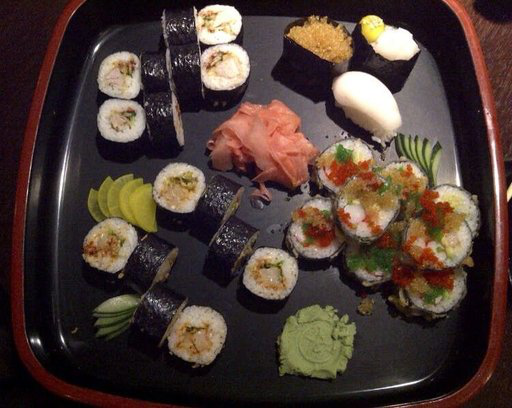

In [23]:
# explore data
random.seed(42)
image_path_list = list (image_path.glob ('*/*/*.jpg'))
image_path_list 
random_image_path = random.choice (image_path_list)
random_image_path
image_class = random_image_path.parent.stem
image_class
img = Image.open(random_image_path)
print (f'Image height: {img.height}')
print (f'Image width: {img.width}')
img

## Code to show set of pictures

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(384, 512, 3)
(384, 512, 3)
(384, 512, 3)
(512, 384, 3)
(484, 512, 3)
(512, 512, 3)


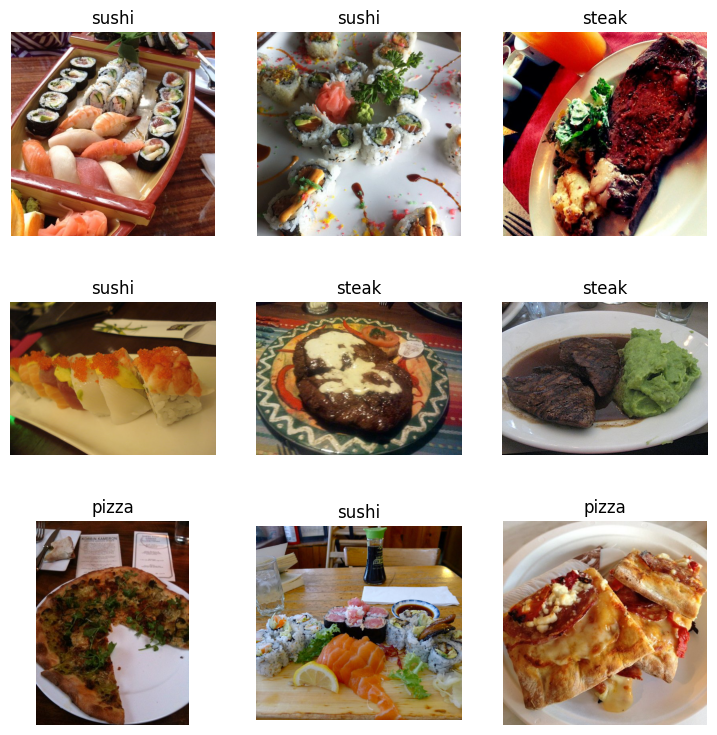

In [24]:
# show list of images
rows, cols = 3, 3
img_rng = range(1, rows * cols +1)
fig  = plt.figure(figsize = (9,9))
for i in img_rng:
    random.seed()
    img_path = random.choice (image_path_list)
    image_class = img_path.parent.stem
    img = Image.open(img_path)
    fig.add_subplot(rows, cols, i)
    img_as_array = np.asarray(img)
    plt.imshow (img)
    plt.title (image_class)
    plt.axis(False)
    print (img_as_array.shape)
    
    
    
    



In [25]:
# transforming data in pytorch tensors
# turn to torch to torch Dataset and DataLoader

In [26]:
# create transform
data_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
    
])
img_torch = data_transform(img)
img_torch.dtype

torch.float32

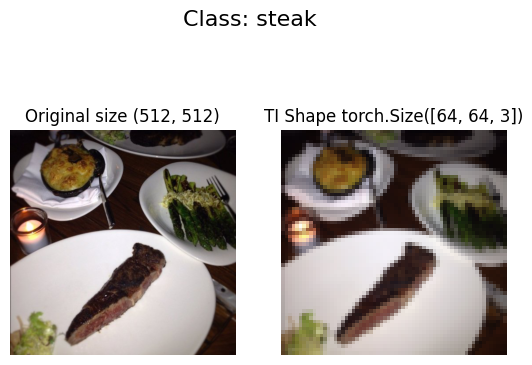

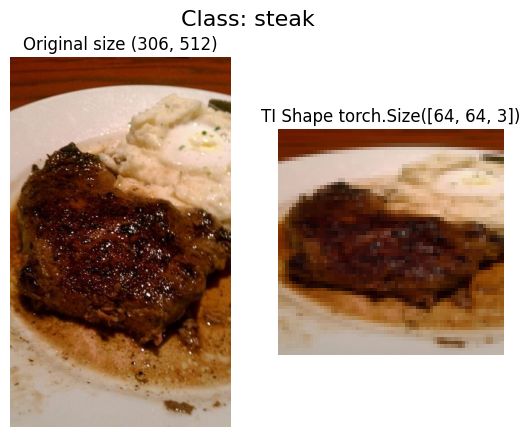

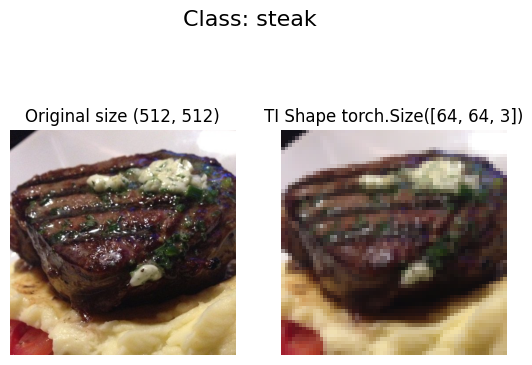

In [27]:
# visualize the transforms
def plot_transformed_images (image_paths, transform, n =3, seed = None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k = 3)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            # plot original
            fig, ax = plt.subplots(nrows = 1, ncols = 2 )
            ax[0].imshow(f)
            ax[0].set_title(f'Original size {f.size}')
            ax[0].axis(False)
            
            # show transfored
            transformed_image = transform (f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'TI Shape {transformed_image.shape}')
            ax[1].axis ('off')
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)
        
    
plot_transformed_images (image_paths = image_path_list, transform = data_transform)


## load dataset using ImageFolder

In [28]:
# use image  folder
train_data = datasets.ImageFolder(root = train_dir,
                                  transform=data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform=data_transform)

train_data, test_data
class_names = train_data.classes

Text(0.5, 1.0, 'pizza')

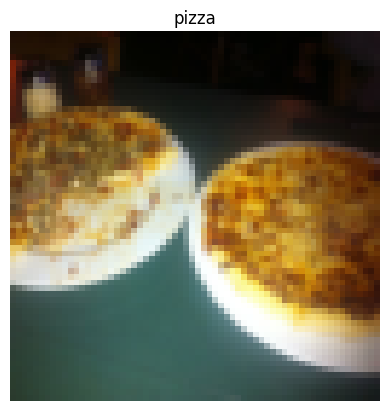

In [29]:
# visualize train data data
img, label = train_data[0]
img, label
img_permute = img.permute(1,2, 0)
plt.imshow(img_permute)
plt.axis('off')
plt.title (class_names[label])

## dataloader



In [30]:
BATCH_SIZE = 16
train_dataloader = DataLoader(dataset = train_data,
                                batch_size = BATCH_SIZE,
                                num_workers=os.cpu_count(),
                                shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)
len(train_data), len(test_data)

(225, 75)

In [31]:
img, label = next(iter(train_dataloader))
img.shape

torch.Size([16, 3, 64, 64])

## Creating own custom dataset

### helper function to get class names

In [32]:
target_directory = train_dir
class_names_found = sorted([entry.name for entry in list (os.scandir(target_directory))])
class_names_found

# target_directory = train_dir
# class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
# class_names_found

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())
    
    if not classes:
        raise FileNotFoundError(f'classes not found in director')
    class_to_idx  = {class_name: i for i, class_name in enumerate(classes)}
    
    return classes, class_to_idx
    
find_classes(target_directory)  

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### creat cusom dataset

In [33]:
# create torchutis
class ImageFolderCustom(Dataset):
    # initialize
    def __init__(self, targ_dir: str, 
                 transform=None):
        # get image paths
        self.paths = list (pathlib.Path(targ_dir).glob("*/*.jpg"))
        # set up transfor
        self.transform = transform
        # set up classes and class_to_idx
        self.classes, self.class_to_idx  = find_classes(targ_dir)
        
     # load images   
    def load_image (self, index: int)->Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
     
    def __getitem__ (self, index: int) -> Tuple[torch.Tensor, int]:
        
        img =self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        # transform if necess
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx
        
    
    

In [61]:
# test the daat class
train_transforms = transforms.Compose([
                                    transforms.Resize(size = (64,64)),
                                    transforms.RandomHorizontalFlip(p=.5),
                                    transforms.ToTensor()
    
                                    ])

test_transforms = transforms.Compose([
                                    transforms.Resize(size = (64, 64)),
                                    transforms.ToTensor()
                                    ])

In [35]:
# test image folder customer
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [36]:
# # get training data
# train_data = datasets.Food101(root=data_dir,
#                               split='train',
#                               download=True)

# # Get testing data
# test_data = datasets.Food101(root=data_dir,
#                              split='test',
#                              download=True)

In [37]:
len(train_data_custom), len(test_data_custom)
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [38]:
# check for equality
print(test_data.classes==test_data_custom.classes)

True


In [39]:
# # test image folder customer
# train_data_custom = ImageFolderCustom(targ_dir = train_dir,
#                                       transform=train_transforms)

# test_data_custom = ImageFolderCustom()

### visualzie

In [40]:
def display_random_images(dataset: torch.utils.data.Dataset,
                           classes: List[str] = None,
                           n: int= 10,
                           display_shape: bool = True,
                           seed: int = None):
    if n > 10:
        n = 10
        display_shape = False
        
    if seed:
        random.seed(seed)
    
    random_samples_idx = random.sample(range(len(dataset)), k = n)
    
    plt.figure (figsize = (16,8))
    
    for i, targ_sample  in enumerate(random_samples_idx):
        targ_image, targ_targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    # print (f'targ_image, shape{targ_image.shape}')   
        targ_image_adjust = targ_image.permute(1,2,0)
        
        plt.subplot (1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis ('off')
        if classes:
            title = f'Class: {classes[targ_targ_label]}'
            if display_shape:
                title = title + f'\nshape: {targ_image_adjust.shape}'  
        plt.title(title)    


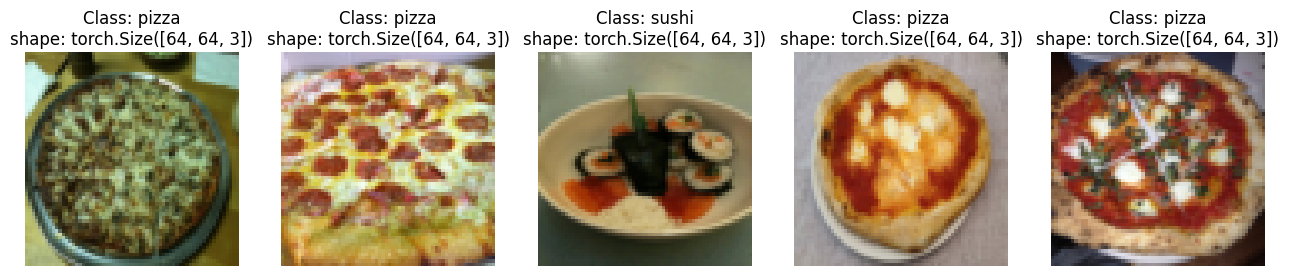

In [41]:
display_random_images(train_data,
                      n = 5,
                      classes = class_names,
                      seed=None)

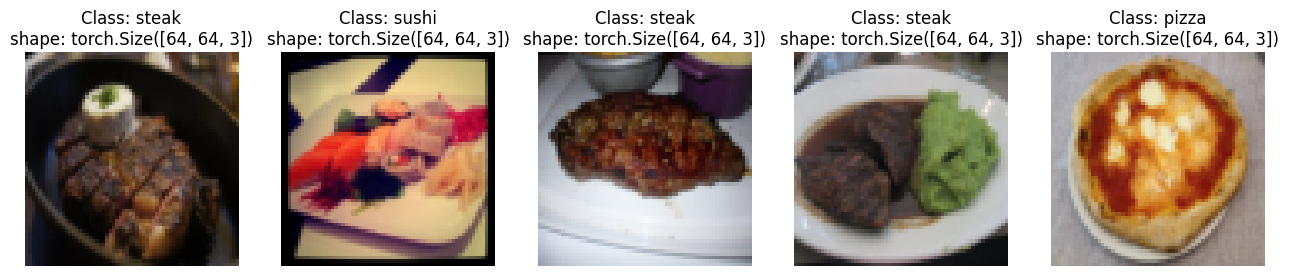

In [42]:
display_random_images(train_data_custom,
                      n = 5,
                      classes = class_names,
                      seed=None)

In [43]:
BATCH_SIZE = 25
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                              batch_size = BATCH_SIZE,
                            #   num_workers = os.cpu_count(),
                              shuffle = True                   
                              )

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                             batch_size = BATCH_SIZE,
                            #  num_workers = os.cpu_count(),
                             shuffle = False)

In [44]:
img_custom, label_custom = next (iter (train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([25, 3, 64, 64]), torch.Size([25]))

## data augmentation

In [65]:
train_transform_aug = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_aug = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor()
])

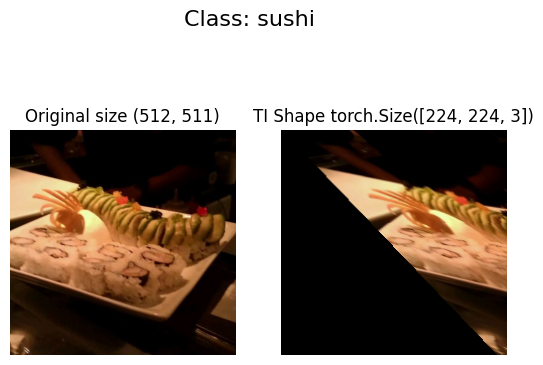

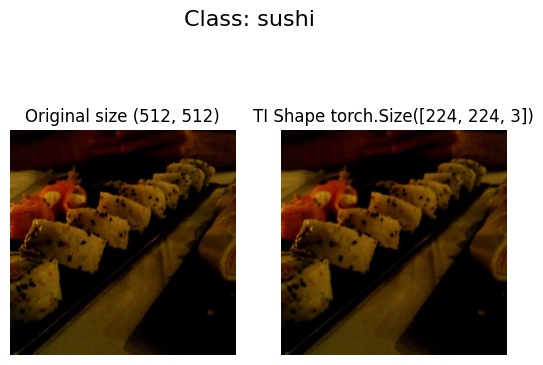

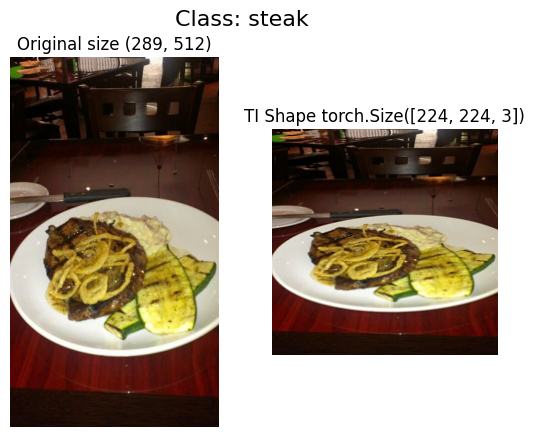

In [46]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n = 3,
    seed = None
)

### My code classify these images

In [49]:
# set up length
out_shape = len(class_names)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print (device)


cuda


In [135]:
# do the CNN to classify into one of e classes
class HassanFood(nn.Module):
    def __init__ (self, input_shape, hidden_units, output_shape,
                  in_ConvNN_ker_size: int = 3,
                  in_ConvNN_stirde:int = 1,
                  in_ConvNN_pad: int = 1,
                  in_MAXP_KerSize: int = 4,
                  in_MAXP_stride = 1,
                  in_batch_size = 32):
        super().__init__()
        self.conv1= nn.Conv2d(
                in_channels = input_shape,
                out_channels = hidden_units,
                kernel_size = in_ConvNN_ker_size,
                stride = in_ConvNN_stirde,
                padding = in_ConvNN_pad 
                )
        self.conv2 = nn.Conv2d(
            in_channels = hidden_units,
            out_channels=hidden_units,
            kernel_size=in_ConvNN_ker_size,
            stride=in_ConvNN_stirde,
            padding=in_ConvNN_pad
        )
        self.relu = nn.LeakyReLU()
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d(kernel_size=in_MAXP_KerSize,
                                    stride = in_MAXP_stride)
        self.lazydense = nn.LazyLinear(out_features=output_shape)

    def forward (self, x):
        # first convolution and maxpool
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # second convolution and maxpool
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # flatten and send through dense linesr
        x = self.flatten(x)
        x = self.lazydense(x)

        return (x)
    
torch.manual_seed(42)
model_custom_1 = HassanFood(input_shape = 3,
                            hidden_units = 8,
                            output_shape = out_shape).to(device)
model_custom_1

HassanFood(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): LeakyReLU(negative_slope=0.01)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (maxpool): MaxPool2d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  (lazydense): LazyLinear(in_features=0, out_features=3, bias=True)
)

In [136]:
class HassanCNN(nn.Module):
    def __init__ (self,input_shape, hidden_units, output_shape,
            in_conv_k_size:int = 3,
            in_stride:int = 1,
            in_pad:int = 1,
            in_maxp_k_size = 2,
            in_maxp_stride = 2,
            in_batch_size = 32):
        super().__init__()
        self.conv1 = nn.Conv2d(
                            in_channels = input_shape,
                            out_channels = hidden_units,
                            kernel_size=in_conv_k_size,
                            stride = in_stride,
                            padding = in_pad)
        self.conv2 = nn.Conv2d(
                            in_channels = hidden_units,
                            out_channels = hidden_units,
                            kernel_size=in_conv_k_size,
                            stride = in_stride,
                            padding = in_pad)
        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool2d(kernel_size=in_maxp_k_size,
                                    stride = in_maxp_stride)
        self.flatten = nn.Flatten()
        # self.linear = nn.Linear()
        self.lazydense = nn.LazyLinear(out_features = output_shape)

    def forward (self, x):
        # first block
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        

        # second block
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # flatten
        # linear_output = x.size(1) * x.size(2) * hidden_units
        x = self.flatten(x)
        # flattened_size = x.view(in_batch_size, -1).size(1)
        # flattened_features = hidden_units * flattened_size
        # flattened_feature = x.shape[0] * x.shape[1]
        x = self.lazydense (x)
        return x

torch.manual_seed(42)
model_has1 = HassanCNN(input_shape = 3,
                       hidden_units = 10,
                       output_shape = 3).to(device)

model_has1

HassanCNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lazydense): LazyLinear(in_features=0, out_features=3, bias=True)
)

In [66]:
# create dataset
train_data_aug = ImageFolderCustom(targ_dir = train_dir,
                                      transform=train_transform_aug)

test_data_aug = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform_aug)

In [137]:
X, y = train_data_aug [0]
X = X.to(device)
pred = model_custom_1(X.unsqueeze(dim = 0))
# pred = model_has1(X.unsqueeze(dim = 0))
pred

tensor([[0.0358, 0.0603, 0.0137]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Train it

In [140]:
# loss and optimzer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_custom_1.parameters(), lr = 0.01)

In [91]:
# timer
def print_train_time (start:float,
                      end: float,
                      device:torch.device = None):
    total_time = end - start
    print (f'Total tiem {device}: {total_time:.3f} seconds')
    return total_time

In [89]:
import torch.utils
import torch.utils.data


def train_loop (model: nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                accuracy_fn,
                device:torch.device=device):
    train_loss = 0
    train_acc = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_train_pred = model(X)
        loss = loss_fn (y_train_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true = y,
                                 y_pred = y_train_pred.argmax(dim = 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print (f'Train Loss {train_loss:.4f} - train acc {train_acc:.2f}')


def test_loop(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device:torch.device = device):
    
    test_loss = 0
    test_acc = 0
    model.eval()
    for batch, (X, y)in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_test_pred = model(X)
        test_loss += loss_fn (y_test_pred, y)
        test_acc += accuracy_fn(y_true = y, 
                                y_pred = y_test_pred.argmax(dim = 1))
        
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    print (f'Test Loss {test_loss:.4f} - Test acc {test_acc:.2f}')



In [112]:
# create dataloaders
BATCH_SIZE = 8
train_dataloader_aug = DataLoader(dataset = train_data_aug,
                              batch_size = BATCH_SIZE,
                            #   num_workers = os.cpu_count(),
                              shuffle = True                   
                              )

test_dataloader_aug = DataLoader(dataset = test_data_aug,
                             batch_size = BATCH_SIZE,
                            #  num_workers = os.cpu_count(),
                             shuffle = False)

In [ ]:
# # X, y = next(iter(train_dataloader_aug))
# # X, y = X.to(device), y.to(device)
# # y_train_pred = model_custom_1(X)
# # y_train_pred

# # X, y = train_data_aug [0]
# X, y = train_data_custom[0]
# X = X.to(device)
# pred = model_custom_1(X.unsqueeze(dim = 0))
# pred, y
# # X.shape, y

In [143]:
# run through coe
torch.manual_seed(42)
train_start_time_model_custom_1 =timer ()
epochs = 1000
range_epochs = range (epochs)
for epoch in tqdm(range_epochs):
    print (f'Epoch: {epoch}\n')
    train_loop (model = model_custom_1,
                dataloader = train_dataloader_aug,
                loss_fn = loss_fn,
                optimizer=optimizer,
                accuracy_fn=accuracy_fn
                 )

    test_loop (model = model_custom_1,
               dataloader = test_dataloader_aug,
               loss_fn = loss_fn,
               accuracy_fn=accuracy_fn)
    
train_end_time_model_custom_1 = timer()

tot_time_model_custom_1 = print_train_time(start =train_start_time_model_custom_1,
                                           end = train_end_time_model_custom_1,
                                            device = device )


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0

Train Loss 0.4235 - train acc 86.21


  0%|          | 1/1000 [00:01<31:55,  1.92s/it]

Test Loss 1.6442 - Test acc 40.00
Epoch: 1

Train Loss 0.5086 - train acc 77.59


  0%|          | 2/1000 [00:03<30:37,  1.84s/it]

Test Loss 1.1511 - Test acc 45.83
Epoch: 2

Train Loss 0.4868 - train acc 81.03


  0%|          | 3/1000 [00:05<30:39,  1.84s/it]

Test Loss 1.1106 - Test acc 42.50
Epoch: 3

Train Loss 0.3760 - train acc 82.76


  0%|          | 4/1000 [00:07<32:12,  1.94s/it]

Test Loss 1.6042 - Test acc 42.50
Epoch: 4

Train Loss 0.4409 - train acc 82.33


  0%|          | 5/1000 [00:09<31:17,  1.89s/it]

Test Loss 1.4466 - Test acc 56.25
Epoch: 5

Train Loss 0.5010 - train acc 81.47


  1%|          | 6/1000 [00:11<32:26,  1.96s/it]

Test Loss 1.1110 - Test acc 38.75
Epoch: 6

Train Loss 0.4877 - train acc 79.74


  1%|          | 7/1000 [00:13<31:23,  1.90s/it]

Test Loss 1.3339 - Test acc 48.33
Epoch: 7

Train Loss 0.4628 - train acc 83.62


  1%|          | 8/1000 [00:15<31:06,  1.88s/it]

Test Loss 1.2864 - Test acc 42.50
Epoch: 8

Train Loss 0.4080 - train acc 84.91


  1%|          | 9/1000 [00:17<31:58,  1.94s/it]

Test Loss 1.3603 - Test acc 42.08
Epoch: 9

Train Loss 0.3975 - train acc 84.48


  1%|          | 10/1000 [00:19<31:27,  1.91s/it]

Test Loss 1.2628 - Test acc 44.58
Epoch: 10

Train Loss 0.5142 - train acc 78.45


  1%|          | 11/1000 [00:20<30:53,  1.87s/it]

Test Loss 1.2509 - Test acc 43.33
Epoch: 11

Train Loss 0.4973 - train acc 81.03


  1%|          | 12/1000 [00:22<31:10,  1.89s/it]

Test Loss 1.1722 - Test acc 54.58
Epoch: 12

Train Loss 0.4818 - train acc 81.47


  1%|▏         | 13/1000 [00:24<31:06,  1.89s/it]

Test Loss 1.3380 - Test acc 37.50
Epoch: 13

Train Loss 0.4569 - train acc 83.62


  1%|▏         | 14/1000 [00:26<30:57,  1.88s/it]

Test Loss 1.1435 - Test acc 58.75
Epoch: 14

Train Loss 0.5153 - train acc 75.86


  2%|▏         | 15/1000 [00:28<32:03,  1.95s/it]

Test Loss 1.0752 - Test acc 51.67
Epoch: 15

Train Loss 0.3761 - train acc 85.78


  2%|▏         | 16/1000 [00:30<31:49,  1.94s/it]

Test Loss 1.1873 - Test acc 49.58
Epoch: 16

Train Loss 0.5351 - train acc 77.59


  2%|▏         | 17/1000 [00:32<32:11,  1.97s/it]

Test Loss 1.0803 - Test acc 43.33
Epoch: 17

Train Loss 0.4743 - train acc 80.60


  2%|▏         | 18/1000 [00:34<31:50,  1.95s/it]

Test Loss 1.2900 - Test acc 57.50
Epoch: 18

Train Loss 0.3771 - train acc 85.34


  2%|▏         | 19/1000 [00:36<32:27,  1.99s/it]

Test Loss 1.2196 - Test acc 38.75
Epoch: 19

Train Loss 0.5406 - train acc 79.31


  2%|▏         | 20/1000 [00:38<31:27,  1.93s/it]

Test Loss 1.3771 - Test acc 34.58
Epoch: 20

Train Loss 0.5474 - train acc 75.86


  2%|▏         | 21/1000 [00:40<31:08,  1.91s/it]

Test Loss 1.7000 - Test acc 54.17
Epoch: 21

Train Loss 0.4274 - train acc 83.19


  2%|▏         | 22/1000 [00:42<31:46,  1.95s/it]

Test Loss 1.4495 - Test acc 37.50
Epoch: 22

Train Loss 0.3742 - train acc 84.91


  2%|▏         | 23/1000 [00:44<31:58,  1.96s/it]

Test Loss 1.3283 - Test acc 48.33
Epoch: 23

Train Loss 0.4916 - train acc 79.74


  2%|▏         | 24/1000 [00:46<31:40,  1.95s/it]

Test Loss 1.3575 - Test acc 45.42
Epoch: 24

Train Loss 0.5065 - train acc 81.03


  2%|▎         | 25/1000 [00:48<31:17,  1.93s/it]

Test Loss 1.1533 - Test acc 47.08
Epoch: 25

Train Loss 0.5272 - train acc 78.88


  3%|▎         | 26/1000 [00:50<31:44,  1.96s/it]

Test Loss 1.1590 - Test acc 48.75
Epoch: 26

Train Loss 0.4348 - train acc 84.05


  3%|▎         | 27/1000 [00:51<31:10,  1.92s/it]

Test Loss 1.1766 - Test acc 53.33
Epoch: 27

Train Loss 0.4783 - train acc 81.47


  3%|▎         | 28/1000 [00:53<31:04,  1.92s/it]

Test Loss 1.3220 - Test acc 36.25
Epoch: 28

Train Loss 0.4959 - train acc 78.88


  3%|▎         | 29/1000 [00:55<30:28,  1.88s/it]

Test Loss 1.1814 - Test acc 49.17
Epoch: 29

Train Loss 0.4027 - train acc 83.62


  3%|▎         | 30/1000 [00:57<30:35,  1.89s/it]

Test Loss 1.2769 - Test acc 40.00
Epoch: 30

Train Loss 0.4421 - train acc 83.19


  3%|▎         | 31/1000 [00:59<31:03,  1.92s/it]

Test Loss 1.4030 - Test acc 48.33
Epoch: 31

Train Loss 0.4264 - train acc 84.48


  3%|▎         | 32/1000 [01:01<30:26,  1.89s/it]

Test Loss 1.2363 - Test acc 41.25
Epoch: 32

Train Loss 0.3622 - train acc 86.64


  3%|▎         | 33/1000 [01:03<30:04,  1.87s/it]

Test Loss 1.3494 - Test acc 42.08
Epoch: 33

Train Loss 0.5064 - train acc 76.72


  3%|▎         | 34/1000 [01:05<30:50,  1.92s/it]

Test Loss 1.6261 - Test acc 36.25
Epoch: 34

Train Loss 0.4287 - train acc 82.76


  4%|▎         | 35/1000 [01:07<30:50,  1.92s/it]

Test Loss 1.0495 - Test acc 59.17
Epoch: 35

Train Loss 0.3747 - train acc 83.19


  4%|▎         | 36/1000 [01:09<31:01,  1.93s/it]

Test Loss 1.1284 - Test acc 46.67
Epoch: 36

Train Loss 0.4538 - train acc 82.33


  4%|▎         | 37/1000 [01:10<30:14,  1.88s/it]

Test Loss 1.0583 - Test acc 52.92
Epoch: 37

Train Loss 0.3609 - train acc 84.91


  4%|▍         | 38/1000 [01:12<29:42,  1.85s/it]

Test Loss 1.1921 - Test acc 44.17
Epoch: 38

Train Loss 0.4715 - train acc 82.33


  4%|▍         | 39/1000 [01:14<30:11,  1.89s/it]

Test Loss 1.1276 - Test acc 56.25
Epoch: 39

Train Loss 0.4296 - train acc 81.47


  4%|▍         | 40/1000 [01:16<30:47,  1.92s/it]

Test Loss 1.2552 - Test acc 40.00
Epoch: 40

Train Loss 0.3312 - train acc 87.93


  4%|▍         | 41/1000 [01:18<31:16,  1.96s/it]

Test Loss 1.2174 - Test acc 46.25
Epoch: 41

Train Loss 0.3100 - train acc 90.09


  4%|▍         | 42/1000 [01:20<31:37,  1.98s/it]

Test Loss 1.2216 - Test acc 55.00
Epoch: 42

Train Loss 0.3581 - train acc 83.19


  4%|▍         | 43/1000 [01:22<31:03,  1.95s/it]

Test Loss 1.5223 - Test acc 40.00
Epoch: 43

Train Loss 0.4040 - train acc 79.31


  4%|▍         | 44/1000 [01:24<30:03,  1.89s/it]

Test Loss 1.6017 - Test acc 32.50
Epoch: 44

Train Loss 0.4117 - train acc 84.05


  4%|▍         | 45/1000 [01:26<30:18,  1.90s/it]

Test Loss 1.1498 - Test acc 43.33
Epoch: 45

Train Loss 0.3751 - train acc 84.05


  5%|▍         | 46/1000 [01:28<30:53,  1.94s/it]

Test Loss 1.1952 - Test acc 43.75
Epoch: 46

Train Loss 0.3430 - train acc 85.34


  5%|▍         | 47/1000 [01:30<31:00,  1.95s/it]

Test Loss 1.3283 - Test acc 42.50
Epoch: 47

Train Loss 0.4686 - train acc 82.33


  5%|▍         | 48/1000 [01:32<30:44,  1.94s/it]

Test Loss 1.0645 - Test acc 49.17
Epoch: 48

Train Loss 0.4812 - train acc 81.90


  5%|▍         | 49/1000 [01:33<29:51,  1.88s/it]

Test Loss 1.1074 - Test acc 51.25
Epoch: 49

Train Loss 0.4826 - train acc 79.74


  5%|▌         | 50/1000 [01:35<29:50,  1.89s/it]

Test Loss 1.4527 - Test acc 41.25
Epoch: 50

Train Loss 0.3732 - train acc 83.19


  5%|▌         | 51/1000 [01:37<30:17,  1.91s/it]

Test Loss 1.3296 - Test acc 38.75
Epoch: 51

Train Loss 0.3598 - train acc 85.78


  5%|▌         | 52/1000 [01:39<30:44,  1.95s/it]

Test Loss 1.3271 - Test acc 40.00
Epoch: 52

Train Loss 0.3323 - train acc 86.21


  5%|▌         | 53/1000 [01:41<30:57,  1.96s/it]

Test Loss 1.4733 - Test acc 43.75
Epoch: 53

Train Loss 0.4096 - train acc 85.34


  5%|▌         | 54/1000 [01:43<31:05,  1.97s/it]

Test Loss 1.1147 - Test acc 52.92
Epoch: 54

Train Loss 0.3644 - train acc 82.76


  6%|▌         | 55/1000 [01:45<30:47,  1.96s/it]

Test Loss 2.1048 - Test acc 40.00
Epoch: 55

Train Loss 0.4727 - train acc 80.60


  6%|▌         | 56/1000 [01:47<30:26,  1.94s/it]

Test Loss 1.2421 - Test acc 40.00
Epoch: 56

Train Loss 0.4106 - train acc 83.19


  6%|▌         | 57/1000 [01:49<30:32,  1.94s/it]

Test Loss 1.0622 - Test acc 51.67
Epoch: 57

Train Loss 0.4988 - train acc 76.29


  6%|▌         | 58/1000 [01:51<30:14,  1.93s/it]

Test Loss 3.0444 - Test acc 26.25
Epoch: 58

Train Loss 0.5072 - train acc 80.17


  6%|▌         | 59/1000 [01:53<30:55,  1.97s/it]

Test Loss 1.3141 - Test acc 42.08
Epoch: 59

Train Loss 0.4330 - train acc 83.62


  6%|▌         | 60/1000 [01:55<30:51,  1.97s/it]

Test Loss 1.2369 - Test acc 43.33
Epoch: 60

Train Loss 0.4045 - train acc 86.21


  6%|▌         | 61/1000 [01:57<30:12,  1.93s/it]

Test Loss 1.2039 - Test acc 45.83
Epoch: 61

Train Loss 0.3204 - train acc 87.93


  6%|▌         | 62/1000 [01:59<29:52,  1.91s/it]

Test Loss 1.2552 - Test acc 48.33
Epoch: 62

Train Loss 0.3243 - train acc 87.50


  6%|▋         | 63/1000 [02:01<30:25,  1.95s/it]

Test Loss 1.3744 - Test acc 42.50
Epoch: 63

Train Loss 0.3732 - train acc 84.91


  6%|▋         | 64/1000 [02:03<30:25,  1.95s/it]

Test Loss 1.4128 - Test acc 45.83
Epoch: 64

Train Loss 0.3630 - train acc 84.91


  6%|▋         | 65/1000 [02:05<30:02,  1.93s/it]

Test Loss 1.8512 - Test acc 43.75
Epoch: 65

Train Loss 0.3484 - train acc 86.21


  7%|▋         | 66/1000 [02:06<29:54,  1.92s/it]

Test Loss 1.2749 - Test acc 46.25
Epoch: 66

Train Loss 0.2987 - train acc 87.93


  7%|▋         | 67/1000 [02:08<30:25,  1.96s/it]

Test Loss 1.3199 - Test acc 43.33
Epoch: 67

Train Loss 0.4088 - train acc 85.34


  7%|▋         | 68/1000 [02:10<30:22,  1.96s/it]

Test Loss 1.3659 - Test acc 43.75
Epoch: 68

Train Loss 0.3543 - train acc 86.64


  7%|▋         | 69/1000 [02:12<30:12,  1.95s/it]

Test Loss 1.0733 - Test acc 55.42
Epoch: 69

Train Loss 0.3476 - train acc 86.21


  7%|▋         | 70/1000 [02:14<30:32,  1.97s/it]

Test Loss 1.1401 - Test acc 52.50
Epoch: 70

Train Loss 0.3357 - train acc 86.21


  7%|▋         | 71/1000 [02:16<30:43,  1.98s/it]

Test Loss 1.5677 - Test acc 47.08
Epoch: 71

Train Loss 0.4318 - train acc 86.21


  7%|▋         | 72/1000 [02:18<30:49,  1.99s/it]

Test Loss 1.0939 - Test acc 47.92
Epoch: 72

Train Loss 0.3062 - train acc 87.50


  7%|▋         | 73/1000 [02:20<29:44,  1.93s/it]

Test Loss 1.1431 - Test acc 47.50
Epoch: 73

Train Loss 0.2773 - train acc 88.36


  7%|▋         | 74/1000 [02:22<29:26,  1.91s/it]

Test Loss 1.3344 - Test acc 37.50
Epoch: 74

Train Loss 0.3897 - train acc 82.76


  8%|▊         | 75/1000 [02:24<29:31,  1.91s/it]

Test Loss 1.2666 - Test acc 39.58
Epoch: 75

Train Loss 0.4806 - train acc 79.74


  8%|▊         | 76/1000 [02:26<29:29,  1.92s/it]

Test Loss 1.0763 - Test acc 48.75
Epoch: 76

Train Loss 0.3056 - train acc 89.66


  8%|▊         | 77/1000 [02:28<29:06,  1.89s/it]

Test Loss 1.2857 - Test acc 37.50
Epoch: 77

Train Loss 0.4301 - train acc 79.31


  8%|▊         | 78/1000 [02:30<28:50,  1.88s/it]

Test Loss 1.0968 - Test acc 53.33
Epoch: 78

Train Loss 0.3275 - train acc 85.34


  8%|▊         | 79/1000 [02:32<29:28,  1.92s/it]

Test Loss 1.1155 - Test acc 54.17
Epoch: 79

Train Loss 0.3436 - train acc 85.78


  8%|▊         | 80/1000 [02:33<29:15,  1.91s/it]

Test Loss 1.0862 - Test acc 50.83
Epoch: 80

Train Loss 0.4348 - train acc 82.76


  8%|▊         | 81/1000 [02:35<28:48,  1.88s/it]

Test Loss 1.1619 - Test acc 51.25
Epoch: 81

Train Loss 0.3184 - train acc 87.93


  8%|▊         | 82/1000 [02:37<28:25,  1.86s/it]

Test Loss 1.2275 - Test acc 42.50
Epoch: 82

Train Loss 0.3790 - train acc 86.64


  8%|▊         | 83/1000 [02:39<29:17,  1.92s/it]

Test Loss 1.0302 - Test acc 57.50
Epoch: 83

Train Loss 0.3578 - train acc 87.93


  8%|▊         | 84/1000 [02:41<29:53,  1.96s/it]

Test Loss 1.1212 - Test acc 43.33
Epoch: 84

Train Loss 0.4167 - train acc 81.90


  8%|▊         | 85/1000 [02:43<30:22,  1.99s/it]

Test Loss 1.0853 - Test acc 45.00
Epoch: 85

Train Loss 0.3045 - train acc 88.79


  9%|▊         | 86/1000 [02:45<29:47,  1.96s/it]

Test Loss 1.1008 - Test acc 43.75
Epoch: 86

Train Loss 0.3795 - train acc 85.34


  9%|▊         | 87/1000 [02:47<29:21,  1.93s/it]

Test Loss 1.0299 - Test acc 43.75
Epoch: 87

Train Loss 0.3385 - train acc 86.64


  9%|▉         | 88/1000 [02:49<29:14,  1.92s/it]

Test Loss 0.9731 - Test acc 55.42
Epoch: 88

Train Loss 0.3475 - train acc 84.91


  9%|▉         | 89/1000 [02:51<28:24,  1.87s/it]

Test Loss 1.0731 - Test acc 53.33
Epoch: 89

Train Loss 0.3271 - train acc 87.50


  9%|▉         | 90/1000 [02:53<28:38,  1.89s/it]

Test Loss 1.0474 - Test acc 47.08
Epoch: 90

Train Loss 0.3830 - train acc 84.48


  9%|▉         | 91/1000 [02:54<28:11,  1.86s/it]

Test Loss 1.0415 - Test acc 56.67
Epoch: 91

Train Loss 0.3248 - train acc 89.22


  9%|▉         | 92/1000 [02:56<28:35,  1.89s/it]

Test Loss 1.1004 - Test acc 52.08
Epoch: 92

Train Loss 0.2684 - train acc 90.95


  9%|▉         | 93/1000 [02:58<28:24,  1.88s/it]

Test Loss 1.0780 - Test acc 54.17
Epoch: 93

Train Loss 0.3275 - train acc 88.36


  9%|▉         | 94/1000 [03:00<28:08,  1.86s/it]

Test Loss 1.6663 - Test acc 45.00
Epoch: 94

Train Loss 0.3858 - train acc 84.48


 10%|▉         | 95/1000 [03:02<28:06,  1.86s/it]

Test Loss 1.1226 - Test acc 43.75
Epoch: 95

Train Loss 0.3309 - train acc 85.34


 10%|▉         | 96/1000 [03:04<27:44,  1.84s/it]

Test Loss 1.0842 - Test acc 44.58
Epoch: 96

Train Loss 0.2941 - train acc 87.50


 10%|▉         | 97/1000 [03:06<27:47,  1.85s/it]

Test Loss 1.1683 - Test acc 43.75
Epoch: 97

Train Loss 0.3582 - train acc 85.34


 10%|▉         | 98/1000 [03:07<27:17,  1.82s/it]

Test Loss 1.1235 - Test acc 42.50
Epoch: 98

Train Loss 0.3532 - train acc 83.62


 10%|▉         | 99/1000 [03:09<27:13,  1.81s/it]

Test Loss 1.4079 - Test acc 43.75
Epoch: 99

Train Loss 0.3250 - train acc 85.34


 10%|█         | 100/1000 [03:11<27:30,  1.83s/it]

Test Loss 1.1717 - Test acc 43.75
Epoch: 100

Train Loss 0.4704 - train acc 83.62


 10%|█         | 101/1000 [03:13<27:45,  1.85s/it]

Test Loss 2.0398 - Test acc 43.75
Epoch: 101

Train Loss 0.5935 - train acc 72.84


 10%|█         | 102/1000 [03:15<27:24,  1.83s/it]

Test Loss 1.0886 - Test acc 51.67
Epoch: 102

Train Loss 0.4870 - train acc 81.03


 10%|█         | 103/1000 [03:17<27:43,  1.85s/it]

Test Loss 1.1328 - Test acc 40.00
Epoch: 103

Train Loss 0.4426 - train acc 82.33


 10%|█         | 104/1000 [03:18<27:00,  1.81s/it]

Test Loss 1.1065 - Test acc 43.75
Epoch: 104

Train Loss 0.3559 - train acc 87.93


 10%|█         | 105/1000 [03:20<26:58,  1.81s/it]

Test Loss 1.2273 - Test acc 50.00
Epoch: 105

Train Loss 0.4752 - train acc 79.74


 11%|█         | 106/1000 [03:22<27:25,  1.84s/it]

Test Loss 1.2192 - Test acc 55.00
Epoch: 106

Train Loss 0.4865 - train acc 78.88


 11%|█         | 107/1000 [03:24<27:11,  1.83s/it]

Test Loss 1.0804 - Test acc 40.00
Epoch: 107

Train Loss 0.4794 - train acc 80.60


 11%|█         | 108/1000 [03:26<26:54,  1.81s/it]

Test Loss 1.1695 - Test acc 47.50
Epoch: 108

Train Loss 0.4341 - train acc 80.60


 11%|█         | 109/1000 [03:28<27:40,  1.86s/it]

Test Loss 1.1745 - Test acc 47.08
Epoch: 109

Train Loss 0.3397 - train acc 85.78


 11%|█         | 110/1000 [03:29<26:58,  1.82s/it]

Test Loss 1.2396 - Test acc 46.25
Epoch: 110

Train Loss 0.3947 - train acc 84.48


 11%|█         | 111/1000 [03:31<26:53,  1.82s/it]

Test Loss 1.3199 - Test acc 45.00
Epoch: 111

Train Loss 0.3407 - train acc 87.93


 11%|█         | 112/1000 [03:33<26:59,  1.82s/it]

Test Loss 1.4344 - Test acc 46.25
Epoch: 112

Train Loss 0.4124 - train acc 85.34


 11%|█▏        | 113/1000 [03:35<26:35,  1.80s/it]

Test Loss 1.1846 - Test acc 48.75
Epoch: 113

Train Loss 0.4399 - train acc 83.62


 11%|█▏        | 114/1000 [03:37<26:47,  1.81s/it]

Test Loss 1.2469 - Test acc 47.50
Epoch: 114

Train Loss 0.3835 - train acc 86.64


 12%|█▏        | 115/1000 [03:38<26:56,  1.83s/it]

Test Loss 1.2158 - Test acc 57.92
Epoch: 115

Train Loss 0.4078 - train acc 86.64


 12%|█▏        | 116/1000 [03:40<26:52,  1.82s/it]

Test Loss 1.0632 - Test acc 53.33
Epoch: 116

Train Loss 0.4051 - train acc 86.21


 12%|█▏        | 117/1000 [03:42<27:26,  1.86s/it]

Test Loss 1.2380 - Test acc 42.50
Epoch: 117

Train Loss 0.3787 - train acc 84.05


 12%|█▏        | 118/1000 [03:44<27:31,  1.87s/it]

Test Loss 1.1099 - Test acc 49.58
Epoch: 118

Train Loss 0.4002 - train acc 84.91


 12%|█▏        | 119/1000 [03:46<27:34,  1.88s/it]

Test Loss 1.1210 - Test acc 43.75
Epoch: 119

Train Loss 0.3488 - train acc 83.19


 12%|█▏        | 120/1000 [03:48<27:11,  1.85s/it]

Test Loss 1.3156 - Test acc 43.75
Epoch: 120

Train Loss 0.3399 - train acc 87.93


 12%|█▏        | 121/1000 [03:50<27:12,  1.86s/it]

Test Loss 1.7232 - Test acc 43.75
Epoch: 121

Train Loss 0.4172 - train acc 84.91


 12%|█▏        | 122/1000 [03:51<26:57,  1.84s/it]

Test Loss 1.2640 - Test acc 43.75
Epoch: 122

Train Loss 0.4093 - train acc 86.64


 12%|█▏        | 123/1000 [03:53<26:37,  1.82s/it]

Test Loss 1.3788 - Test acc 43.75
Epoch: 123

Train Loss 0.3515 - train acc 86.21


 12%|█▏        | 124/1000 [03:55<27:10,  1.86s/it]

Test Loss 1.1737 - Test acc 52.08
Epoch: 124

Train Loss 0.4646 - train acc 81.03


 12%|█▎        | 125/1000 [03:57<26:55,  1.85s/it]

Test Loss 1.0979 - Test acc 42.50
Epoch: 125

Train Loss 0.3528 - train acc 86.64


 13%|█▎        | 126/1000 [03:59<27:20,  1.88s/it]

Test Loss 1.1878 - Test acc 56.67
Epoch: 126

Train Loss 0.3967 - train acc 86.21


 13%|█▎        | 127/1000 [04:01<27:06,  1.86s/it]

Test Loss 1.0911 - Test acc 50.00
Epoch: 127

Train Loss 0.4220 - train acc 81.90


 13%|█▎        | 128/1000 [04:03<27:10,  1.87s/it]

Test Loss 1.2088 - Test acc 56.67
Epoch: 128

Train Loss 0.3834 - train acc 85.34


 13%|█▎        | 129/1000 [04:04<26:55,  1.86s/it]

Test Loss 1.0971 - Test acc 54.58
Epoch: 129

Train Loss 0.3958 - train acc 84.05


 13%|█▎        | 130/1000 [04:06<27:25,  1.89s/it]

Test Loss 0.9480 - Test acc 55.83
Epoch: 130

Train Loss 0.4378 - train acc 84.05


 13%|█▎        | 131/1000 [04:08<28:03,  1.94s/it]

Test Loss 1.2206 - Test acc 43.75
Epoch: 131

Train Loss 0.4047 - train acc 82.76


 13%|█▎        | 132/1000 [04:10<27:29,  1.90s/it]

Test Loss 1.1072 - Test acc 45.00
Epoch: 132

Train Loss 0.4647 - train acc 78.45


 13%|█▎        | 133/1000 [04:12<28:20,  1.96s/it]

Test Loss 1.2971 - Test acc 43.75
Epoch: 133

Train Loss 0.3285 - train acc 87.50


 13%|█▎        | 134/1000 [04:14<27:57,  1.94s/it]

Test Loss 1.1634 - Test acc 48.75
Epoch: 134

Train Loss 0.2990 - train acc 86.64


 14%|█▎        | 135/1000 [04:16<28:03,  1.95s/it]

Test Loss 1.2961 - Test acc 43.75
Epoch: 135

Train Loss 0.4257 - train acc 81.47


 14%|█▎        | 136/1000 [04:18<27:51,  1.93s/it]

Test Loss 1.8019 - Test acc 49.17
Epoch: 136

Train Loss 0.5524 - train acc 81.03


 14%|█▎        | 137/1000 [04:20<27:23,  1.90s/it]

Test Loss 1.1065 - Test acc 49.58
Epoch: 137

Train Loss 0.3770 - train acc 83.62


 14%|█▍        | 138/1000 [04:22<27:55,  1.94s/it]

Test Loss 1.1020 - Test acc 54.58
Epoch: 138

Train Loss 0.3737 - train acc 87.07


 14%|█▍        | 139/1000 [04:24<28:53,  2.01s/it]

Test Loss 1.2194 - Test acc 47.50
Epoch: 139

Train Loss 0.3565 - train acc 84.48


 14%|█▍        | 140/1000 [04:26<29:14,  2.04s/it]

Test Loss 1.2198 - Test acc 42.50
Epoch: 140

Train Loss 0.5854 - train acc 81.47


 14%|█▍        | 141/1000 [04:28<29:12,  2.04s/it]

Test Loss 1.0827 - Test acc 45.00
Epoch: 141

Train Loss 0.4288 - train acc 82.33


 14%|█▍        | 142/1000 [04:30<29:38,  2.07s/it]

Test Loss 1.1847 - Test acc 50.83
Epoch: 142

Train Loss 0.3935 - train acc 83.62


 14%|█▍        | 143/1000 [04:33<29:43,  2.08s/it]

Test Loss 1.0171 - Test acc 57.92
Epoch: 143

Train Loss 0.3587 - train acc 85.34


 14%|█▍        | 144/1000 [04:35<29:53,  2.09s/it]

Test Loss 1.4049 - Test acc 42.08
Epoch: 144

Train Loss 0.3789 - train acc 85.78


 14%|█▍        | 145/1000 [04:37<30:01,  2.11s/it]

Test Loss 1.1557 - Test acc 51.67
Epoch: 145

Train Loss 0.3424 - train acc 85.78


 15%|█▍        | 146/1000 [04:39<29:39,  2.08s/it]

Test Loss 1.4378 - Test acc 38.75
Epoch: 146

Train Loss 0.4877 - train acc 81.47


 15%|█▍        | 147/1000 [04:41<29:11,  2.05s/it]

Test Loss 1.1660 - Test acc 48.33
Epoch: 147

Train Loss 0.4178 - train acc 83.62


 15%|█▍        | 148/1000 [04:43<28:39,  2.02s/it]

Test Loss 1.1653 - Test acc 46.25
Epoch: 148

Train Loss 0.3980 - train acc 82.76


 15%|█▍        | 149/1000 [04:45<27:56,  1.97s/it]

Test Loss 1.2069 - Test acc 45.00
Epoch: 149

Train Loss 0.3738 - train acc 84.91


 15%|█▌        | 150/1000 [04:47<28:09,  1.99s/it]

Test Loss 1.1049 - Test acc 45.00
Epoch: 150

Train Loss 0.2650 - train acc 88.79


 15%|█▌        | 151/1000 [04:49<27:46,  1.96s/it]

Test Loss 1.2507 - Test acc 46.25
Epoch: 151

Train Loss 0.4438 - train acc 83.62


 15%|█▌        | 152/1000 [04:50<27:30,  1.95s/it]

Test Loss 1.0760 - Test acc 42.50
Epoch: 152

Train Loss 0.3905 - train acc 85.78


 15%|█▌        | 153/1000 [04:52<27:11,  1.93s/it]

Test Loss 1.4446 - Test acc 45.83
Epoch: 153

Train Loss 0.3602 - train acc 87.07


 15%|█▌        | 154/1000 [04:54<26:47,  1.90s/it]

Test Loss 1.0352 - Test acc 54.58
Epoch: 154

Train Loss 0.3732 - train acc 85.78


 16%|█▌        | 155/1000 [04:56<26:53,  1.91s/it]

Test Loss 1.1416 - Test acc 63.75
Epoch: 155

Train Loss 0.3535 - train acc 85.34


 16%|█▌        | 156/1000 [04:58<26:56,  1.92s/it]

Test Loss 1.1144 - Test acc 50.00
Epoch: 156

Train Loss 0.3897 - train acc 84.05


 16%|█▌        | 157/1000 [05:00<26:49,  1.91s/it]

Test Loss 1.1049 - Test acc 63.75
Epoch: 157

Train Loss 0.3758 - train acc 85.78


 16%|█▌        | 158/1000 [05:02<27:39,  1.97s/it]

Test Loss 1.2232 - Test acc 45.00
Epoch: 158

Train Loss 0.3387 - train acc 83.62


 16%|█▌        | 159/1000 [05:04<27:26,  1.96s/it]

Test Loss 1.1384 - Test acc 54.58
Epoch: 159

Train Loss 0.3976 - train acc 83.62


 16%|█▌        | 160/1000 [05:06<27:58,  2.00s/it]

Test Loss 1.0015 - Test acc 56.67
Epoch: 160

Train Loss 0.3264 - train acc 87.93


 16%|█▌        | 161/1000 [05:08<27:14,  1.95s/it]

Test Loss 1.3710 - Test acc 50.83
Epoch: 161

Train Loss 0.3363 - train acc 87.07


 16%|█▌        | 162/1000 [05:10<27:38,  1.98s/it]

Test Loss 1.1098 - Test acc 55.00
Epoch: 162

Train Loss 0.3772 - train acc 83.19


 16%|█▋        | 163/1000 [05:12<27:15,  1.95s/it]

Test Loss 1.1321 - Test acc 51.25
Epoch: 163

Train Loss 0.4261 - train acc 83.19


 16%|█▋        | 164/1000 [05:14<26:39,  1.91s/it]

Test Loss 1.2195 - Test acc 50.83
Epoch: 164

Train Loss 0.3431 - train acc 85.78


 16%|█▋        | 165/1000 [05:16<26:39,  1.92s/it]

Test Loss 1.1577 - Test acc 55.83
Epoch: 165

Train Loss 0.3535 - train acc 86.64


 17%|█▋        | 166/1000 [05:18<26:59,  1.94s/it]

Test Loss 1.1363 - Test acc 58.33
Epoch: 166

Train Loss 0.3662 - train acc 86.21


 17%|█▋        | 167/1000 [05:20<26:57,  1.94s/it]

Test Loss 1.0810 - Test acc 60.42
Epoch: 167

Train Loss 0.4231 - train acc 81.47


 17%|█▋        | 168/1000 [05:21<26:37,  1.92s/it]

Test Loss 1.3320 - Test acc 45.00
Epoch: 168

Train Loss 0.4918 - train acc 81.03


 17%|█▋        | 169/1000 [05:23<26:46,  1.93s/it]

Test Loss 7.2317 - Test acc 25.00
Epoch: 169

Train Loss 0.7055 - train acc 79.74


 17%|█▋        | 170/1000 [05:25<26:29,  1.92s/it]

Test Loss 1.2346 - Test acc 49.58
Epoch: 170

Train Loss 0.4271 - train acc 82.76


 17%|█▋        | 171/1000 [05:27<26:55,  1.95s/it]

Test Loss 1.1056 - Test acc 62.50
Epoch: 171

Train Loss 0.4663 - train acc 82.33


 17%|█▋        | 172/1000 [05:29<26:44,  1.94s/it]

Test Loss 1.0654 - Test acc 52.08
Epoch: 172

Train Loss 0.5335 - train acc 78.45


 17%|█▋        | 173/1000 [05:31<26:35,  1.93s/it]

Test Loss 1.1542 - Test acc 45.83
Epoch: 173

Train Loss 0.3711 - train acc 83.62


 17%|█▋        | 174/1000 [05:33<27:03,  1.97s/it]

Test Loss 1.2031 - Test acc 48.33
Epoch: 174

Train Loss 0.5089 - train acc 80.17


 18%|█▊        | 175/1000 [05:35<27:28,  2.00s/it]

Test Loss 1.0571 - Test acc 55.83
Epoch: 175

Train Loss 0.4498 - train acc 81.90


 18%|█▊        | 176/1000 [05:37<27:43,  2.02s/it]

Test Loss 1.1180 - Test acc 51.25
Epoch: 176

Train Loss 0.4681 - train acc 82.76


 18%|█▊        | 177/1000 [05:39<27:01,  1.97s/it]

Test Loss 1.1760 - Test acc 42.50
Epoch: 177

Train Loss 0.4162 - train acc 85.34


 18%|█▊        | 178/1000 [05:41<27:04,  1.98s/it]

Test Loss 1.1058 - Test acc 46.25
Epoch: 178

Train Loss 0.3728 - train acc 83.19


 18%|█▊        | 179/1000 [05:43<27:22,  2.00s/it]

Test Loss 1.1249 - Test acc 46.25
Epoch: 179

Train Loss 0.3512 - train acc 85.34


 18%|█▊        | 180/1000 [05:45<26:36,  1.95s/it]

Test Loss 1.2719 - Test acc 45.83
Epoch: 180

Train Loss 0.3512 - train acc 84.91


 18%|█▊        | 181/1000 [05:47<26:42,  1.96s/it]

Test Loss 1.5919 - Test acc 47.50
Epoch: 181

Train Loss 0.4528 - train acc 83.62


 18%|█▊        | 182/1000 [05:49<26:25,  1.94s/it]

Test Loss 4.1499 - Test acc 36.25
Epoch: 182

Train Loss 0.5600 - train acc 77.16


 18%|█▊        | 183/1000 [05:51<26:17,  1.93s/it]

Test Loss 1.1412 - Test acc 45.00
Epoch: 183

Train Loss 0.4131 - train acc 84.48


 18%|█▊        | 184/1000 [05:53<26:40,  1.96s/it]

Test Loss 1.4390 - Test acc 45.00
Epoch: 184

Train Loss 0.3623 - train acc 85.78


 18%|█▊        | 185/1000 [05:55<26:24,  1.94s/it]

Test Loss 1.4421 - Test acc 52.92
Epoch: 185

Train Loss 0.4033 - train acc 82.76


 19%|█▊        | 186/1000 [05:57<25:54,  1.91s/it]

Test Loss 1.2345 - Test acc 45.00
Epoch: 186

Train Loss 0.3958 - train acc 83.19


 19%|█▊        | 187/1000 [05:59<26:19,  1.94s/it]

Test Loss 1.4129 - Test acc 46.25
Epoch: 187

Train Loss 0.2607 - train acc 90.09


 19%|█▉        | 188/1000 [06:01<26:27,  1.95s/it]

Test Loss 1.4527 - Test acc 45.00
Epoch: 188

Train Loss 0.5021 - train acc 77.59


 19%|█▉        | 189/1000 [06:02<26:16,  1.94s/it]

Test Loss 1.2668 - Test acc 49.58
Epoch: 189

Train Loss 0.4769 - train acc 79.31


 19%|█▉        | 190/1000 [06:04<26:20,  1.95s/it]

Test Loss 1.1670 - Test acc 42.50
Epoch: 190

Train Loss 0.4848 - train acc 80.17


 19%|█▉        | 191/1000 [06:06<26:31,  1.97s/it]

Test Loss 1.6545 - Test acc 36.25
Epoch: 191

Train Loss 0.4025 - train acc 84.05


 19%|█▉        | 192/1000 [06:09<27:07,  2.01s/it]

Test Loss 1.2716 - Test acc 46.25
Epoch: 192

Train Loss 0.3972 - train acc 84.91


 19%|█▉        | 193/1000 [06:11<26:57,  2.00s/it]

Test Loss 1.3604 - Test acc 45.00
Epoch: 193

Train Loss 0.3513 - train acc 87.50


 19%|█▉        | 194/1000 [06:12<26:18,  1.96s/it]

Test Loss 1.2752 - Test acc 45.00
Epoch: 194

Train Loss 0.3454 - train acc 88.79


 20%|█▉        | 195/1000 [06:15<26:55,  2.01s/it]

Test Loss 1.2376 - Test acc 47.50
Epoch: 195

Train Loss 0.3134 - train acc 85.78


 20%|█▉        | 196/1000 [06:17<27:04,  2.02s/it]

Test Loss 1.2809 - Test acc 50.00
Epoch: 196

Train Loss 0.3926 - train acc 88.36


 20%|█▉        | 197/1000 [06:19<26:39,  1.99s/it]

Test Loss 1.1702 - Test acc 54.58
Epoch: 197

Train Loss 0.4536 - train acc 80.17


 20%|█▉        | 198/1000 [06:20<25:48,  1.93s/it]

Test Loss 1.4420 - Test acc 47.50
Epoch: 198

Train Loss 0.3692 - train acc 83.62


 20%|█▉        | 199/1000 [06:22<26:14,  1.97s/it]

Test Loss 1.1521 - Test acc 51.25
Epoch: 199

Train Loss 0.3790 - train acc 84.91


 20%|██        | 200/1000 [06:24<26:10,  1.96s/it]

Test Loss 1.1042 - Test acc 47.50
Epoch: 200

Train Loss 0.3288 - train acc 88.79


 20%|██        | 201/1000 [06:26<25:34,  1.92s/it]

Test Loss 1.4472 - Test acc 44.58
Epoch: 201

Train Loss 0.4009 - train acc 86.21


 20%|██        | 202/1000 [06:28<25:33,  1.92s/it]

Test Loss 2.0385 - Test acc 35.00
Epoch: 202

Train Loss 0.3547 - train acc 85.78


 20%|██        | 203/1000 [06:30<26:01,  1.96s/it]

Test Loss 1.0998 - Test acc 46.25
Epoch: 203

Train Loss 0.4462 - train acc 80.60


 20%|██        | 204/1000 [06:32<26:20,  1.99s/it]

Test Loss 2.3012 - Test acc 45.42
Epoch: 204

Train Loss 0.4045 - train acc 83.19


 20%|██        | 205/1000 [06:34<26:10,  1.98s/it]

Test Loss 1.2484 - Test acc 53.33
Epoch: 205

Train Loss 0.3635 - train acc 84.48


 21%|██        | 206/1000 [06:36<25:43,  1.94s/it]

Test Loss 1.6876 - Test acc 46.25
Epoch: 206

Train Loss 0.3671 - train acc 86.64


 21%|██        | 207/1000 [06:38<25:20,  1.92s/it]

Test Loss 1.2963 - Test acc 47.08
Epoch: 207

Train Loss 0.4310 - train acc 83.62


 21%|██        | 208/1000 [06:40<26:02,  1.97s/it]

Test Loss 1.1418 - Test acc 50.00
Epoch: 208

Train Loss 0.3361 - train acc 88.79


 21%|██        | 209/1000 [06:42<25:35,  1.94s/it]

Test Loss 1.9063 - Test acc 42.50
Epoch: 209

Train Loss 0.3672 - train acc 85.78


 21%|██        | 210/1000 [06:44<25:46,  1.96s/it]

Test Loss 1.0586 - Test acc 45.00
Epoch: 210

Train Loss 0.3858 - train acc 84.91


 21%|██        | 211/1000 [06:46<25:20,  1.93s/it]

Test Loss 3.5572 - Test acc 25.00
Epoch: 211

Train Loss 0.6767 - train acc 74.14


 21%|██        | 212/1000 [06:48<25:43,  1.96s/it]

Test Loss 1.2722 - Test acc 42.50
Epoch: 212

Train Loss 0.4550 - train acc 79.74


 21%|██▏       | 213/1000 [06:50<25:22,  1.94s/it]

Test Loss 1.3857 - Test acc 46.25
Epoch: 213

Train Loss 0.4148 - train acc 81.03


 21%|██▏       | 214/1000 [06:51<25:05,  1.92s/it]

Test Loss 1.0838 - Test acc 51.25
Epoch: 214

Train Loss 0.4277 - train acc 82.33


 22%|██▏       | 215/1000 [06:53<25:32,  1.95s/it]

Test Loss 1.0711 - Test acc 52.50
Epoch: 215

Train Loss 0.4103 - train acc 84.05


 22%|██▏       | 216/1000 [06:55<25:34,  1.96s/it]

Test Loss 1.2616 - Test acc 47.50
Epoch: 216

Train Loss 0.3741 - train acc 85.34


 22%|██▏       | 217/1000 [06:57<25:31,  1.96s/it]

Test Loss 1.1193 - Test acc 53.75
Epoch: 217

Train Loss 0.3758 - train acc 82.33


 22%|██▏       | 218/1000 [06:59<25:00,  1.92s/it]

Test Loss 1.0905 - Test acc 51.25
Epoch: 218

Train Loss 0.4059 - train acc 83.19


 22%|██▏       | 219/1000 [07:01<24:37,  1.89s/it]

Test Loss 1.1491 - Test acc 48.75
Epoch: 219

Train Loss 0.4496 - train acc 81.90


 22%|██▏       | 220/1000 [07:03<25:15,  1.94s/it]

Test Loss 1.2281 - Test acc 47.50
Epoch: 220

Train Loss 0.3679 - train acc 86.21


 22%|██▏       | 221/1000 [07:05<25:04,  1.93s/it]

Test Loss 1.2256 - Test acc 47.50
Epoch: 221

Train Loss 0.3238 - train acc 87.93


 22%|██▏       | 222/1000 [07:07<25:02,  1.93s/it]

Test Loss 1.3396 - Test acc 48.75
Epoch: 222

Train Loss 0.3872 - train acc 85.34


 22%|██▏       | 223/1000 [07:09<25:31,  1.97s/it]

Test Loss 1.2175 - Test acc 48.75
Epoch: 223

Train Loss 0.3606 - train acc 84.48


 22%|██▏       | 224/1000 [07:11<25:16,  1.95s/it]

Test Loss 1.3605 - Test acc 45.83
Epoch: 224

Train Loss 0.3324 - train acc 86.64


 22%|██▎       | 225/1000 [07:13<25:04,  1.94s/it]

Test Loss 1.9741 - Test acc 42.08
Epoch: 225

Train Loss 0.5279 - train acc 79.74


 23%|██▎       | 226/1000 [07:15<25:50,  2.00s/it]

Test Loss 1.1604 - Test acc 35.00
Epoch: 226

Train Loss 0.3761 - train acc 81.90


 23%|██▎       | 227/1000 [07:17<25:59,  2.02s/it]

Test Loss 2.0339 - Test acc 40.00
Epoch: 227

Train Loss 0.4629 - train acc 82.33


 23%|██▎       | 228/1000 [07:19<25:19,  1.97s/it]

Test Loss 1.1469 - Test acc 46.25
Epoch: 228

Train Loss 0.4522 - train acc 79.74


 23%|██▎       | 229/1000 [07:21<25:16,  1.97s/it]

Test Loss 1.3149 - Test acc 36.25
Epoch: 229

Train Loss 0.3854 - train acc 82.76


 23%|██▎       | 230/1000 [07:23<25:49,  2.01s/it]

Test Loss 1.0819 - Test acc 53.33
Epoch: 230

Train Loss 0.4677 - train acc 81.03


 23%|██▎       | 231/1000 [07:25<25:31,  1.99s/it]

Test Loss 1.1817 - Test acc 46.25
Epoch: 231

Train Loss 0.3316 - train acc 87.07


 23%|██▎       | 232/1000 [07:27<25:04,  1.96s/it]

Test Loss 1.2063 - Test acc 47.08
Epoch: 232

Train Loss 0.3262 - train acc 86.21


 23%|██▎       | 233/1000 [07:29<25:27,  1.99s/it]

Test Loss 1.1722 - Test acc 54.58
Epoch: 233

Train Loss 0.3547 - train acc 85.34


 23%|██▎       | 234/1000 [07:31<25:42,  2.01s/it]

Test Loss 1.1950 - Test acc 52.08
Epoch: 234

Train Loss 0.3885 - train acc 84.91


 24%|██▎       | 235/1000 [07:33<26:01,  2.04s/it]

Test Loss 1.1957 - Test acc 48.33
Epoch: 235

Train Loss 0.2995 - train acc 87.93


 24%|██▎       | 236/1000 [07:35<26:13,  2.06s/it]

Test Loss 1.9692 - Test acc 43.33
Epoch: 236

Train Loss 0.4149 - train acc 84.48


 24%|██▎       | 237/1000 [07:37<25:37,  2.02s/it]

Test Loss 1.0202 - Test acc 53.33
Epoch: 237

Train Loss 0.2749 - train acc 88.36


 24%|██▍       | 238/1000 [07:39<25:29,  2.01s/it]

Test Loss 1.0821 - Test acc 57.08
Epoch: 238

Train Loss 0.3220 - train acc 88.79


 24%|██▍       | 239/1000 [07:41<25:36,  2.02s/it]

Test Loss 1.0662 - Test acc 47.08
Epoch: 239

Train Loss 0.3950 - train acc 86.21


 24%|██▍       | 240/1000 [07:43<25:54,  2.04s/it]

Test Loss 1.1324 - Test acc 46.67
Epoch: 240

Train Loss 0.2975 - train acc 89.22


 24%|██▍       | 241/1000 [07:45<25:20,  2.00s/it]

Test Loss 1.1821 - Test acc 50.42
Epoch: 241

Train Loss 0.2952 - train acc 86.64


 24%|██▍       | 242/1000 [07:47<25:20,  2.01s/it]

Test Loss 1.4405 - Test acc 46.25
Epoch: 242

Train Loss 0.3111 - train acc 86.21


 24%|██▍       | 243/1000 [07:49<25:40,  2.03s/it]

Test Loss 1.3137 - Test acc 50.83
Epoch: 243

Train Loss 0.3683 - train acc 83.62


 24%|██▍       | 244/1000 [07:51<25:57,  2.06s/it]

Test Loss 1.1343 - Test acc 49.58
Epoch: 244

Train Loss 0.4220 - train acc 83.19


 24%|██▍       | 245/1000 [07:53<25:06,  2.00s/it]

Test Loss 1.3167 - Test acc 46.25
Epoch: 245

Train Loss 0.3762 - train acc 85.78


 25%|██▍       | 246/1000 [07:55<24:44,  1.97s/it]

Test Loss 1.5581 - Test acc 43.75
Epoch: 246

Train Loss 0.3380 - train acc 87.50


 25%|██▍       | 247/1000 [07:57<25:04,  2.00s/it]

Test Loss 1.8640 - Test acc 46.25
Epoch: 247

Train Loss 0.3441 - train acc 87.50


 25%|██▍       | 248/1000 [07:59<25:15,  2.02s/it]

Test Loss 1.1735 - Test acc 45.00
Epoch: 248

Train Loss 0.2798 - train acc 89.22


 25%|██▍       | 249/1000 [08:01<24:45,  1.98s/it]

Test Loss 1.1877 - Test acc 57.08
Epoch: 249

Train Loss 0.4351 - train acc 79.31


 25%|██▌       | 250/1000 [08:03<24:40,  1.97s/it]

Test Loss 1.0648 - Test acc 54.58
Epoch: 250

Train Loss 0.2075 - train acc 92.24


 25%|██▌       | 251/1000 [08:05<24:51,  1.99s/it]

Test Loss 1.1793 - Test acc 59.17
Epoch: 251

Train Loss 0.3869 - train acc 87.93


 25%|██▌       | 252/1000 [08:07<24:37,  1.97s/it]

Test Loss 1.0604 - Test acc 53.33
Epoch: 252

Train Loss 0.3267 - train acc 88.36


 25%|██▌       | 253/1000 [08:09<24:13,  1.95s/it]

Test Loss 1.0624 - Test acc 58.33
Epoch: 253

Train Loss 0.2786 - train acc 89.22


 25%|██▌       | 254/1000 [08:11<24:52,  2.00s/it]

Test Loss 1.2613 - Test acc 47.50
Epoch: 254

Train Loss 0.3493 - train acc 86.64


 26%|██▌       | 255/1000 [08:13<25:16,  2.04s/it]

Test Loss 1.3132 - Test acc 54.58
Epoch: 255

Train Loss 0.2698 - train acc 88.79


 26%|██▌       | 256/1000 [08:15<25:36,  2.07s/it]

Test Loss 1.2537 - Test acc 53.33
Epoch: 256

Train Loss 0.3389 - train acc 86.21


 26%|██▌       | 257/1000 [08:17<25:27,  2.06s/it]

Test Loss 1.1088 - Test acc 47.50
Epoch: 257

Train Loss 0.3618 - train acc 87.07


 26%|██▌       | 258/1000 [08:19<25:26,  2.06s/it]

Test Loss 1.2299 - Test acc 52.08
Epoch: 258

Train Loss 0.3273 - train acc 86.64


 26%|██▌       | 259/1000 [08:21<24:42,  2.00s/it]

Test Loss 1.6504 - Test acc 43.75
Epoch: 259

Train Loss 0.3790 - train acc 84.48


 26%|██▌       | 260/1000 [08:23<24:04,  1.95s/it]

Test Loss 1.1040 - Test acc 52.08
Epoch: 260

Train Loss 0.2450 - train acc 90.52


 26%|██▌       | 261/1000 [08:25<23:58,  1.95s/it]

Test Loss 1.1563 - Test acc 57.08
Epoch: 261

Train Loss 0.3334 - train acc 87.50


 26%|██▌       | 262/1000 [08:27<24:07,  1.96s/it]

Test Loss 1.0908 - Test acc 49.58
Epoch: 262

Train Loss 0.4073 - train acc 85.34


 26%|██▋       | 263/1000 [08:29<24:17,  1.98s/it]

Test Loss 1.3644 - Test acc 46.25
Epoch: 263

Train Loss 0.3582 - train acc 87.07


 26%|██▋       | 264/1000 [08:31<24:48,  2.02s/it]

Test Loss 1.1824 - Test acc 50.83
Epoch: 264

Train Loss 0.3436 - train acc 87.93


 26%|██▋       | 265/1000 [08:33<24:28,  2.00s/it]

Test Loss 1.1417 - Test acc 48.75
Epoch: 265

Train Loss 0.3046 - train acc 87.93


 27%|██▋       | 266/1000 [08:35<25:00,  2.04s/it]

Test Loss 1.1711 - Test acc 54.58
Epoch: 266

Train Loss 0.5410 - train acc 78.02


 27%|██▋       | 267/1000 [08:37<25:39,  2.10s/it]

Test Loss 1.1794 - Test acc 50.00
Epoch: 267

Train Loss 0.4829 - train acc 83.62


 27%|██▋       | 268/1000 [08:40<25:37,  2.10s/it]

Test Loss 1.0199 - Test acc 49.58
Epoch: 268

Train Loss 0.4314 - train acc 84.48


 27%|██▋       | 269/1000 [08:42<25:26,  2.09s/it]

Test Loss 1.1302 - Test acc 50.00
Epoch: 269

Train Loss 0.3790 - train acc 84.91


 27%|██▋       | 270/1000 [08:44<24:54,  2.05s/it]

Test Loss 1.5371 - Test acc 46.25
Epoch: 270

Train Loss 0.4568 - train acc 79.31


 27%|██▋       | 271/1000 [08:46<24:56,  2.05s/it]

Test Loss 1.0946 - Test acc 53.33
Epoch: 271

Train Loss 0.3751 - train acc 82.33


 27%|██▋       | 272/1000 [08:48<24:52,  2.05s/it]

Test Loss 1.4744 - Test acc 46.25
Epoch: 272

Train Loss 0.3676 - train acc 85.34


 27%|██▋       | 273/1000 [08:50<24:21,  2.01s/it]

Test Loss 1.2281 - Test acc 51.25
Epoch: 273

Train Loss 0.3422 - train acc 86.64


 27%|██▋       | 274/1000 [08:52<24:38,  2.04s/it]

Test Loss 1.2313 - Test acc 52.50
Epoch: 274

Train Loss 0.3838 - train acc 84.48


 28%|██▊       | 275/1000 [08:54<23:57,  1.98s/it]

Test Loss 1.2211 - Test acc 51.25
Epoch: 275

Train Loss 0.3423 - train acc 87.93


 28%|██▊       | 276/1000 [08:55<23:36,  1.96s/it]

Test Loss 1.3397 - Test acc 50.00
Epoch: 276

Train Loss 0.3006 - train acc 89.22


 28%|██▊       | 277/1000 [08:57<23:05,  1.92s/it]

Test Loss 1.2878 - Test acc 53.33
Epoch: 277

Train Loss 0.4531 - train acc 79.31


 28%|██▊       | 278/1000 [08:59<23:30,  1.95s/it]

Test Loss 2.8761 - Test acc 51.25
Epoch: 278

Train Loss 0.3613 - train acc 88.79


 28%|██▊       | 279/1000 [09:01<23:18,  1.94s/it]

Test Loss 1.3346 - Test acc 53.33
Epoch: 279

Train Loss 0.3416 - train acc 87.50


 28%|██▊       | 280/1000 [09:03<23:04,  1.92s/it]

Test Loss 1.1292 - Test acc 49.58
Epoch: 280

Train Loss 0.5016 - train acc 81.03


 28%|██▊       | 281/1000 [09:05<23:25,  1.96s/it]

Test Loss 1.0457 - Test acc 51.25
Epoch: 281

Train Loss 0.4077 - train acc 83.62


 28%|██▊       | 282/1000 [09:07<23:45,  1.98s/it]

Test Loss 1.3222 - Test acc 46.25
Epoch: 282

Train Loss 0.3264 - train acc 88.36


 28%|██▊       | 283/1000 [09:09<23:36,  1.97s/it]

Test Loss 1.1842 - Test acc 58.33
Epoch: 283

Train Loss 0.3205 - train acc 87.07


 28%|██▊       | 284/1000 [09:11<23:06,  1.94s/it]

Test Loss 1.4916 - Test acc 46.25
Epoch: 284

Train Loss 0.4088 - train acc 83.62


 28%|██▊       | 285/1000 [09:13<23:17,  1.96s/it]

Test Loss 1.3188 - Test acc 47.08
Epoch: 285

Train Loss 0.4322 - train acc 82.76


 29%|██▊       | 286/1000 [09:15<23:11,  1.95s/it]

Test Loss 1.2582 - Test acc 52.50
Epoch: 286

Train Loss 0.3345 - train acc 87.07


 29%|██▊       | 287/1000 [09:17<22:53,  1.93s/it]

Test Loss 1.2368 - Test acc 52.08
Epoch: 287

Train Loss 0.3098 - train acc 86.64


 29%|██▉       | 288/1000 [09:19<22:56,  1.93s/it]

Test Loss 1.1268 - Test acc 52.50
Epoch: 288

Train Loss 0.3338 - train acc 87.50


 29%|██▉       | 289/1000 [09:21<23:38,  1.99s/it]

Test Loss 1.1622 - Test acc 56.67
Epoch: 289

Train Loss 0.3298 - train acc 87.07


 29%|██▉       | 290/1000 [09:23<23:37,  2.00s/it]

Test Loss 1.3103 - Test acc 45.83
Epoch: 290

Train Loss 0.3575 - train acc 85.78


 29%|██▉       | 291/1000 [09:25<22:39,  1.92s/it]

Test Loss 1.1953 - Test acc 52.08
Epoch: 291

Train Loss 0.3771 - train acc 86.64


 29%|██▉       | 292/1000 [09:26<22:23,  1.90s/it]

Test Loss 1.3462 - Test acc 49.58
Epoch: 292

Train Loss 0.3247 - train acc 84.05


 29%|██▉       | 293/1000 [09:29<22:54,  1.94s/it]

Test Loss 1.3013 - Test acc 49.58
Epoch: 293

Train Loss 0.3491 - train acc 84.05


 29%|██▉       | 294/1000 [09:31<23:11,  1.97s/it]

Test Loss 1.2247 - Test acc 49.58
Epoch: 294

Train Loss 0.3415 - train acc 86.21


 30%|██▉       | 295/1000 [09:33<23:09,  1.97s/it]

Test Loss 1.1519 - Test acc 52.50
Epoch: 295

Train Loss 0.3351 - train acc 85.78


 30%|██▉       | 296/1000 [09:35<23:05,  1.97s/it]

Test Loss 1.1818 - Test acc 50.83
Epoch: 296

Train Loss 0.2480 - train acc 90.95


 30%|██▉       | 297/1000 [09:36<22:49,  1.95s/it]

Test Loss 1.1760 - Test acc 61.67
Epoch: 297

Train Loss 0.3163 - train acc 84.05


 30%|██▉       | 298/1000 [09:38<22:56,  1.96s/it]

Test Loss 1.4346 - Test acc 52.08
Epoch: 298

Train Loss 0.3990 - train acc 83.62


 30%|██▉       | 299/1000 [09:40<23:06,  1.98s/it]

Test Loss 4.2842 - Test acc 47.92
Epoch: 299

Train Loss 0.7492 - train acc 78.88


 30%|███       | 300/1000 [09:42<22:15,  1.91s/it]

Test Loss 1.1574 - Test acc 53.75
Epoch: 300

Train Loss 0.4480 - train acc 83.19


 30%|███       | 301/1000 [09:44<22:07,  1.90s/it]

Test Loss 1.2664 - Test acc 47.50
Epoch: 301

Train Loss 0.4269 - train acc 79.74


 30%|███       | 302/1000 [09:46<22:34,  1.94s/it]

Test Loss 1.1170 - Test acc 55.42
Epoch: 302

Train Loss 0.3950 - train acc 81.90


 30%|███       | 303/1000 [09:48<22:37,  1.95s/it]

Test Loss 1.0633 - Test acc 57.92
Epoch: 303

Train Loss 0.3163 - train acc 87.07


 30%|███       | 304/1000 [09:50<22:57,  1.98s/it]

Test Loss 1.2075 - Test acc 53.33
Epoch: 304

Train Loss 0.3451 - train acc 85.34


 30%|███       | 305/1000 [09:52<23:10,  2.00s/it]

Test Loss 1.2052 - Test acc 61.25
Epoch: 305

Train Loss 0.3235 - train acc 84.91


 31%|███       | 306/1000 [09:54<23:19,  2.02s/it]

Test Loss 1.3493 - Test acc 47.08
Epoch: 306

Train Loss 0.3229 - train acc 84.48


 31%|███       | 307/1000 [09:56<23:23,  2.03s/it]

Test Loss 1.1763 - Test acc 46.25
Epoch: 307

Train Loss 0.2959 - train acc 88.79


 31%|███       | 308/1000 [09:58<23:26,  2.03s/it]

Test Loss 1.2723 - Test acc 53.33
Epoch: 308

Train Loss 0.3283 - train acc 88.79


 31%|███       | 309/1000 [10:00<23:00,  2.00s/it]

Test Loss 1.2551 - Test acc 48.75
Epoch: 309

Train Loss 0.3400 - train acc 86.64


 31%|███       | 310/1000 [10:02<22:19,  1.94s/it]

Test Loss 1.2061 - Test acc 48.75
Epoch: 310

Train Loss 0.3368 - train acc 89.22


 31%|███       | 311/1000 [10:04<22:30,  1.96s/it]

Test Loss 1.4196 - Test acc 49.58
Epoch: 311

Train Loss 0.3776 - train acc 84.48


 31%|███       | 312/1000 [10:06<22:33,  1.97s/it]

Test Loss 1.1345 - Test acc 53.75
Epoch: 312

Train Loss 0.2940 - train acc 88.79


 31%|███▏      | 313/1000 [10:08<22:53,  2.00s/it]

Test Loss 1.1738 - Test acc 49.58
Epoch: 313

Train Loss 0.2981 - train acc 90.95


 31%|███▏      | 314/1000 [10:10<22:56,  2.01s/it]

Test Loss 1.4672 - Test acc 48.33
Epoch: 314

Train Loss 0.2971 - train acc 87.50


 32%|███▏      | 315/1000 [10:12<23:05,  2.02s/it]

Test Loss 1.4276 - Test acc 50.83
Epoch: 315

Train Loss 0.3316 - train acc 83.19


 32%|███▏      | 316/1000 [10:14<23:14,  2.04s/it]

Test Loss 1.0972 - Test acc 50.83
Epoch: 316

Train Loss 0.3806 - train acc 84.91


 32%|███▏      | 317/1000 [10:16<22:32,  1.98s/it]

Test Loss 1.1596 - Test acc 60.42
Epoch: 317

Train Loss 0.4096 - train acc 81.90


 32%|███▏      | 318/1000 [10:18<22:58,  2.02s/it]

Test Loss 1.1504 - Test acc 50.83
Epoch: 318

Train Loss 0.3690 - train acc 87.93


 32%|███▏      | 319/1000 [10:20<22:36,  1.99s/it]

Test Loss 1.5291 - Test acc 47.50
Epoch: 319

Train Loss 0.4716 - train acc 81.90


 32%|███▏      | 320/1000 [10:22<22:03,  1.95s/it]

Test Loss 2.2852 - Test acc 40.00
Epoch: 320

Train Loss 0.4927 - train acc 81.90


 32%|███▏      | 321/1000 [10:24<22:36,  2.00s/it]

Test Loss 1.1600 - Test acc 54.58
Epoch: 321

Train Loss 0.3382 - train acc 85.34


 32%|███▏      | 322/1000 [10:26<22:33,  2.00s/it]

Test Loss 1.2409 - Test acc 50.00
Epoch: 322

Train Loss 0.3693 - train acc 84.05


 32%|███▏      | 323/1000 [10:28<22:43,  2.01s/it]

Test Loss 1.2838 - Test acc 45.83
Epoch: 323

Train Loss 0.3512 - train acc 85.34


 32%|███▏      | 324/1000 [10:30<22:30,  2.00s/it]

Test Loss 1.2977 - Test acc 47.50
Epoch: 324

Train Loss 0.3850 - train acc 82.33


 32%|███▎      | 325/1000 [10:32<22:35,  2.01s/it]

Test Loss 1.2425 - Test acc 46.25
Epoch: 325

Train Loss 0.3628 - train acc 86.21


 33%|███▎      | 326/1000 [10:34<22:29,  2.00s/it]

Test Loss 1.4299 - Test acc 42.50
Epoch: 326

Train Loss 0.3239 - train acc 87.07


 33%|███▎      | 327/1000 [10:36<22:38,  2.02s/it]

Test Loss 1.2852 - Test acc 50.83
Epoch: 327

Train Loss 0.3683 - train acc 85.34


 33%|███▎      | 328/1000 [10:38<22:47,  2.04s/it]

Test Loss 1.3455 - Test acc 48.33
Epoch: 328

Train Loss 0.3260 - train acc 86.64


 33%|███▎      | 329/1000 [10:40<21:59,  1.97s/it]

Test Loss 1.2728 - Test acc 44.58
Epoch: 329

Train Loss 0.3273 - train acc 85.34


 33%|███▎      | 330/1000 [10:42<21:58,  1.97s/it]

Test Loss 1.1051 - Test acc 57.92
Epoch: 330

Train Loss 0.3909 - train acc 85.78


 33%|███▎      | 331/1000 [10:44<22:10,  1.99s/it]

Test Loss 1.1679 - Test acc 45.83
Epoch: 331

Train Loss 0.4515 - train acc 84.48


 33%|███▎      | 332/1000 [10:46<21:29,  1.93s/it]

Test Loss 1.1586 - Test acc 52.08
Epoch: 332

Train Loss 0.3053 - train acc 89.22


 33%|███▎      | 333/1000 [10:48<21:48,  1.96s/it]

Test Loss 1.2607 - Test acc 48.33
Epoch: 333

Train Loss 0.3741 - train acc 83.19


 33%|███▎      | 334/1000 [10:50<21:18,  1.92s/it]

Test Loss 1.2011 - Test acc 48.75
Epoch: 334

Train Loss 0.3206 - train acc 88.36


 34%|███▎      | 335/1000 [10:52<21:17,  1.92s/it]

Test Loss 1.3463 - Test acc 52.08
Epoch: 335

Train Loss 0.3231 - train acc 86.64


 34%|███▎      | 336/1000 [10:54<21:40,  1.96s/it]

Test Loss 1.2838 - Test acc 53.33
Epoch: 336

Train Loss 0.3758 - train acc 82.33


 34%|███▎      | 337/1000 [10:56<21:42,  1.96s/it]

Test Loss 3.8036 - Test acc 36.25
Epoch: 337

Train Loss 0.4632 - train acc 82.76


 34%|███▍      | 338/1000 [10:57<21:02,  1.91s/it]

Test Loss 1.1138 - Test acc 43.75
Epoch: 338

Train Loss 0.3650 - train acc 83.19


 34%|███▍      | 339/1000 [10:59<20:50,  1.89s/it]

Test Loss 1.2366 - Test acc 47.08
Epoch: 339

Train Loss 0.3779 - train acc 85.34


 34%|███▍      | 340/1000 [11:01<21:10,  1.93s/it]

Test Loss 1.1638 - Test acc 50.83
Epoch: 340

Train Loss 0.4008 - train acc 81.03


 34%|███▍      | 341/1000 [11:03<20:56,  1.91s/it]

Test Loss 1.3898 - Test acc 47.08
Epoch: 341

Train Loss 0.2909 - train acc 89.22


 34%|███▍      | 342/1000 [11:05<20:59,  1.91s/it]

Test Loss 1.2621 - Test acc 51.67
Epoch: 342

Train Loss 0.3713 - train acc 83.62


 34%|███▍      | 343/1000 [11:07<21:03,  1.92s/it]

Test Loss 1.1668 - Test acc 41.25
Epoch: 343

Train Loss 0.4544 - train acc 80.60


 34%|███▍      | 344/1000 [11:09<21:35,  1.98s/it]

Test Loss 1.3808 - Test acc 43.75
Epoch: 344

Train Loss 0.3436 - train acc 85.34


 34%|███▍      | 345/1000 [11:11<21:56,  2.01s/it]

Test Loss 1.2031 - Test acc 43.75
Epoch: 345

Train Loss 0.3533 - train acc 84.05


 35%|███▍      | 346/1000 [11:13<21:55,  2.01s/it]

Test Loss 1.1230 - Test acc 50.83
Epoch: 346

Train Loss 0.3236 - train acc 89.66


 35%|███▍      | 347/1000 [11:15<21:31,  1.98s/it]

Test Loss 1.2533 - Test acc 49.58
Epoch: 347

Train Loss 0.3988 - train acc 81.03


 35%|███▍      | 348/1000 [11:17<20:56,  1.93s/it]

Test Loss 1.1650 - Test acc 52.50
Epoch: 348

Train Loss 0.2790 - train acc 89.22


 35%|███▍      | 349/1000 [11:19<20:39,  1.90s/it]

Test Loss 1.2739 - Test acc 43.75
Epoch: 349

Train Loss 0.3291 - train acc 86.64


 35%|███▌      | 350/1000 [11:21<21:05,  1.95s/it]

Test Loss 1.3494 - Test acc 51.67
Epoch: 350

Train Loss 0.3784 - train acc 87.50


 35%|███▌      | 351/1000 [11:23<21:17,  1.97s/it]

Test Loss 1.4076 - Test acc 43.33
Epoch: 351

Train Loss 0.3958 - train acc 83.62


 35%|███▌      | 352/1000 [11:25<21:06,  1.95s/it]

Test Loss 1.4380 - Test acc 47.08
Epoch: 352

Train Loss 0.3072 - train acc 87.50


 35%|███▌      | 353/1000 [11:27<21:13,  1.97s/it]

Test Loss 1.2279 - Test acc 49.58
Epoch: 353

Train Loss 0.3273 - train acc 85.34


 35%|███▌      | 354/1000 [11:29<21:33,  2.00s/it]

Test Loss 1.2724 - Test acc 51.67
Epoch: 354

Train Loss 0.4350 - train acc 81.03


 36%|███▌      | 355/1000 [11:31<21:38,  2.01s/it]

Test Loss 2.1212 - Test acc 50.83
Epoch: 355

Train Loss 0.4012 - train acc 84.91


 36%|███▌      | 356/1000 [11:33<21:30,  2.00s/it]

Test Loss 1.3865 - Test acc 50.00
Epoch: 356

Train Loss 0.4223 - train acc 83.19


 36%|███▌      | 357/1000 [11:35<21:12,  1.98s/it]

Test Loss 1.1296 - Test acc 52.92
Epoch: 357

Train Loss 0.3984 - train acc 86.21


 36%|███▌      | 358/1000 [11:37<21:02,  1.97s/it]

Test Loss 1.2215 - Test acc 50.83
Epoch: 358

Train Loss 0.3661 - train acc 84.91


 36%|███▌      | 359/1000 [11:39<21:08,  1.98s/it]

Test Loss 1.4117 - Test acc 52.92
Epoch: 359

Train Loss 0.3498 - train acc 85.34


 36%|███▌      | 360/1000 [11:41<21:15,  1.99s/it]

Test Loss 1.2691 - Test acc 48.33
Epoch: 360

Train Loss 0.2678 - train acc 87.93


 36%|███▌      | 361/1000 [11:43<21:34,  2.03s/it]

Test Loss 1.4173 - Test acc 48.33
Epoch: 361

Train Loss 0.2607 - train acc 90.52


 36%|███▌      | 362/1000 [11:45<21:47,  2.05s/it]

Test Loss 1.2382 - Test acc 47.08
Epoch: 362

Train Loss 0.3336 - train acc 86.64


 36%|███▋      | 363/1000 [11:47<21:13,  2.00s/it]

Test Loss 1.3108 - Test acc 47.50
Epoch: 363

Train Loss 0.2950 - train acc 84.05


 36%|███▋      | 364/1000 [11:49<21:05,  1.99s/it]

Test Loss 1.0470 - Test acc 54.17
Epoch: 364

Train Loss 0.3655 - train acc 87.50


 36%|███▋      | 365/1000 [11:51<21:20,  2.02s/it]

Test Loss 1.3043 - Test acc 60.00
Epoch: 365

Train Loss 0.3346 - train acc 86.21


 37%|███▋      | 366/1000 [11:53<20:49,  1.97s/it]

Test Loss 1.1911 - Test acc 59.17
Epoch: 366

Train Loss 0.2742 - train acc 89.22


 37%|███▋      | 367/1000 [11:55<20:32,  1.95s/it]

Test Loss 1.5233 - Test acc 47.08
Epoch: 367

Train Loss 0.2756 - train acc 91.81


 37%|███▋      | 368/1000 [11:57<20:42,  1.97s/it]

Test Loss 1.1729 - Test acc 55.42
Epoch: 368

Train Loss 0.3535 - train acc 86.21


 37%|███▋      | 369/1000 [11:59<20:24,  1.94s/it]

Test Loss 1.2272 - Test acc 51.67
Epoch: 369

Train Loss 0.3706 - train acc 84.05


 37%|███▋      | 370/1000 [12:01<20:37,  1.96s/it]

Test Loss 1.2375 - Test acc 57.08
Epoch: 370

Train Loss 0.2127 - train acc 89.66


 37%|███▋      | 371/1000 [12:02<20:08,  1.92s/it]

Test Loss 1.6938 - Test acc 49.58
Epoch: 371

Train Loss 0.2936 - train acc 88.36


 37%|███▋      | 372/1000 [12:04<20:27,  1.96s/it]

Test Loss 1.3311 - Test acc 54.17
Epoch: 372

Train Loss 0.2988 - train acc 87.50


 37%|███▋      | 373/1000 [12:06<20:46,  1.99s/it]

Test Loss 1.4955 - Test acc 51.25
Epoch: 373

Train Loss 0.2832 - train acc 87.50


 37%|███▋      | 374/1000 [12:08<20:46,  1.99s/it]

Test Loss 1.4072 - Test acc 50.00
Epoch: 374

Train Loss 0.3074 - train acc 87.93


 38%|███▊      | 375/1000 [12:10<20:37,  1.98s/it]

Test Loss 1.3258 - Test acc 48.33
Epoch: 375

Train Loss 0.2906 - train acc 89.66


 38%|███▊      | 376/1000 [12:12<20:03,  1.93s/it]

Test Loss 1.2289 - Test acc 49.58
Epoch: 376

Train Loss 0.3899 - train acc 83.19


 38%|███▊      | 377/1000 [12:14<20:10,  1.94s/it]

Test Loss 1.1732 - Test acc 50.83
Epoch: 377

Train Loss 0.2790 - train acc 87.50


 38%|███▊      | 378/1000 [12:16<20:34,  1.98s/it]

Test Loss 1.2215 - Test acc 54.58
Epoch: 378

Train Loss 0.3574 - train acc 86.21


 38%|███▊      | 379/1000 [12:18<20:38,  1.99s/it]

Test Loss 1.3435 - Test acc 55.83
Epoch: 379

Train Loss 0.4082 - train acc 83.62


 38%|███▊      | 380/1000 [12:20<20:41,  2.00s/it]

Test Loss 1.2252 - Test acc 52.92
Epoch: 380

Train Loss 0.3283 - train acc 87.93


 38%|███▊      | 381/1000 [12:22<20:42,  2.01s/it]

Test Loss 1.2322 - Test acc 54.17
Epoch: 381

Train Loss 0.3260 - train acc 84.05


 38%|███▊      | 382/1000 [12:24<20:39,  2.00s/it]

Test Loss 1.2435 - Test acc 50.42
Epoch: 382

Train Loss 0.3567 - train acc 84.05


 38%|███▊      | 383/1000 [12:26<20:40,  2.01s/it]

Test Loss 4.1238 - Test acc 36.25
Epoch: 383

Train Loss 0.4357 - train acc 81.03


 38%|███▊      | 384/1000 [12:28<20:33,  2.00s/it]

Test Loss 1.4144 - Test acc 51.67
Epoch: 384

Train Loss 0.3250 - train acc 87.50


 38%|███▊      | 385/1000 [12:30<20:28,  2.00s/it]

Test Loss 1.2406 - Test acc 54.17
Epoch: 385

Train Loss 0.2244 - train acc 89.66


 39%|███▊      | 386/1000 [12:32<20:38,  2.02s/it]

Test Loss 1.7196 - Test acc 46.25
Epoch: 386

Train Loss 0.2964 - train acc 89.22


 39%|███▊      | 387/1000 [12:34<20:00,  1.96s/it]

Test Loss 1.2404 - Test acc 56.67
Epoch: 387

Train Loss 0.3474 - train acc 88.36


 39%|███▉      | 388/1000 [12:36<19:53,  1.95s/it]

Test Loss 1.2290 - Test acc 49.58
Epoch: 388

Train Loss 0.2601 - train acc 88.79


 39%|███▉      | 389/1000 [12:38<19:52,  1.95s/it]

Test Loss 1.2046 - Test acc 50.42
Epoch: 389

Train Loss 0.3581 - train acc 86.64


 39%|███▉      | 390/1000 [12:40<19:55,  1.96s/it]

Test Loss 1.2380 - Test acc 54.17
Epoch: 390

Train Loss 0.3210 - train acc 86.64


 39%|███▉      | 391/1000 [12:42<19:48,  1.95s/it]

Test Loss 1.3168 - Test acc 50.83
Epoch: 391

Train Loss 0.3392 - train acc 83.62


 39%|███▉      | 392/1000 [12:44<19:29,  1.92s/it]

Test Loss 1.2410 - Test acc 53.33
Epoch: 392

Train Loss 0.2534 - train acc 89.66


 39%|███▉      | 393/1000 [12:46<19:08,  1.89s/it]

Test Loss 1.4784 - Test acc 52.08
Epoch: 393

Train Loss 0.3596 - train acc 84.48


 39%|███▉      | 394/1000 [12:48<19:29,  1.93s/it]

Test Loss 1.3406 - Test acc 55.42
Epoch: 394

Train Loss 0.3063 - train acc 88.36


 40%|███▉      | 395/1000 [12:50<19:48,  1.96s/it]

Test Loss 1.2605 - Test acc 51.67
Epoch: 395

Train Loss 0.3079 - train acc 88.79


 40%|███▉      | 396/1000 [12:52<20:04,  1.99s/it]

Test Loss 1.2633 - Test acc 54.17
Epoch: 396

Train Loss 0.3504 - train acc 85.78


 40%|███▉      | 397/1000 [12:54<20:09,  2.01s/it]

Test Loss 1.2759 - Test acc 55.42
Epoch: 397

Train Loss 0.3307 - train acc 88.36


 40%|███▉      | 398/1000 [12:56<20:02,  2.00s/it]

Test Loss 2.0053 - Test acc 52.92
Epoch: 398

Train Loss 0.3303 - train acc 87.93


 40%|███▉      | 399/1000 [12:58<20:01,  2.00s/it]

Test Loss 1.1856 - Test acc 56.25
Epoch: 399

Train Loss 0.3390 - train acc 88.36


 40%|████      | 400/1000 [13:00<20:15,  2.03s/it]

Test Loss 1.0755 - Test acc 50.42
Epoch: 400

Train Loss 0.3179 - train acc 87.07


 40%|████      | 401/1000 [13:02<20:11,  2.02s/it]

Test Loss 1.5431 - Test acc 52.92
Epoch: 401

Train Loss 0.3671 - train acc 84.05


 40%|████      | 402/1000 [13:04<20:12,  2.03s/it]

Test Loss 1.1719 - Test acc 57.50
Epoch: 402

Train Loss 0.3786 - train acc 82.33


 40%|████      | 403/1000 [13:06<20:11,  2.03s/it]

Test Loss 1.2886 - Test acc 56.67
Epoch: 403

Train Loss 0.2132 - train acc 91.38


 40%|████      | 404/1000 [13:08<19:55,  2.01s/it]

Test Loss 1.3572 - Test acc 55.42
Epoch: 404

Train Loss 0.3003 - train acc 85.78


 40%|████      | 405/1000 [13:10<19:44,  1.99s/it]

Test Loss 1.5453 - Test acc 46.25
Epoch: 405

Train Loss 0.3093 - train acc 87.50


 41%|████      | 406/1000 [13:12<19:48,  2.00s/it]

Test Loss 1.3394 - Test acc 53.33
Epoch: 406

Train Loss 0.2869 - train acc 87.93


 41%|████      | 407/1000 [13:14<19:22,  1.96s/it]

Test Loss 1.4570 - Test acc 52.92
Epoch: 407

Train Loss 0.3120 - train acc 87.50


 41%|████      | 408/1000 [13:16<19:14,  1.95s/it]

Test Loss 1.7303 - Test acc 43.75
Epoch: 408

Train Loss 0.4106 - train acc 86.21


 41%|████      | 409/1000 [13:18<19:27,  1.97s/it]

Test Loss 1.1842 - Test acc 51.67
Epoch: 409

Train Loss 0.2413 - train acc 88.79


 41%|████      | 410/1000 [13:20<19:39,  2.00s/it]

Test Loss 1.3206 - Test acc 48.33
Epoch: 410

Train Loss 0.2288 - train acc 91.38


 41%|████      | 411/1000 [13:22<19:37,  2.00s/it]

Test Loss 1.4534 - Test acc 51.67
Epoch: 411

Train Loss 0.3906 - train acc 83.19


 41%|████      | 412/1000 [13:24<19:28,  1.99s/it]

Test Loss 1.1360 - Test acc 52.50
Epoch: 412

Train Loss 0.2948 - train acc 88.79


 41%|████▏     | 413/1000 [13:26<19:23,  1.98s/it]

Test Loss 1.2709 - Test acc 48.33
Epoch: 413

Train Loss 0.2967 - train acc 87.93


 41%|████▏     | 414/1000 [13:28<19:14,  1.97s/it]

Test Loss 1.3072 - Test acc 54.17
Epoch: 414

Train Loss 0.3388 - train acc 83.62


 42%|████▏     | 415/1000 [13:30<18:44,  1.92s/it]

Test Loss 5.7967 - Test acc 36.25
Epoch: 415

Train Loss 0.4414 - train acc 85.78


 42%|████▏     | 416/1000 [13:31<18:34,  1.91s/it]

Test Loss 1.1679 - Test acc 47.92
Epoch: 416

Train Loss 0.3655 - train acc 84.91


 42%|████▏     | 417/1000 [13:33<18:45,  1.93s/it]

Test Loss 1.2137 - Test acc 48.33
Epoch: 417

Train Loss 0.2876 - train acc 88.36


 42%|████▏     | 418/1000 [13:35<18:59,  1.96s/it]

Test Loss 1.3580 - Test acc 49.58
Epoch: 418

Train Loss 0.3103 - train acc 86.21


 42%|████▏     | 419/1000 [13:37<19:04,  1.97s/it]

Test Loss 1.1651 - Test acc 60.00
Epoch: 419

Train Loss 0.3246 - train acc 84.91


 42%|████▏     | 420/1000 [13:39<19:11,  1.99s/it]

Test Loss 1.3483 - Test acc 51.67
Epoch: 420

Train Loss 0.4044 - train acc 82.33


 42%|████▏     | 421/1000 [13:41<19:12,  1.99s/it]

Test Loss 3.7067 - Test acc 37.50
Epoch: 421

Train Loss 0.5050 - train acc 83.62


 42%|████▏     | 422/1000 [13:43<19:08,  1.99s/it]

Test Loss 1.2116 - Test acc 49.17
Epoch: 422

Train Loss 0.3812 - train acc 84.48


 42%|████▏     | 423/1000 [13:45<19:01,  1.98s/it]

Test Loss 1.2472 - Test acc 49.58
Epoch: 423

Train Loss 0.3779 - train acc 83.19


 42%|████▏     | 424/1000 [13:47<18:22,  1.91s/it]

Test Loss 1.2587 - Test acc 50.83
Epoch: 424

Train Loss 0.3010 - train acc 87.93


 42%|████▎     | 425/1000 [13:49<18:13,  1.90s/it]

Test Loss 1.5629 - Test acc 49.17
Epoch: 425

Train Loss 0.3190 - train acc 85.78


 43%|████▎     | 426/1000 [13:51<18:33,  1.94s/it]

Test Loss 1.3357 - Test acc 52.92
Epoch: 426

Train Loss 0.3041 - train acc 87.50


 43%|████▎     | 427/1000 [13:53<18:47,  1.97s/it]

Test Loss 1.3039 - Test acc 51.67
Epoch: 427

Train Loss 0.2806 - train acc 89.22


 43%|████▎     | 428/1000 [13:55<18:54,  1.98s/it]

Test Loss 1.2633 - Test acc 54.17
Epoch: 428

Train Loss 0.3823 - train acc 84.91


 43%|████▎     | 429/1000 [13:57<18:56,  1.99s/it]

Test Loss 1.3488 - Test acc 48.33
Epoch: 429

Train Loss 0.3230 - train acc 87.07


 43%|████▎     | 430/1000 [13:59<18:53,  1.99s/it]

Test Loss 1.2164 - Test acc 55.42
Epoch: 430

Train Loss 0.3187 - train acc 87.07


 43%|████▎     | 431/1000 [14:01<18:57,  2.00s/it]

Test Loss 1.2051 - Test acc 51.67
Epoch: 431

Train Loss 0.2844 - train acc 87.50


 43%|████▎     | 432/1000 [14:03<19:02,  2.01s/it]

Test Loss 1.1958 - Test acc 54.17
Epoch: 432

Train Loss 0.3159 - train acc 85.78


 43%|████▎     | 433/1000 [14:05<18:37,  1.97s/it]

Test Loss 1.3948 - Test acc 55.42
Epoch: 433

Train Loss 0.3704 - train acc 85.78


 43%|████▎     | 434/1000 [14:07<18:08,  1.92s/it]

Test Loss 1.2667 - Test acc 52.92
Epoch: 434

Train Loss 0.3684 - train acc 84.05


 44%|████▎     | 435/1000 [14:09<18:16,  1.94s/it]

Test Loss 1.2075 - Test acc 52.92
Epoch: 435

Train Loss 0.2149 - train acc 91.38


 44%|████▎     | 436/1000 [14:11<18:27,  1.96s/it]

Test Loss 1.9454 - Test acc 51.67
Epoch: 436

Train Loss 0.3301 - train acc 88.79


 44%|████▎     | 437/1000 [14:13<18:29,  1.97s/it]

Test Loss 1.4124 - Test acc 49.58
Epoch: 437

Train Loss 0.3612 - train acc 83.19


 44%|████▍     | 438/1000 [14:15<18:24,  1.96s/it]

Test Loss 1.4762 - Test acc 44.58
Epoch: 438

Train Loss 0.3352 - train acc 87.50


 44%|████▍     | 439/1000 [14:17<18:31,  1.98s/it]

Test Loss 1.2634 - Test acc 52.92
Epoch: 439

Train Loss 0.4165 - train acc 80.60


 44%|████▍     | 440/1000 [14:19<18:48,  2.01s/it]

Test Loss 1.2548 - Test acc 52.92
Epoch: 440

Train Loss 0.2606 - train acc 90.09


 44%|████▍     | 441/1000 [14:21<18:08,  1.95s/it]

Test Loss 1.3448 - Test acc 55.42
Epoch: 441

Train Loss 0.3487 - train acc 83.19


 44%|████▍     | 442/1000 [14:23<18:25,  1.98s/it]

Test Loss 1.3081 - Test acc 50.42
Epoch: 442

Train Loss 0.3417 - train acc 87.50


 44%|████▍     | 443/1000 [14:25<18:43,  2.02s/it]

Test Loss 1.3150 - Test acc 54.17
Epoch: 443

Train Loss 0.3091 - train acc 87.07


 44%|████▍     | 444/1000 [14:27<19:03,  2.06s/it]

Test Loss 1.4173 - Test acc 52.92
Epoch: 444

Train Loss 0.2569 - train acc 88.79


 44%|████▍     | 445/1000 [14:29<19:02,  2.06s/it]

Test Loss 1.4020 - Test acc 48.75
Epoch: 445

Train Loss 0.4273 - train acc 81.90


 45%|████▍     | 446/1000 [14:31<18:57,  2.05s/it]

Test Loss 1.8716 - Test acc 42.50
Epoch: 446

Train Loss 0.2663 - train acc 87.93


 45%|████▍     | 447/1000 [14:33<18:49,  2.04s/it]

Test Loss 1.3837 - Test acc 50.83
Epoch: 447

Train Loss 0.2772 - train acc 84.91


 45%|████▍     | 448/1000 [14:35<18:49,  2.05s/it]

Test Loss 1.5969 - Test acc 49.58
Epoch: 448

Train Loss 0.2853 - train acc 89.66


 45%|████▍     | 449/1000 [14:37<18:38,  2.03s/it]

Test Loss 1.3575 - Test acc 53.33
Epoch: 449

Train Loss 0.3119 - train acc 88.79


 45%|████▌     | 450/1000 [14:39<18:40,  2.04s/it]

Test Loss 1.5344 - Test acc 55.42
Epoch: 450

Train Loss 0.3060 - train acc 86.64


 45%|████▌     | 451/1000 [14:41<17:59,  1.97s/it]

Test Loss 1.8067 - Test acc 48.33
Epoch: 451

Train Loss 0.2994 - train acc 90.52


 45%|████▌     | 452/1000 [14:43<17:46,  1.95s/it]

Test Loss 1.4382 - Test acc 50.83
Epoch: 452

Train Loss 0.2549 - train acc 88.36


 45%|████▌     | 453/1000 [14:45<18:02,  1.98s/it]

Test Loss 1.6532 - Test acc 45.83
Epoch: 453

Train Loss 0.3248 - train acc 86.21


 45%|████▌     | 454/1000 [14:47<18:01,  1.98s/it]

Test Loss 1.3042 - Test acc 51.25
Epoch: 454

Train Loss 0.2648 - train acc 88.36


 46%|████▌     | 455/1000 [14:49<18:08,  2.00s/it]

Test Loss 1.3852 - Test acc 54.17
Epoch: 455

Train Loss 0.3758 - train acc 86.21


 46%|████▌     | 456/1000 [14:51<18:10,  2.00s/it]

Test Loss 1.2848 - Test acc 52.50
Epoch: 456

Train Loss 0.2375 - train acc 91.38


 46%|████▌     | 457/1000 [14:53<18:07,  2.00s/it]

Test Loss 1.5174 - Test acc 55.42
Epoch: 457

Train Loss 0.3107 - train acc 86.64


 46%|████▌     | 458/1000 [14:55<18:05,  2.00s/it]

Test Loss 1.5274 - Test acc 51.67
Epoch: 458

Train Loss 0.2758 - train acc 88.36


 46%|████▌     | 459/1000 [14:57<17:47,  1.97s/it]

Test Loss 1.5170 - Test acc 52.92
Epoch: 459

Train Loss 0.2792 - train acc 89.22


 46%|████▌     | 460/1000 [14:59<17:23,  1.93s/it]

Test Loss 1.3327 - Test acc 55.00
Epoch: 460

Train Loss 0.2130 - train acc 93.53


 46%|████▌     | 461/1000 [15:01<17:27,  1.94s/it]

Test Loss 1.4703 - Test acc 49.58
Epoch: 461

Train Loss 0.3253 - train acc 89.22


 46%|████▌     | 462/1000 [15:03<17:42,  1.97s/it]

Test Loss 1.2532 - Test acc 51.67
Epoch: 462

Train Loss 0.3406 - train acc 85.34


 46%|████▋     | 463/1000 [15:05<17:52,  2.00s/it]

Test Loss 1.6611 - Test acc 49.17
Epoch: 463

Train Loss 0.2998 - train acc 88.36


 46%|████▋     | 464/1000 [15:07<17:51,  2.00s/it]

Test Loss 1.4044 - Test acc 52.92
Epoch: 464

Train Loss 0.3506 - train acc 86.64


 46%|████▋     | 465/1000 [15:09<17:53,  2.01s/it]

Test Loss 1.3742 - Test acc 56.67
Epoch: 465

Train Loss 0.4261 - train acc 86.64


 47%|████▋     | 466/1000 [15:11<18:04,  2.03s/it]

Test Loss 1.1669 - Test acc 50.42
Epoch: 466

Train Loss 0.2650 - train acc 87.07


 47%|████▋     | 467/1000 [15:13<17:58,  2.02s/it]

Test Loss 1.3839 - Test acc 49.17
Epoch: 467

Train Loss 0.2627 - train acc 88.79


 47%|████▋     | 468/1000 [15:15<17:46,  2.00s/it]

Test Loss 1.3341 - Test acc 51.67
Epoch: 468

Train Loss 0.2770 - train acc 89.22


 47%|████▋     | 469/1000 [15:17<17:40,  2.00s/it]

Test Loss 1.3699 - Test acc 54.17
Epoch: 469

Train Loss 0.2634 - train acc 90.09


 47%|████▋     | 470/1000 [15:19<17:36,  1.99s/it]

Test Loss 1.7462 - Test acc 51.25
Epoch: 470

Train Loss 0.3644 - train acc 87.07


 47%|████▋     | 471/1000 [15:21<17:33,  1.99s/it]

Test Loss 1.5352 - Test acc 45.83
Epoch: 471

Train Loss 0.2509 - train acc 89.66


 47%|████▋     | 472/1000 [15:23<17:30,  1.99s/it]

Test Loss 1.3262 - Test acc 49.17
Epoch: 472

Train Loss 0.2989 - train acc 90.52


 47%|████▋     | 473/1000 [15:25<17:37,  2.01s/it]

Test Loss 1.4176 - Test acc 51.67
Epoch: 473

Train Loss 0.3121 - train acc 87.93


 47%|████▋     | 474/1000 [15:27<17:49,  2.03s/it]

Test Loss 1.5523 - Test acc 49.17
Epoch: 474

Train Loss 0.3511 - train acc 85.78


 48%|████▊     | 475/1000 [15:29<17:26,  1.99s/it]

Test Loss 1.3694 - Test acc 50.42
Epoch: 475

Train Loss 0.2825 - train acc 87.93


 48%|████▊     | 476/1000 [15:31<16:48,  1.92s/it]

Test Loss 1.4975 - Test acc 49.58
Epoch: 476

Train Loss 0.2758 - train acc 88.79


 48%|████▊     | 477/1000 [15:33<16:53,  1.94s/it]

Test Loss 1.2707 - Test acc 52.92
Epoch: 477

Train Loss 0.2333 - train acc 89.66


 48%|████▊     | 478/1000 [15:35<17:01,  1.96s/it]

Test Loss 1.3502 - Test acc 46.25
Epoch: 478

Train Loss 0.2509 - train acc 89.22


 48%|████▊     | 479/1000 [15:37<17:04,  1.97s/it]

Test Loss 1.5623 - Test acc 42.50
Epoch: 479

Train Loss 0.3405 - train acc 86.64


 48%|████▊     | 480/1000 [15:39<17:18,  2.00s/it]

Test Loss 1.4940 - Test acc 50.42
Epoch: 480

Train Loss 0.2734 - train acc 86.21


 48%|████▊     | 481/1000 [15:41<17:11,  1.99s/it]

Test Loss 1.2944 - Test acc 50.42
Epoch: 481

Train Loss 0.3200 - train acc 86.64


 48%|████▊     | 482/1000 [15:43<17:16,  2.00s/it]

Test Loss 1.2842 - Test acc 51.67
Epoch: 482

Train Loss 0.3206 - train acc 87.50


 48%|████▊     | 483/1000 [15:45<17:19,  2.01s/it]

Test Loss 1.4373 - Test acc 48.33
Epoch: 483

Train Loss 0.3194 - train acc 87.93


 48%|████▊     | 484/1000 [15:46<16:43,  1.94s/it]

Test Loss 1.4693 - Test acc 49.17
Epoch: 484

Train Loss 0.2793 - train acc 88.79


 48%|████▊     | 485/1000 [15:48<16:14,  1.89s/it]

Test Loss 1.2787 - Test acc 47.92
Epoch: 485

Train Loss 0.2626 - train acc 88.79


 49%|████▊     | 486/1000 [15:50<16:21,  1.91s/it]

Test Loss 1.2716 - Test acc 51.67
Epoch: 486

Train Loss 0.2489 - train acc 91.38


 49%|████▊     | 487/1000 [15:52<16:36,  1.94s/it]

Test Loss 1.7733 - Test acc 54.17
Epoch: 487

Train Loss 0.2480 - train acc 91.81


 49%|████▉     | 488/1000 [15:54<16:44,  1.96s/it]

Test Loss 1.3383 - Test acc 50.83
Epoch: 488

Train Loss 0.3521 - train acc 84.48


 49%|████▉     | 489/1000 [15:56<16:45,  1.97s/it]

Test Loss 1.4100 - Test acc 52.08
Epoch: 489

Train Loss 0.2821 - train acc 89.66


 49%|████▉     | 490/1000 [15:58<16:55,  1.99s/it]

Test Loss 2.0844 - Test acc 48.33
Epoch: 490

Train Loss 0.3267 - train acc 86.64


 49%|████▉     | 491/1000 [16:00<16:58,  2.00s/it]

Test Loss 1.2114 - Test acc 56.67
Epoch: 491

Train Loss 0.2673 - train acc 89.66


 49%|████▉     | 492/1000 [16:02<16:56,  2.00s/it]

Test Loss 1.3412 - Test acc 54.17
Epoch: 492

Train Loss 0.3823 - train acc 86.21


 49%|████▉     | 493/1000 [16:04<16:54,  2.00s/it]

Test Loss 1.5594 - Test acc 52.92
Epoch: 493

Train Loss 0.3719 - train acc 86.21


 49%|████▉     | 494/1000 [16:06<16:54,  2.01s/it]

Test Loss 1.5818 - Test acc 59.17
Epoch: 494

Train Loss 0.3168 - train acc 88.79


 50%|████▉     | 495/1000 [16:08<16:22,  1.95s/it]

Test Loss 1.4000 - Test acc 49.58
Epoch: 495

Train Loss 0.2956 - train acc 87.93


 50%|████▉     | 496/1000 [16:10<16:06,  1.92s/it]

Test Loss 1.5313 - Test acc 50.83
Epoch: 496

Train Loss 0.3533 - train acc 87.07


 50%|████▉     | 497/1000 [16:12<16:26,  1.96s/it]

Test Loss 1.2627 - Test acc 52.92
Epoch: 497

Train Loss 0.3168 - train acc 86.64


 50%|████▉     | 498/1000 [16:14<16:31,  1.97s/it]

Test Loss 1.6163 - Test acc 49.58
Epoch: 498

Train Loss 0.2340 - train acc 91.81


 50%|████▉     | 499/1000 [16:16<16:46,  2.01s/it]

Test Loss 1.3062 - Test acc 57.92
Epoch: 499

Train Loss 0.3722 - train acc 86.21


 50%|█████     | 500/1000 [16:18<16:55,  2.03s/it]

Test Loss 1.1364 - Test acc 63.75
Epoch: 500

Train Loss 0.2590 - train acc 88.79


 50%|█████     | 501/1000 [16:20<16:43,  2.01s/it]

Test Loss 1.4172 - Test acc 49.58
Epoch: 501

Train Loss 0.2936 - train acc 84.05


 50%|█████     | 502/1000 [16:22<16:39,  2.01s/it]

Test Loss 1.4263 - Test acc 52.08
Epoch: 502

Train Loss 0.3628 - train acc 86.21


 50%|█████     | 503/1000 [16:24<16:45,  2.02s/it]

Test Loss 1.3133 - Test acc 47.08
Epoch: 503

Train Loss 0.2691 - train acc 89.22


 50%|█████     | 504/1000 [16:26<16:34,  2.00s/it]

Test Loss 1.7861 - Test acc 55.42
Epoch: 504

Train Loss 0.1641 - train acc 93.97


 50%|█████     | 505/1000 [16:28<16:32,  2.01s/it]

Test Loss 1.3962 - Test acc 54.17
Epoch: 505

Train Loss 0.3195 - train acc 86.64


 51%|█████     | 506/1000 [16:30<16:22,  1.99s/it]

Test Loss 1.3044 - Test acc 51.67
Epoch: 506

Train Loss 0.3416 - train acc 82.76


 51%|█████     | 507/1000 [16:32<16:39,  2.03s/it]

Test Loss 1.3297 - Test acc 43.75
Epoch: 507

Train Loss 0.3022 - train acc 87.93


 51%|█████     | 508/1000 [16:34<16:47,  2.05s/it]

Test Loss 1.4059 - Test acc 55.42
Epoch: 508

Train Loss 0.2739 - train acc 87.93


 51%|█████     | 509/1000 [16:36<16:46,  2.05s/it]

Test Loss 1.7402 - Test acc 54.17
Epoch: 509

Train Loss 0.2611 - train acc 87.50


 51%|█████     | 510/1000 [16:38<16:37,  2.04s/it]

Test Loss 1.5205 - Test acc 47.08
Epoch: 510

Train Loss 0.2363 - train acc 90.95


 51%|█████     | 511/1000 [16:40<16:26,  2.02s/it]

Test Loss 1.4582 - Test acc 52.92
Epoch: 511

Train Loss 0.3092 - train acc 85.78


 51%|█████     | 512/1000 [16:42<16:13,  1.99s/it]

Test Loss 1.4152 - Test acc 52.92
Epoch: 512

Train Loss 0.3246 - train acc 87.07


 51%|█████▏    | 513/1000 [16:44<16:15,  2.00s/it]

Test Loss 1.3722 - Test acc 54.17
Epoch: 513

Train Loss 0.5193 - train acc 79.74


 51%|█████▏    | 514/1000 [16:46<16:12,  2.00s/it]

Test Loss 1.3581 - Test acc 47.92
Epoch: 514

Train Loss 0.3680 - train acc 85.78


 52%|█████▏    | 515/1000 [16:48<16:13,  2.01s/it]

Test Loss 1.4034 - Test acc 45.83
Epoch: 515

Train Loss 0.4135 - train acc 84.48


 52%|█████▏    | 516/1000 [16:50<16:15,  2.01s/it]

Test Loss 1.4031 - Test acc 51.67
Epoch: 516

Train Loss 0.3303 - train acc 84.05


 52%|█████▏    | 517/1000 [16:52<15:43,  1.95s/it]

Test Loss 2.7430 - Test acc 35.00
Epoch: 517

Train Loss 0.3386 - train acc 82.76


 52%|█████▏    | 518/1000 [16:54<15:21,  1.91s/it]

Test Loss 1.3715 - Test acc 45.42
Epoch: 518

Train Loss 0.2669 - train acc 89.22


 52%|█████▏    | 519/1000 [16:56<15:29,  1.93s/it]

Test Loss 1.5746 - Test acc 50.83
Epoch: 519

Train Loss 0.3893 - train acc 81.47


 52%|█████▏    | 520/1000 [16:58<15:27,  1.93s/it]

Test Loss 6.3610 - Test acc 36.25
Epoch: 520

Train Loss 0.5783 - train acc 84.91


 52%|█████▏    | 521/1000 [17:00<15:04,  1.89s/it]

Test Loss 1.3016 - Test acc 48.33
Epoch: 521

Train Loss 0.3501 - train acc 85.78


 52%|█████▏    | 522/1000 [17:02<14:50,  1.86s/it]

Test Loss 1.4901 - Test acc 48.33
Epoch: 522

Train Loss 0.3920 - train acc 84.91


 52%|█████▏    | 523/1000 [17:04<15:21,  1.93s/it]

Test Loss 1.4199 - Test acc 49.58
Epoch: 523

Train Loss 0.2833 - train acc 87.07


 52%|█████▏    | 524/1000 [17:06<15:27,  1.95s/it]

Test Loss 1.4507 - Test acc 52.92
Epoch: 524

Train Loss 0.2816 - train acc 89.66


 52%|█████▎    | 525/1000 [17:08<15:34,  1.97s/it]

Test Loss 1.4174 - Test acc 48.33
Epoch: 525

Train Loss 0.3581 - train acc 86.21


 53%|█████▎    | 526/1000 [17:09<15:08,  1.92s/it]

Test Loss 1.3617 - Test acc 47.50
Epoch: 526

Train Loss 0.3936 - train acc 85.78


 53%|█████▎    | 527/1000 [17:11<14:39,  1.86s/it]

Test Loss 1.2836 - Test acc 48.75
Epoch: 527

Train Loss 0.2771 - train acc 88.79


 53%|█████▎    | 528/1000 [17:13<14:51,  1.89s/it]

Test Loss 1.4498 - Test acc 52.08
Epoch: 528

Train Loss 0.2661 - train acc 89.66


 53%|█████▎    | 529/1000 [17:15<15:13,  1.94s/it]

Test Loss 1.3403 - Test acc 48.75
Epoch: 529

Train Loss 0.3183 - train acc 86.64


 53%|█████▎    | 530/1000 [17:17<15:13,  1.94s/it]

Test Loss 1.3857 - Test acc 50.83
Epoch: 530

Train Loss 0.3454 - train acc 87.07


 53%|█████▎    | 531/1000 [17:19<15:31,  1.99s/it]

Test Loss 1.4235 - Test acc 50.83
Epoch: 531

Train Loss 0.4697 - train acc 80.17


 53%|█████▎    | 532/1000 [17:21<15:41,  2.01s/it]

Test Loss 1.1059 - Test acc 40.00
Epoch: 532

Train Loss 0.3720 - train acc 85.78


 53%|█████▎    | 533/1000 [17:23<15:37,  2.01s/it]

Test Loss 1.2703 - Test acc 55.83
Epoch: 533

Train Loss 0.2681 - train acc 89.66


 53%|█████▎    | 534/1000 [17:25<15:43,  2.03s/it]

Test Loss 1.4253 - Test acc 48.75
Epoch: 534

Train Loss 0.3535 - train acc 84.48


 54%|█████▎    | 535/1000 [17:27<15:38,  2.02s/it]

Test Loss 1.4934 - Test acc 47.50
Epoch: 535

Train Loss 0.3466 - train acc 86.64


 54%|█████▎    | 536/1000 [17:29<15:31,  2.01s/it]

Test Loss 1.3079 - Test acc 48.75
Epoch: 536

Train Loss 0.3630 - train acc 85.78


 54%|█████▎    | 537/1000 [17:31<15:26,  2.00s/it]

Test Loss 2.1302 - Test acc 48.33
Epoch: 537

Train Loss 0.3223 - train acc 85.78


 54%|█████▍    | 538/1000 [17:33<14:55,  1.94s/it]

Test Loss 1.3853 - Test acc 50.83
Epoch: 538

Train Loss 0.3620 - train acc 87.07


 54%|█████▍    | 539/1000 [17:35<15:01,  1.96s/it]

Test Loss 1.3575 - Test acc 47.08
Epoch: 539

Train Loss 0.1944 - train acc 92.67


 54%|█████▍    | 540/1000 [17:37<15:01,  1.96s/it]

Test Loss 1.4779 - Test acc 47.92
Epoch: 540

Train Loss 0.2200 - train acc 90.95


 54%|█████▍    | 541/1000 [17:39<15:07,  1.98s/it]

Test Loss 1.8113 - Test acc 45.83
Epoch: 541

Train Loss 0.2226 - train acc 91.81


 54%|█████▍    | 542/1000 [17:41<15:08,  1.98s/it]

Test Loss 1.5203 - Test acc 48.33
Epoch: 542

Train Loss 0.3898 - train acc 85.34


 54%|█████▍    | 543/1000 [17:43<15:10,  1.99s/it]

Test Loss 1.3203 - Test acc 41.25
Epoch: 543

Train Loss 0.3981 - train acc 84.91


 54%|█████▍    | 544/1000 [17:45<14:35,  1.92s/it]

Test Loss 1.2247 - Test acc 51.67
Epoch: 544

Train Loss 0.2898 - train acc 90.09


 55%|█████▍    | 545/1000 [17:47<14:21,  1.89s/it]

Test Loss 1.5599 - Test acc 42.08
Epoch: 545

Train Loss 0.2818 - train acc 89.22


 55%|█████▍    | 546/1000 [17:49<14:24,  1.90s/it]

Test Loss 1.3165 - Test acc 56.25
Epoch: 546

Train Loss 0.2908 - train acc 90.09


 55%|█████▍    | 547/1000 [17:51<14:38,  1.94s/it]

Test Loss 2.1146 - Test acc 44.58
Epoch: 547

Train Loss 0.3872 - train acc 81.90


 55%|█████▍    | 548/1000 [17:53<14:44,  1.96s/it]

Test Loss 1.2677 - Test acc 44.17
Epoch: 548

Train Loss 0.4183 - train acc 83.19


 55%|█████▍    | 549/1000 [17:55<14:43,  1.96s/it]

Test Loss 1.3527 - Test acc 51.25
Epoch: 549

Train Loss 0.3376 - train acc 85.34


 55%|█████▌    | 550/1000 [17:57<14:37,  1.95s/it]

Test Loss 1.2739 - Test acc 51.67
Epoch: 550

Train Loss 0.3104 - train acc 87.07


 55%|█████▌    | 551/1000 [17:58<14:20,  1.92s/it]

Test Loss 1.6585 - Test acc 52.08
Epoch: 551

Train Loss 0.2902 - train acc 88.79


 55%|█████▌    | 552/1000 [18:00<14:34,  1.95s/it]

Test Loss 1.6121 - Test acc 44.58
Epoch: 552

Train Loss 0.3414 - train acc 86.21


 55%|█████▌    | 553/1000 [18:02<14:39,  1.97s/it]

Test Loss 1.6725 - Test acc 42.08
Epoch: 553

Train Loss 0.4162 - train acc 84.91


 55%|█████▌    | 554/1000 [18:04<14:38,  1.97s/it]

Test Loss 1.3740 - Test acc 50.42
Epoch: 554

Train Loss 0.2758 - train acc 87.93


 56%|█████▌    | 555/1000 [18:06<14:42,  1.98s/it]

Test Loss 1.5950 - Test acc 54.17
Epoch: 555

Train Loss 0.2993 - train acc 87.50


 56%|█████▌    | 556/1000 [18:08<14:20,  1.94s/it]

Test Loss 1.3192 - Test acc 54.17
Epoch: 556

Train Loss 0.2212 - train acc 89.66


 56%|█████▌    | 557/1000 [18:10<13:54,  1.88s/it]

Test Loss 1.6492 - Test acc 52.92
Epoch: 557

Train Loss 0.2599 - train acc 91.38


 56%|█████▌    | 558/1000 [18:12<13:32,  1.84s/it]

Test Loss 1.4651 - Test acc 51.25
Epoch: 558

Train Loss 0.3582 - train acc 86.64


 56%|█████▌    | 559/1000 [18:14<13:43,  1.87s/it]

Test Loss 1.3851 - Test acc 51.67
Epoch: 559

Train Loss 0.2687 - train acc 90.95


 56%|█████▌    | 560/1000 [18:16<13:56,  1.90s/it]

Test Loss 1.4839 - Test acc 57.92
Epoch: 560

Train Loss 0.3087 - train acc 87.50


 56%|█████▌    | 561/1000 [18:18<14:03,  1.92s/it]

Test Loss 1.4796 - Test acc 48.75
Epoch: 561

Train Loss 0.2740 - train acc 88.79


 56%|█████▌    | 562/1000 [18:20<14:12,  1.95s/it]

Test Loss 1.3497 - Test acc 54.17
Epoch: 562

Train Loss 0.2537 - train acc 88.79


 56%|█████▋    | 563/1000 [18:22<14:17,  1.96s/it]

Test Loss 1.3494 - Test acc 54.17
Epoch: 563

Train Loss 0.2911 - train acc 91.81


 56%|█████▋    | 564/1000 [18:24<14:26,  1.99s/it]

Test Loss 1.3980 - Test acc 59.17
Epoch: 564

Train Loss 0.3387 - train acc 87.07


 56%|█████▋    | 565/1000 [18:26<14:33,  2.01s/it]

Test Loss 1.4714 - Test acc 52.92
Epoch: 565

Train Loss 0.2738 - train acc 90.52


 57%|█████▋    | 566/1000 [18:28<14:33,  2.01s/it]

Test Loss 1.3533 - Test acc 60.00
Epoch: 566

Train Loss 0.3210 - train acc 88.79


 57%|█████▋    | 567/1000 [18:30<14:26,  2.00s/it]

Test Loss 1.2638 - Test acc 60.00
Epoch: 567

Train Loss 0.2941 - train acc 87.07


 57%|█████▋    | 568/1000 [18:32<14:27,  2.01s/it]

Test Loss 1.4821 - Test acc 49.58
Epoch: 568

Train Loss 0.3056 - train acc 90.09


 57%|█████▋    | 569/1000 [18:34<14:18,  1.99s/it]

Test Loss 1.3411 - Test acc 55.83
Epoch: 569

Train Loss 0.3623 - train acc 83.19


 57%|█████▋    | 570/1000 [18:36<14:15,  1.99s/it]

Test Loss 1.2510 - Test acc 56.25
Epoch: 570

Train Loss 0.3538 - train acc 87.07


 57%|█████▋    | 571/1000 [18:38<14:23,  2.01s/it]

Test Loss 1.3926 - Test acc 55.42
Epoch: 571

Train Loss 0.2707 - train acc 87.50


 57%|█████▋    | 572/1000 [18:40<14:21,  2.01s/it]

Test Loss 1.4114 - Test acc 58.75
Epoch: 572

Train Loss 0.3191 - train acc 86.64


 57%|█████▋    | 573/1000 [18:42<14:18,  2.01s/it]

Test Loss 1.3932 - Test acc 56.67
Epoch: 573

Train Loss 0.3054 - train acc 87.93


 57%|█████▋    | 574/1000 [18:44<13:56,  1.96s/it]

Test Loss 1.3742 - Test acc 62.50
Epoch: 574

Train Loss 0.2795 - train acc 89.66


 57%|█████▊    | 575/1000 [18:45<13:46,  1.94s/it]

Test Loss 1.4827 - Test acc 51.67
Epoch: 575

Train Loss 0.3000 - train acc 87.50


 58%|█████▊    | 576/1000 [18:48<13:54,  1.97s/it]

Test Loss 1.3288 - Test acc 52.92
Epoch: 576

Train Loss 0.2451 - train acc 92.24


 58%|█████▊    | 577/1000 [18:50<13:54,  1.97s/it]

Test Loss 1.4694 - Test acc 44.58
Epoch: 577

Train Loss 0.3121 - train acc 88.36


 58%|█████▊    | 578/1000 [18:51<13:28,  1.92s/it]

Test Loss 1.3971 - Test acc 52.92
Epoch: 578

Train Loss 0.3488 - train acc 88.36


 58%|█████▊    | 579/1000 [18:53<13:28,  1.92s/it]

Test Loss 1.5365 - Test acc 49.58
Epoch: 579

Train Loss 0.3224 - train acc 90.09


 58%|█████▊    | 580/1000 [18:55<13:43,  1.96s/it]

Test Loss 1.3086 - Test acc 52.92
Epoch: 580

Train Loss 0.2719 - train acc 88.79


 58%|█████▊    | 581/1000 [18:57<13:45,  1.97s/it]

Test Loss 1.4188 - Test acc 53.33
Epoch: 581

Train Loss 0.3356 - train acc 86.21


 58%|█████▊    | 582/1000 [18:59<13:40,  1.96s/it]

Test Loss 1.3247 - Test acc 55.42
Epoch: 582

Train Loss 0.2769 - train acc 89.22


 58%|█████▊    | 583/1000 [19:01<13:41,  1.97s/it]

Test Loss 1.3799 - Test acc 55.83
Epoch: 583

Train Loss 0.2556 - train acc 92.67


 58%|█████▊    | 584/1000 [19:03<13:17,  1.92s/it]

Test Loss 1.4538 - Test acc 55.42
Epoch: 584

Train Loss 0.3189 - train acc 87.93


 58%|█████▊    | 585/1000 [19:05<13:10,  1.90s/it]

Test Loss 1.3989 - Test acc 51.67
Epoch: 585

Train Loss 0.3159 - train acc 86.21


 59%|█████▊    | 586/1000 [19:07<13:28,  1.95s/it]

Test Loss 1.3842 - Test acc 50.83
Epoch: 586

Train Loss 0.3143 - train acc 88.36


 59%|█████▊    | 587/1000 [19:09<13:27,  1.96s/it]

Test Loss 1.2895 - Test acc 55.42
Epoch: 587

Train Loss 0.2688 - train acc 89.22


 59%|█████▉    | 588/1000 [19:11<13:33,  1.97s/it]

Test Loss 1.5986 - Test acc 46.25
Epoch: 588

Train Loss 0.3789 - train acc 88.36


 59%|█████▉    | 589/1000 [19:13<13:08,  1.92s/it]

Test Loss 1.4959 - Test acc 52.92
Epoch: 589

Train Loss 0.2858 - train acc 87.93


 59%|█████▉    | 590/1000 [19:15<13:07,  1.92s/it]

Test Loss 1.6424 - Test acc 51.67
Epoch: 590

Train Loss 0.2444 - train acc 88.36


 59%|█████▉    | 591/1000 [19:17<13:12,  1.94s/it]

Test Loss 1.6034 - Test acc 48.33
Epoch: 591

Train Loss 0.3151 - train acc 87.93


 59%|█████▉    | 592/1000 [19:19<13:13,  1.94s/it]

Test Loss 1.3200 - Test acc 51.67
Epoch: 592

Train Loss 0.2657 - train acc 89.22


 59%|█████▉    | 593/1000 [19:21<13:12,  1.95s/it]

Test Loss 1.3596 - Test acc 55.42
Epoch: 593

Train Loss 0.2657 - train acc 89.66


 59%|█████▉    | 594/1000 [19:23<13:20,  1.97s/it]

Test Loss 1.4262 - Test acc 54.17
Epoch: 594

Train Loss 0.2337 - train acc 91.81


 60%|█████▉    | 595/1000 [19:25<13:18,  1.97s/it]

Test Loss 1.5971 - Test acc 51.67
Epoch: 595

Train Loss 0.3157 - train acc 89.66


 60%|█████▉    | 596/1000 [19:27<13:26,  2.00s/it]

Test Loss 1.2861 - Test acc 60.00
Epoch: 596

Train Loss 0.3219 - train acc 82.76


 60%|█████▉    | 597/1000 [19:29<13:26,  2.00s/it]

Test Loss 1.1419 - Test acc 53.33
Epoch: 597

Train Loss 0.2686 - train acc 89.22


 60%|█████▉    | 598/1000 [19:31<13:23,  2.00s/it]

Test Loss 1.6384 - Test acc 55.42
Epoch: 598

Train Loss 0.3372 - train acc 90.09


 60%|█████▉    | 599/1000 [19:33<13:27,  2.01s/it]

Test Loss 2.0988 - Test acc 43.75
Epoch: 599

Train Loss 0.3560 - train acc 86.64


 60%|██████    | 600/1000 [19:35<13:20,  2.00s/it]

Test Loss 1.4984 - Test acc 57.92
Epoch: 600

Train Loss 0.3349 - train acc 85.78


 60%|██████    | 601/1000 [19:37<13:07,  1.97s/it]

Test Loss 1.4521 - Test acc 43.33
Epoch: 601

Train Loss 0.3150 - train acc 89.22


 60%|██████    | 602/1000 [19:39<13:13,  1.99s/it]

Test Loss 1.3604 - Test acc 51.67
Epoch: 602

Train Loss 0.2295 - train acc 89.66


 60%|██████    | 603/1000 [19:41<13:14,  2.00s/it]

Test Loss 1.3261 - Test acc 53.33
Epoch: 603

Train Loss 0.2603 - train acc 88.79


 60%|██████    | 604/1000 [19:43<13:13,  2.00s/it]

Test Loss 1.3882 - Test acc 56.67
Epoch: 604

Train Loss 0.1892 - train acc 93.53


 60%|██████    | 605/1000 [19:44<12:58,  1.97s/it]

Test Loss 1.4315 - Test acc 55.42
Epoch: 605

Train Loss 0.2402 - train acc 90.09


 61%|██████    | 606/1000 [19:46<12:46,  1.94s/it]

Test Loss 1.5012 - Test acc 48.33
Epoch: 606

Train Loss 0.2825 - train acc 89.66


 61%|██████    | 607/1000 [19:48<12:45,  1.95s/it]

Test Loss 1.3357 - Test acc 52.92
Epoch: 607

Train Loss 0.2853 - train acc 88.79


 61%|██████    | 608/1000 [19:50<12:49,  1.96s/it]

Test Loss 1.4181 - Test acc 54.17
Epoch: 608

Train Loss 0.2419 - train acc 92.24


 61%|██████    | 609/1000 [19:52<12:59,  1.99s/it]

Test Loss 1.6230 - Test acc 51.67
Epoch: 609

Train Loss 0.3024 - train acc 87.93


 61%|██████    | 610/1000 [19:54<12:55,  1.99s/it]

Test Loss 1.5838 - Test acc 49.58
Epoch: 610

Train Loss 0.3932 - train acc 84.91


 61%|██████    | 611/1000 [19:56<12:54,  1.99s/it]

Test Loss 1.3661 - Test acc 52.92
Epoch: 611

Train Loss 0.2122 - train acc 91.81


 61%|██████    | 612/1000 [19:58<12:50,  1.99s/it]

Test Loss 1.4154 - Test acc 53.33
Epoch: 612

Train Loss 0.2942 - train acc 87.50


 61%|██████▏   | 613/1000 [20:00<12:59,  2.01s/it]

Test Loss 1.2972 - Test acc 60.00
Epoch: 613

Train Loss 0.2138 - train acc 89.22


 61%|██████▏   | 614/1000 [20:02<12:52,  2.00s/it]

Test Loss 1.3720 - Test acc 61.25
Epoch: 614

Train Loss 0.1950 - train acc 92.67


 62%|██████▏   | 615/1000 [20:04<12:37,  1.97s/it]

Test Loss 1.4080 - Test acc 52.92
Epoch: 615

Train Loss 0.3779 - train acc 81.03


 62%|██████▏   | 616/1000 [20:06<12:18,  1.92s/it]

Test Loss 1.3385 - Test acc 44.58
Epoch: 616

Train Loss 0.3089 - train acc 90.09


 62%|██████▏   | 617/1000 [20:08<12:15,  1.92s/it]

Test Loss 1.5062 - Test acc 48.33
Epoch: 617

Train Loss 0.2383 - train acc 89.66


 62%|██████▏   | 618/1000 [20:10<12:21,  1.94s/it]

Test Loss 1.5993 - Test acc 52.92
Epoch: 618

Train Loss 0.3061 - train acc 88.79


 62%|██████▏   | 619/1000 [20:12<12:31,  1.97s/it]

Test Loss 1.2614 - Test acc 48.33
Epoch: 619

Train Loss 0.3218 - train acc 87.50


 62%|██████▏   | 620/1000 [20:14<12:29,  1.97s/it]

Test Loss 2.1134 - Test acc 44.58
Epoch: 620

Train Loss 0.3238 - train acc 89.22


 62%|██████▏   | 621/1000 [20:16<12:36,  2.00s/it]

Test Loss 1.3438 - Test acc 54.17
Epoch: 621

Train Loss 0.2818 - train acc 89.66


 62%|██████▏   | 622/1000 [20:18<12:31,  1.99s/it]

Test Loss 1.4040 - Test acc 52.92
Epoch: 622

Train Loss 0.3150 - train acc 87.50


 62%|██████▏   | 623/1000 [20:20<12:32,  2.00s/it]

Test Loss 1.8573 - Test acc 42.08
Epoch: 623

Train Loss 0.2912 - train acc 89.22


 62%|██████▏   | 624/1000 [20:22<12:25,  1.98s/it]

Test Loss 1.3651 - Test acc 54.17
Epoch: 624

Train Loss 0.3144 - train acc 87.93


 62%|██████▎   | 625/1000 [20:24<12:27,  1.99s/it]

Test Loss 1.3655 - Test acc 56.67
Epoch: 625

Train Loss 0.2698 - train acc 89.66


 63%|██████▎   | 626/1000 [20:26<12:21,  1.98s/it]

Test Loss 1.6628 - Test acc 48.33
Epoch: 626

Train Loss 0.2565 - train acc 92.24


 63%|██████▎   | 627/1000 [20:28<12:15,  1.97s/it]

Test Loss 1.4696 - Test acc 52.92
Epoch: 627

Train Loss 0.2561 - train acc 90.52


 63%|██████▎   | 628/1000 [20:30<11:52,  1.92s/it]

Test Loss 1.4910 - Test acc 51.67
Epoch: 628

Train Loss 0.2737 - train acc 90.95


 63%|██████▎   | 629/1000 [20:32<11:48,  1.91s/it]

Test Loss 1.4447 - Test acc 52.08
Epoch: 629

Train Loss 0.1706 - train acc 94.83


 63%|██████▎   | 630/1000 [20:34<11:57,  1.94s/it]

Test Loss 1.5727 - Test acc 51.67
Epoch: 630

Train Loss 0.3203 - train acc 87.93


 63%|██████▎   | 631/1000 [20:36<12:08,  1.97s/it]

Test Loss 1.2066 - Test acc 57.50
Epoch: 631

Train Loss 0.3011 - train acc 88.36


 63%|██████▎   | 632/1000 [20:38<12:05,  1.97s/it]

Test Loss 1.3772 - Test acc 54.17
Epoch: 632

Train Loss 0.3599 - train acc 87.07


 63%|██████▎   | 633/1000 [20:40<12:08,  1.99s/it]

Test Loss 1.4113 - Test acc 55.42
Epoch: 633

Train Loss 0.3236 - train acc 84.91


 63%|██████▎   | 634/1000 [20:42<12:06,  1.98s/it]

Test Loss 1.3509 - Test acc 51.67
Epoch: 634

Train Loss 0.3160 - train acc 86.64


 64%|██████▎   | 635/1000 [20:44<12:04,  1.99s/it]

Test Loss 1.3777 - Test acc 51.67
Epoch: 635

Train Loss 0.3348 - train acc 87.50


 64%|██████▎   | 636/1000 [20:46<12:09,  2.00s/it]

Test Loss 6.6031 - Test acc 25.00
Epoch: 636

Train Loss 0.4354 - train acc 84.48


 64%|██████▎   | 637/1000 [20:48<12:13,  2.02s/it]

Test Loss 1.1712 - Test acc 50.00
Epoch: 637

Train Loss 0.3564 - train acc 85.78


 64%|██████▍   | 638/1000 [20:50<12:06,  2.01s/it]

Test Loss 1.2348 - Test acc 55.83
Epoch: 638

Train Loss 0.3009 - train acc 87.07


 64%|██████▍   | 639/1000 [20:51<11:43,  1.95s/it]

Test Loss 1.2812 - Test acc 55.42
Epoch: 639

Train Loss 0.3115 - train acc 87.07


 64%|██████▍   | 640/1000 [20:53<11:48,  1.97s/it]

Test Loss 2.5427 - Test acc 42.08
Epoch: 640

Train Loss 0.2685 - train acc 87.93


 64%|██████▍   | 641/1000 [20:55<11:49,  1.98s/it]

Test Loss 1.3825 - Test acc 52.08
Epoch: 641

Train Loss 0.2489 - train acc 90.95


 64%|██████▍   | 642/1000 [20:57<11:47,  1.98s/it]

Test Loss 1.5130 - Test acc 54.17
Epoch: 642

Train Loss 0.3483 - train acc 88.36


 64%|██████▍   | 643/1000 [20:59<11:45,  1.98s/it]

Test Loss 1.4544 - Test acc 52.92
Epoch: 643

Train Loss 0.2089 - train acc 90.95


 64%|██████▍   | 644/1000 [21:01<11:41,  1.97s/it]

Test Loss 1.4697 - Test acc 52.92
Epoch: 644

Train Loss 0.2353 - train acc 91.81


 64%|██████▍   | 645/1000 [21:03<11:48,  2.00s/it]

Test Loss 1.6413 - Test acc 52.92
Epoch: 645

Train Loss 0.3602 - train acc 84.91


 65%|██████▍   | 646/1000 [21:05<11:22,  1.93s/it]

Test Loss 1.5062 - Test acc 51.67
Epoch: 646

Train Loss 0.2883 - train acc 84.91


 65%|██████▍   | 647/1000 [21:07<11:11,  1.90s/it]

Test Loss 1.3758 - Test acc 56.25
Epoch: 647

Train Loss 0.3760 - train acc 83.62


 65%|██████▍   | 648/1000 [21:09<11:40,  1.99s/it]

Test Loss 1.3084 - Test acc 49.58
Epoch: 648

Train Loss 0.3082 - train acc 87.50


 65%|██████▍   | 649/1000 [21:11<11:44,  2.01s/it]

Test Loss 1.3273 - Test acc 49.58
Epoch: 649

Train Loss 0.4035 - train acc 84.91


 65%|██████▌   | 650/1000 [21:13<11:45,  2.02s/it]

Test Loss 1.5021 - Test acc 52.92
Epoch: 650

Train Loss 0.2946 - train acc 85.34


 65%|██████▌   | 651/1000 [21:15<11:40,  2.01s/it]

Test Loss 2.3632 - Test acc 52.92
Epoch: 651

Train Loss 0.3453 - train acc 84.91


 65%|██████▌   | 652/1000 [21:17<11:32,  1.99s/it]

Test Loss 1.5726 - Test acc 50.83
Epoch: 652

Train Loss 0.3210 - train acc 88.79


 65%|██████▌   | 653/1000 [21:19<11:38,  2.01s/it]

Test Loss 1.3408 - Test acc 51.67
Epoch: 653

Train Loss 0.2892 - train acc 88.79


 65%|██████▌   | 654/1000 [21:21<11:32,  2.00s/it]

Test Loss 1.4737 - Test acc 55.42
Epoch: 654

Train Loss 0.3316 - train acc 86.21


 66%|██████▌   | 655/1000 [21:23<11:25,  1.99s/it]

Test Loss 1.4487 - Test acc 54.17
Epoch: 655

Train Loss 0.3376 - train acc 87.50


 66%|██████▌   | 656/1000 [21:25<11:27,  2.00s/it]

Test Loss 1.2649 - Test acc 57.50
Epoch: 656

Train Loss 0.3558 - train acc 87.07


 66%|██████▌   | 657/1000 [21:27<11:12,  1.96s/it]

Test Loss 1.2940 - Test acc 60.00
Epoch: 657

Train Loss 0.2771 - train acc 89.66


 66%|██████▌   | 658/1000 [21:29<10:51,  1.90s/it]

Test Loss 1.5421 - Test acc 58.75
Epoch: 658

Train Loss 0.2187 - train acc 91.81


 66%|██████▌   | 659/1000 [21:31<10:46,  1.90s/it]

Test Loss 1.5882 - Test acc 50.83
Epoch: 659

Train Loss 0.2567 - train acc 90.09


 66%|██████▌   | 660/1000 [21:33<10:49,  1.91s/it]

Test Loss 1.3483 - Test acc 56.25
Epoch: 660

Train Loss 0.2808 - train acc 87.93


 66%|██████▌   | 661/1000 [21:35<11:03,  1.96s/it]

Test Loss 1.4755 - Test acc 55.42
Epoch: 661

Train Loss 0.3145 - train acc 85.34


 66%|██████▌   | 662/1000 [21:37<11:07,  1.98s/it]

Test Loss 1.3124 - Test acc 60.00
Epoch: 662

Train Loss 0.3463 - train acc 85.78


 66%|██████▋   | 663/1000 [21:39<11:08,  1.98s/it]

Test Loss 1.4192 - Test acc 54.17
Epoch: 663

Train Loss 0.3528 - train acc 85.78


 66%|██████▋   | 664/1000 [21:41<11:12,  2.00s/it]

Test Loss 1.5054 - Test acc 50.42
Epoch: 664

Train Loss 0.3107 - train acc 87.07


 66%|██████▋   | 665/1000 [21:43<11:04,  1.98s/it]

Test Loss 1.4277 - Test acc 56.67
Epoch: 665

Train Loss 0.2554 - train acc 89.66


 67%|██████▋   | 666/1000 [21:45<11:09,  2.00s/it]

Test Loss 1.6332 - Test acc 54.17
Epoch: 666

Train Loss 0.2390 - train acc 90.95


 67%|██████▋   | 667/1000 [21:47<11:08,  2.01s/it]

Test Loss 1.4427 - Test acc 52.92
Epoch: 667

Train Loss 0.3403 - train acc 88.36


 67%|██████▋   | 668/1000 [21:49<11:04,  2.00s/it]

Test Loss 1.2615 - Test acc 61.25
Epoch: 668

Train Loss 0.2233 - train acc 92.67


 67%|██████▋   | 669/1000 [21:51<11:09,  2.02s/it]

Test Loss 1.4118 - Test acc 56.67
Epoch: 669

Train Loss 0.2584 - train acc 89.22


 67%|██████▋   | 670/1000 [21:53<10:57,  1.99s/it]

Test Loss 1.4174 - Test acc 54.17
Epoch: 670

Train Loss 0.2506 - train acc 90.09


 67%|██████▋   | 671/1000 [21:55<10:54,  1.99s/it]

Test Loss 1.5709 - Test acc 54.17
Epoch: 671

Train Loss 0.2660 - train acc 90.09


 67%|██████▋   | 672/1000 [21:57<10:54,  1.99s/it]

Test Loss 1.4363 - Test acc 55.42
Epoch: 672

Train Loss 0.1582 - train acc 93.53


 67%|██████▋   | 673/1000 [21:59<10:32,  1.94s/it]

Test Loss 1.5374 - Test acc 51.67
Epoch: 673

Train Loss 0.2691 - train acc 90.09


 67%|██████▋   | 674/1000 [22:01<10:43,  1.97s/it]

Test Loss 2.1643 - Test acc 44.58
Epoch: 674

Train Loss 0.3072 - train acc 89.22


 68%|██████▊   | 675/1000 [22:03<10:50,  2.00s/it]

Test Loss 1.9945 - Test acc 54.17
Epoch: 675

Train Loss 0.2262 - train acc 89.66


 68%|██████▊   | 676/1000 [22:05<10:35,  1.96s/it]

Test Loss 1.5291 - Test acc 57.92
Epoch: 676

Train Loss 0.2636 - train acc 88.36


 68%|██████▊   | 677/1000 [22:06<10:15,  1.91s/it]

Test Loss 3.0179 - Test acc 44.58
Epoch: 677

Train Loss 0.2425 - train acc 91.38


 68%|██████▊   | 678/1000 [22:08<10:24,  1.94s/it]

Test Loss 1.5610 - Test acc 56.67
Epoch: 678

Train Loss 0.3612 - train acc 83.62


 68%|██████▊   | 679/1000 [22:10<10:24,  1.95s/it]

Test Loss 1.2567 - Test acc 55.42
Epoch: 679

Train Loss 0.3025 - train acc 88.36


 68%|██████▊   | 680/1000 [22:12<10:27,  1.96s/it]

Test Loss 1.4161 - Test acc 54.17
Epoch: 680

Train Loss 0.1880 - train acc 92.67


 68%|██████▊   | 681/1000 [22:14<10:29,  1.97s/it]

Test Loss 1.5212 - Test acc 56.67
Epoch: 681

Train Loss 0.2953 - train acc 89.66


 68%|██████▊   | 682/1000 [22:16<10:31,  1.99s/it]

Test Loss 1.4652 - Test acc 52.92
Epoch: 682

Train Loss 0.2376 - train acc 90.95


 68%|██████▊   | 683/1000 [22:18<10:27,  1.98s/it]

Test Loss 1.7157 - Test acc 49.17
Epoch: 683

Train Loss 0.2421 - train acc 93.10


 68%|██████▊   | 684/1000 [22:20<10:27,  1.99s/it]

Test Loss 1.6728 - Test acc 51.67
Epoch: 684

Train Loss 0.2833 - train acc 87.50


 68%|██████▊   | 685/1000 [22:22<10:27,  1.99s/it]

Test Loss 2.0055 - Test acc 50.42
Epoch: 685

Train Loss 0.2407 - train acc 90.09


 69%|██████▊   | 686/1000 [22:24<10:27,  2.00s/it]

Test Loss 1.5538 - Test acc 51.25
Epoch: 686

Train Loss 0.2961 - train acc 89.22


 69%|██████▊   | 687/1000 [22:26<10:14,  1.96s/it]

Test Loss 1.4741 - Test acc 47.92
Epoch: 687

Train Loss 0.2263 - train acc 90.52


 69%|██████▉   | 688/1000 [22:28<10:02,  1.93s/it]

Test Loss 1.5645 - Test acc 56.25
Epoch: 688

Train Loss 0.3202 - train acc 91.38


 69%|██████▉   | 689/1000 [22:30<10:10,  1.96s/it]

Test Loss 1.5671 - Test acc 47.92
Epoch: 689

Train Loss 0.2578 - train acc 89.22


 69%|██████▉   | 690/1000 [22:32<10:13,  1.98s/it]

Test Loss 1.6074 - Test acc 45.42
Epoch: 690

Train Loss 0.3320 - train acc 87.07


 69%|██████▉   | 691/1000 [22:34<10:07,  1.96s/it]

Test Loss 1.3889 - Test acc 55.00
Epoch: 691

Train Loss 0.2173 - train acc 91.81


 69%|██████▉   | 692/1000 [22:36<10:08,  1.98s/it]

Test Loss 1.6418 - Test acc 50.42
Epoch: 692

Train Loss 0.2983 - train acc 85.78


 69%|██████▉   | 693/1000 [22:38<10:07,  1.98s/it]

Test Loss 1.6328 - Test acc 50.42
Epoch: 693

Train Loss 0.2409 - train acc 91.38


 69%|██████▉   | 694/1000 [22:40<10:11,  2.00s/it]

Test Loss 1.4511 - Test acc 43.33
Epoch: 694

Train Loss 0.3151 - train acc 88.36


 70%|██████▉   | 695/1000 [22:42<09:46,  1.92s/it]

Test Loss 1.4669 - Test acc 51.67
Epoch: 695

Train Loss 0.2649 - train acc 89.66


 70%|██████▉   | 696/1000 [22:44<09:48,  1.94s/it]

Test Loss 1.3893 - Test acc 52.92
Epoch: 696

Train Loss 0.3460 - train acc 87.50


 70%|██████▉   | 697/1000 [22:46<09:45,  1.93s/it]

Test Loss 1.3319 - Test acc 58.75
Epoch: 697

Train Loss 0.2471 - train acc 90.52


 70%|██████▉   | 698/1000 [22:48<09:50,  1.96s/it]

Test Loss 1.2481 - Test acc 57.50
Epoch: 698

Train Loss 0.2674 - train acc 88.36


 70%|██████▉   | 699/1000 [22:50<09:55,  1.98s/it]

Test Loss 1.6281 - Test acc 52.50
Epoch: 699

Train Loss 0.2578 - train acc 88.79


 70%|███████   | 700/1000 [22:52<09:32,  1.91s/it]

Test Loss 1.3874 - Test acc 53.75
Epoch: 700

Train Loss 0.4166 - train acc 82.33


 70%|███████   | 701/1000 [22:54<09:30,  1.91s/it]

Test Loss 1.2264 - Test acc 52.50
Epoch: 701

Train Loss 0.3622 - train acc 85.34


 70%|███████   | 702/1000 [22:56<09:50,  1.98s/it]

Test Loss 1.3671 - Test acc 51.67
Epoch: 702

Train Loss 0.2997 - train acc 89.66


 70%|███████   | 703/1000 [22:58<10:01,  2.03s/it]

Test Loss 1.4317 - Test acc 55.00
Epoch: 703

Train Loss 0.1774 - train acc 93.53


 70%|███████   | 704/1000 [23:00<10:05,  2.05s/it]

Test Loss 1.5834 - Test acc 55.00
Epoch: 704

Train Loss 0.2269 - train acc 92.24


 70%|███████   | 705/1000 [23:02<10:04,  2.05s/it]

Test Loss 1.7036 - Test acc 56.67
Epoch: 705

Train Loss 0.3174 - train acc 86.64


 71%|███████   | 706/1000 [23:04<10:11,  2.08s/it]

Test Loss 1.4991 - Test acc 51.67
Epoch: 706

Train Loss 0.4381 - train acc 82.33


 71%|███████   | 707/1000 [23:06<10:18,  2.11s/it]

Test Loss 1.6798 - Test acc 47.92
Epoch: 707

Train Loss 0.3289 - train acc 87.93


 71%|███████   | 708/1000 [23:08<09:55,  2.04s/it]

Test Loss 1.4328 - Test acc 48.33
Epoch: 708

Train Loss 0.2331 - train acc 89.22


 71%|███████   | 709/1000 [23:10<09:47,  2.02s/it]

Test Loss 1.6636 - Test acc 55.42
Epoch: 709

Train Loss 0.2356 - train acc 90.95


 71%|███████   | 710/1000 [23:12<09:50,  2.04s/it]

Test Loss 1.3778 - Test acc 54.17
Epoch: 710

Train Loss 0.2518 - train acc 88.36


 71%|███████   | 711/1000 [23:14<09:46,  2.03s/it]

Test Loss 1.4325 - Test acc 50.83
Epoch: 711

Train Loss 0.2979 - train acc 87.93


 71%|███████   | 712/1000 [23:16<09:34,  1.99s/it]

Test Loss 1.5718 - Test acc 48.33
Epoch: 712

Train Loss 0.2689 - train acc 86.64


 71%|███████▏  | 713/1000 [23:18<09:30,  1.99s/it]

Test Loss 1.5635 - Test acc 48.33
Epoch: 713

Train Loss 0.2378 - train acc 92.24


 71%|███████▏  | 714/1000 [23:20<09:31,  2.00s/it]

Test Loss 1.5633 - Test acc 52.08
Epoch: 714

Train Loss 0.2655 - train acc 85.78


 72%|███████▏  | 715/1000 [23:22<09:25,  1.98s/it]

Test Loss 1.7029 - Test acc 54.17
Epoch: 715

Train Loss 0.2411 - train acc 91.81


 72%|███████▏  | 716/1000 [23:24<09:06,  1.92s/it]

Test Loss 1.7785 - Test acc 48.33
Epoch: 716

Train Loss 0.2372 - train acc 91.38


 72%|███████▏  | 717/1000 [23:26<08:55,  1.89s/it]

Test Loss 1.8328 - Test acc 52.92
Epoch: 717

Train Loss 0.3347 - train acc 89.66


 72%|███████▏  | 718/1000 [23:28<09:03,  1.93s/it]

Test Loss 1.6053 - Test acc 55.42
Epoch: 718

Train Loss 0.2538 - train acc 90.09


 72%|███████▏  | 719/1000 [23:29<08:50,  1.89s/it]

Test Loss 2.1259 - Test acc 45.00
Epoch: 719

Train Loss 0.2240 - train acc 89.22


 72%|███████▏  | 720/1000 [23:31<08:55,  1.91s/it]

Test Loss 1.5049 - Test acc 52.92
Epoch: 720

Train Loss 0.2152 - train acc 92.67


 72%|███████▏  | 721/1000 [23:33<08:55,  1.92s/it]

Test Loss 1.9463 - Test acc 49.58
Epoch: 721

Train Loss 0.2930 - train acc 85.34


 72%|███████▏  | 722/1000 [23:35<08:42,  1.88s/it]

Test Loss 1.6397 - Test acc 47.50
Epoch: 722

Train Loss 0.3337 - train acc 84.05


 72%|███████▏  | 723/1000 [23:37<08:47,  1.90s/it]

Test Loss 1.5813 - Test acc 50.00
Epoch: 723

Train Loss 0.2291 - train acc 89.22


 72%|███████▏  | 724/1000 [23:39<08:55,  1.94s/it]

Test Loss 1.7019 - Test acc 55.00
Epoch: 724

Train Loss 0.3544 - train acc 86.21


 72%|███████▎  | 725/1000 [23:41<09:05,  1.98s/it]

Test Loss 1.4187 - Test acc 55.00
Epoch: 725

Train Loss 0.2615 - train acc 89.66


 73%|███████▎  | 726/1000 [23:43<09:16,  2.03s/it]

Test Loss 1.4484 - Test acc 52.92
Epoch: 726

Train Loss 0.2866 - train acc 89.22


 73%|███████▎  | 727/1000 [23:45<08:58,  1.97s/it]

Test Loss 1.4220 - Test acc 48.33
Epoch: 727

Train Loss 0.2304 - train acc 92.24


 73%|███████▎  | 728/1000 [23:47<08:50,  1.95s/it]

Test Loss 1.5168 - Test acc 52.92
Epoch: 728

Train Loss 0.2644 - train acc 89.22


 73%|███████▎  | 729/1000 [23:49<08:49,  1.95s/it]

Test Loss 1.6326 - Test acc 51.67
Epoch: 729

Train Loss 0.3268 - train acc 87.50


 73%|███████▎  | 730/1000 [23:51<08:51,  1.97s/it]

Test Loss 1.3752 - Test acc 55.00
Epoch: 730

Train Loss 0.2553 - train acc 89.22


 73%|███████▎  | 731/1000 [23:53<08:42,  1.94s/it]

Test Loss 1.7733 - Test acc 47.92
Epoch: 731

Train Loss 0.2801 - train acc 87.50


 73%|███████▎  | 732/1000 [23:55<08:30,  1.90s/it]

Test Loss 1.6075 - Test acc 47.92
Epoch: 732

Train Loss 0.3383 - train acc 86.21


 73%|███████▎  | 733/1000 [23:57<08:34,  1.93s/it]

Test Loss 1.7359 - Test acc 54.17
Epoch: 733

Train Loss 0.2410 - train acc 89.66


 73%|███████▎  | 734/1000 [23:59<08:42,  1.96s/it]

Test Loss 1.4404 - Test acc 50.42
Epoch: 734

Train Loss 0.2601 - train acc 87.93


 74%|███████▎  | 735/1000 [24:01<08:40,  1.96s/it]

Test Loss 1.6434 - Test acc 55.42
Epoch: 735

Train Loss 0.2887 - train acc 85.78


 74%|███████▎  | 736/1000 [24:03<08:39,  1.97s/it]

Test Loss 1.5176 - Test acc 56.25
Epoch: 736

Train Loss 0.3356 - train acc 86.21


 74%|███████▎  | 737/1000 [24:05<08:31,  1.94s/it]

Test Loss 1.6330 - Test acc 54.17
Epoch: 737

Train Loss 0.1896 - train acc 92.67


 74%|███████▍  | 738/1000 [24:06<08:20,  1.91s/it]

Test Loss 1.8194 - Test acc 53.75
Epoch: 738

Train Loss 0.2978 - train acc 87.93


 74%|███████▍  | 739/1000 [24:08<08:25,  1.94s/it]

Test Loss 1.4941 - Test acc 57.50
Epoch: 739

Train Loss 0.2349 - train acc 92.24


 74%|███████▍  | 740/1000 [24:10<08:24,  1.94s/it]

Test Loss 1.4862 - Test acc 56.25
Epoch: 740

Train Loss 0.1738 - train acc 91.81


 74%|███████▍  | 741/1000 [24:12<08:15,  1.91s/it]

Test Loss 1.7581 - Test acc 57.50
Epoch: 741

Train Loss 0.2879 - train acc 89.66


 74%|███████▍  | 742/1000 [24:14<08:20,  1.94s/it]

Test Loss 8.8066 - Test acc 30.00
Epoch: 742

Train Loss 0.9696 - train acc 77.59


 74%|███████▍  | 743/1000 [24:16<08:32,  1.99s/it]

Test Loss 1.8340 - Test acc 42.08
Epoch: 743

Train Loss 0.4531 - train acc 81.03


 74%|███████▍  | 744/1000 [24:18<08:14,  1.93s/it]

Test Loss 1.2560 - Test acc 46.67
Epoch: 744

Train Loss 0.3851 - train acc 86.21


 74%|███████▍  | 745/1000 [24:20<08:10,  1.92s/it]

Test Loss 1.2735 - Test acc 43.33
Epoch: 745

Train Loss 0.3319 - train acc 87.93


 75%|███████▍  | 746/1000 [24:22<08:12,  1.94s/it]

Test Loss 1.5331 - Test acc 45.42
Epoch: 746

Train Loss 0.3485 - train acc 84.48


 75%|███████▍  | 747/1000 [24:24<08:15,  1.96s/it]

Test Loss 1.3769 - Test acc 45.42
Epoch: 747

Train Loss 0.3136 - train acc 88.79


 75%|███████▍  | 748/1000 [24:26<08:13,  1.96s/it]

Test Loss 1.9775 - Test acc 43.33
Epoch: 748

Train Loss 0.4010 - train acc 81.90


 75%|███████▍  | 749/1000 [24:28<08:00,  1.91s/it]

Test Loss 1.3339 - Test acc 44.17
Epoch: 749

Train Loss 0.3443 - train acc 88.36


 75%|███████▌  | 750/1000 [24:30<07:50,  1.88s/it]

Test Loss 1.4781 - Test acc 47.92
Epoch: 750

Train Loss 0.3805 - train acc 84.05


 75%|███████▌  | 751/1000 [24:32<07:54,  1.91s/it]

Test Loss 1.2937 - Test acc 57.50
Epoch: 751

Train Loss 0.3527 - train acc 85.34


 75%|███████▌  | 752/1000 [24:33<07:48,  1.89s/it]

Test Loss 1.3313 - Test acc 57.50
Epoch: 752

Train Loss 0.3060 - train acc 87.93


 75%|███████▌  | 753/1000 [24:35<07:54,  1.92s/it]

Test Loss 1.3930 - Test acc 55.00
Epoch: 753

Train Loss 0.2336 - train acc 92.24


 75%|███████▌  | 754/1000 [24:37<07:57,  1.94s/it]

Test Loss 1.2932 - Test acc 58.75
Epoch: 754

Train Loss 0.3075 - train acc 87.50


 76%|███████▌  | 755/1000 [24:39<07:58,  1.95s/it]

Test Loss 1.5022 - Test acc 57.50
Epoch: 755

Train Loss 0.3297 - train acc 86.64


 76%|███████▌  | 756/1000 [24:41<07:54,  1.94s/it]

Test Loss 2.0994 - Test acc 52.92
Epoch: 756

Train Loss 0.3827 - train acc 83.62


 76%|███████▌  | 757/1000 [24:43<07:57,  1.96s/it]

Test Loss 1.3016 - Test acc 50.42
Epoch: 757

Train Loss 0.4151 - train acc 84.48


 76%|███████▌  | 758/1000 [24:45<07:55,  1.96s/it]

Test Loss 1.4132 - Test acc 49.17
Epoch: 758

Train Loss 0.3363 - train acc 86.64


 76%|███████▌  | 759/1000 [24:47<07:56,  1.98s/it]

Test Loss 1.3075 - Test acc 50.42
Epoch: 759

Train Loss 0.2444 - train acc 88.79


 76%|███████▌  | 760/1000 [24:49<07:49,  1.96s/it]

Test Loss 1.5043 - Test acc 54.17
Epoch: 760

Train Loss 0.2694 - train acc 90.95


 76%|███████▌  | 761/1000 [24:51<07:34,  1.90s/it]

Test Loss 1.6604 - Test acc 47.92
Epoch: 761

Train Loss 0.2872 - train acc 89.22


 76%|███████▌  | 762/1000 [24:53<07:38,  1.92s/it]

Test Loss 1.4697 - Test acc 55.00
Epoch: 762

Train Loss 0.3878 - train acc 83.19


 76%|███████▋  | 763/1000 [24:55<07:38,  1.94s/it]

Test Loss 1.3059 - Test acc 53.75
Epoch: 763

Train Loss 0.2412 - train acc 90.52


 76%|███████▋  | 764/1000 [24:57<07:40,  1.95s/it]

Test Loss 1.4882 - Test acc 52.92
Epoch: 764

Train Loss 0.2787 - train acc 88.79


 76%|███████▋  | 765/1000 [24:59<07:36,  1.94s/it]

Test Loss 1.2761 - Test acc 63.75
Epoch: 765

Train Loss 0.3197 - train acc 84.48


 77%|███████▋  | 766/1000 [25:01<07:28,  1.92s/it]

Test Loss 1.2277 - Test acc 60.00
Epoch: 766

Train Loss 0.2822 - train acc 88.79


 77%|███████▋  | 767/1000 [25:02<07:16,  1.88s/it]

Test Loss 1.3830 - Test acc 60.00
Epoch: 767

Train Loss 0.3127 - train acc 87.50


 77%|███████▋  | 768/1000 [25:04<07:24,  1.92s/it]

Test Loss 1.3408 - Test acc 55.00
Epoch: 768

Train Loss 0.3448 - train acc 86.21


 77%|███████▋  | 769/1000 [25:06<07:28,  1.94s/it]

Test Loss 1.2555 - Test acc 57.50
Epoch: 769

Train Loss 0.2351 - train acc 88.36


 77%|███████▋  | 770/1000 [25:08<07:30,  1.96s/it]

Test Loss 1.3342 - Test acc 55.00
Epoch: 770

Train Loss 0.3765 - train acc 87.07


 77%|███████▋  | 771/1000 [25:10<07:30,  1.97s/it]

Test Loss 1.2519 - Test acc 57.50
Epoch: 771

Train Loss 0.3142 - train acc 86.21


 77%|███████▋  | 772/1000 [25:12<07:31,  1.98s/it]

Test Loss 1.3204 - Test acc 55.42
Epoch: 772

Train Loss 0.2329 - train acc 89.22


 77%|███████▋  | 773/1000 [25:15<07:32,  1.99s/it]

Test Loss 1.4021 - Test acc 58.75
Epoch: 773

Train Loss 0.2632 - train acc 89.66


 77%|███████▋  | 774/1000 [25:17<07:31,  2.00s/it]

Test Loss 1.4347 - Test acc 52.92
Epoch: 774

Train Loss 0.3481 - train acc 86.64


 78%|███████▊  | 775/1000 [25:18<07:21,  1.96s/it]

Test Loss 1.3431 - Test acc 54.17
Epoch: 775

Train Loss 0.2643 - train acc 87.50


 78%|███████▊  | 776/1000 [25:20<07:11,  1.93s/it]

Test Loss 1.4610 - Test acc 56.25
Epoch: 776

Train Loss 0.3466 - train acc 86.21


 78%|███████▊  | 777/1000 [25:22<07:02,  1.90s/it]

Test Loss 1.5002 - Test acc 52.92
Epoch: 777

Train Loss 0.2829 - train acc 89.66


 78%|███████▊  | 778/1000 [25:24<07:07,  1.93s/it]

Test Loss 1.3077 - Test acc 52.50
Epoch: 778

Train Loss 0.3166 - train acc 87.93


 78%|███████▊  | 779/1000 [25:26<07:15,  1.97s/it]

Test Loss 1.1611 - Test acc 56.25
Epoch: 779

Train Loss 0.4470 - train acc 84.05


 78%|███████▊  | 780/1000 [25:28<07:16,  1.98s/it]

Test Loss 2.0301 - Test acc 40.00
Epoch: 780

Train Loss 0.4021 - train acc 85.78


 78%|███████▊  | 781/1000 [25:30<07:14,  1.98s/it]

Test Loss 1.2799 - Test acc 45.83
Epoch: 781

Train Loss 0.2493 - train acc 91.38


 78%|███████▊  | 782/1000 [25:32<07:13,  1.99s/it]

Test Loss 1.4078 - Test acc 52.92
Epoch: 782

Train Loss 0.2220 - train acc 90.09


 78%|███████▊  | 783/1000 [25:34<07:01,  1.94s/it]

Test Loss 1.3663 - Test acc 51.67
Epoch: 783

Train Loss 0.1903 - train acc 93.97


 78%|███████▊  | 784/1000 [25:36<06:52,  1.91s/it]

Test Loss 1.3956 - Test acc 49.17
Epoch: 784

Train Loss 0.2649 - train acc 92.24


 78%|███████▊  | 785/1000 [25:38<06:55,  1.93s/it]

Test Loss 1.3317 - Test acc 58.75
Epoch: 785

Train Loss 0.2457 - train acc 89.66


 79%|███████▊  | 786/1000 [25:40<06:56,  1.95s/it]

Test Loss 1.3834 - Test acc 56.25
Epoch: 786

Train Loss 0.2656 - train acc 88.36


 79%|███████▊  | 787/1000 [25:42<07:03,  1.99s/it]

Test Loss 1.5146 - Test acc 54.17
Epoch: 787

Train Loss 0.2988 - train acc 86.64


 79%|███████▉  | 788/1000 [25:44<07:01,  1.99s/it]

Test Loss 1.2220 - Test acc 61.25
Epoch: 788

Train Loss 0.2564 - train acc 91.81


 79%|███████▉  | 789/1000 [25:46<06:56,  1.97s/it]

Test Loss 1.3671 - Test acc 56.67
Epoch: 789

Train Loss 0.3345 - train acc 89.22


 79%|███████▉  | 790/1000 [25:48<07:00,  2.00s/it]

Test Loss 1.3280 - Test acc 55.42
Epoch: 790

Train Loss 0.3291 - train acc 87.93


 79%|███████▉  | 791/1000 [25:50<06:58,  2.00s/it]

Test Loss 1.2330 - Test acc 56.25
Epoch: 791

Train Loss 0.2740 - train acc 89.66


 79%|███████▉  | 792/1000 [25:52<06:56,  2.00s/it]

Test Loss 1.2632 - Test acc 57.50
Epoch: 792

Train Loss 0.2670 - train acc 90.95


 79%|███████▉  | 793/1000 [25:54<06:54,  2.00s/it]

Test Loss 1.2801 - Test acc 56.25
Epoch: 793

Train Loss 0.3103 - train acc 88.36


 79%|███████▉  | 794/1000 [25:56<06:52,  2.00s/it]

Test Loss 1.2209 - Test acc 57.50
Epoch: 794

Train Loss 0.3014 - train acc 86.64


 80%|███████▉  | 795/1000 [25:58<06:39,  1.95s/it]

Test Loss 1.2220 - Test acc 58.75
Epoch: 795

Train Loss 0.2915 - train acc 87.07


 80%|███████▉  | 796/1000 [26:00<06:38,  1.95s/it]

Test Loss 1.3667 - Test acc 53.75
Epoch: 796

Train Loss 0.3111 - train acc 87.07


 80%|███████▉  | 797/1000 [26:01<06:24,  1.89s/it]

Test Loss 1.3863 - Test acc 54.17
Epoch: 797

Train Loss 0.2934 - train acc 86.21


 80%|███████▉  | 798/1000 [26:03<06:23,  1.90s/it]

Test Loss 1.2964 - Test acc 58.75
Epoch: 798

Train Loss 0.3090 - train acc 86.21


 80%|███████▉  | 799/1000 [26:05<06:24,  1.91s/it]

Test Loss 1.2724 - Test acc 60.00
Epoch: 799

Train Loss 0.2605 - train acc 88.79


 80%|████████  | 800/1000 [26:07<06:29,  1.95s/it]

Test Loss 1.5650 - Test acc 56.25
Epoch: 800

Train Loss 0.2332 - train acc 91.81


 80%|████████  | 801/1000 [26:09<06:30,  1.96s/it]

Test Loss 1.3703 - Test acc 63.75
Epoch: 801

Train Loss 0.3230 - train acc 84.91


 80%|████████  | 802/1000 [26:11<06:32,  1.98s/it]

Test Loss 1.2989 - Test acc 62.50
Epoch: 802

Train Loss 0.3474 - train acc 89.22


 80%|████████  | 803/1000 [26:13<06:19,  1.92s/it]

Test Loss 6.6263 - Test acc 33.75
Epoch: 803

Train Loss 0.5158 - train acc 82.33


 80%|████████  | 804/1000 [26:15<06:15,  1.92s/it]

Test Loss 1.4702 - Test acc 44.58
Epoch: 804

Train Loss 0.3677 - train acc 84.91


 80%|████████  | 805/1000 [26:17<06:19,  1.94s/it]

Test Loss 1.5188 - Test acc 48.33
Epoch: 805

Train Loss 0.2451 - train acc 87.93


 81%|████████  | 806/1000 [26:19<06:20,  1.96s/it]

Test Loss 1.6139 - Test acc 49.17
Epoch: 806

Train Loss 0.3606 - train acc 84.48


 81%|████████  | 807/1000 [26:21<06:12,  1.93s/it]

Test Loss 1.4078 - Test acc 56.67
Epoch: 807

Train Loss 0.3030 - train acc 85.78


 81%|████████  | 808/1000 [26:23<06:08,  1.92s/it]

Test Loss 1.3724 - Test acc 56.67
Epoch: 808

Train Loss 0.4312 - train acc 81.90


 81%|████████  | 809/1000 [26:25<06:10,  1.94s/it]

Test Loss 1.3842 - Test acc 50.83
Epoch: 809

Train Loss 0.3061 - train acc 89.22


 81%|████████  | 810/1000 [26:27<06:12,  1.96s/it]

Test Loss 1.3292 - Test acc 56.67
Epoch: 810

Train Loss 0.2710 - train acc 87.93


 81%|████████  | 811/1000 [26:29<06:11,  1.97s/it]

Test Loss 1.3280 - Test acc 61.25
Epoch: 811

Train Loss 0.3146 - train acc 87.93


 81%|████████  | 812/1000 [26:31<06:09,  1.97s/it]

Test Loss 1.2588 - Test acc 55.00
Epoch: 812

Train Loss 0.3566 - train acc 86.21


 81%|████████▏ | 813/1000 [26:33<06:08,  1.97s/it]

Test Loss 1.3199 - Test acc 52.92
Epoch: 813

Train Loss 0.2366 - train acc 88.36


 81%|████████▏ | 814/1000 [26:35<06:09,  1.99s/it]

Test Loss 1.4251 - Test acc 54.17
Epoch: 814

Train Loss 0.2593 - train acc 88.36


 82%|████████▏ | 815/1000 [26:37<06:08,  1.99s/it]

Test Loss 1.4430 - Test acc 61.67
Epoch: 815

Train Loss 0.2609 - train acc 92.67


 82%|████████▏ | 816/1000 [26:38<05:54,  1.93s/it]

Test Loss 1.4188 - Test acc 58.75
Epoch: 816

Train Loss 0.2798 - train acc 87.50


 82%|████████▏ | 817/1000 [26:40<05:50,  1.91s/it]

Test Loss 1.3263 - Test acc 60.00
Epoch: 817

Train Loss 0.2517 - train acc 89.22


 82%|████████▏ | 818/1000 [26:42<05:53,  1.94s/it]

Test Loss 1.4257 - Test acc 56.67
Epoch: 818

Train Loss 0.1731 - train acc 92.24


 82%|████████▏ | 819/1000 [26:44<05:52,  1.95s/it]

Test Loss 1.7185 - Test acc 57.92
Epoch: 819

Train Loss 0.2605 - train acc 89.66


 82%|████████▏ | 820/1000 [26:46<05:43,  1.91s/it]

Test Loss 1.5192 - Test acc 55.42
Epoch: 820

Train Loss 0.2485 - train acc 88.79


 82%|████████▏ | 821/1000 [26:48<05:33,  1.87s/it]

Test Loss 1.5792 - Test acc 56.67
Epoch: 821

Train Loss 0.2674 - train acc 92.67


 82%|████████▏ | 822/1000 [26:50<05:35,  1.88s/it]

Test Loss 1.3269 - Test acc 57.92
Epoch: 822

Train Loss 0.3379 - train acc 88.79


 82%|████████▏ | 823/1000 [26:52<05:38,  1.91s/it]

Test Loss 1.2618 - Test acc 56.25
Epoch: 823

Train Loss 0.2755 - train acc 90.52


 82%|████████▏ | 824/1000 [26:54<05:30,  1.88s/it]

Test Loss 1.2844 - Test acc 58.75
Epoch: 824

Train Loss 0.2746 - train acc 90.52


 82%|████████▎ | 825/1000 [26:56<05:33,  1.91s/it]

Test Loss 1.3955 - Test acc 61.25
Epoch: 825

Train Loss 0.2304 - train acc 89.22


 83%|████████▎ | 826/1000 [26:57<05:28,  1.89s/it]

Test Loss 1.2366 - Test acc 60.00
Epoch: 826

Train Loss 0.2062 - train acc 92.24


 83%|████████▎ | 827/1000 [26:59<05:23,  1.87s/it]

Test Loss 1.4737 - Test acc 60.00
Epoch: 827

Train Loss 0.2958 - train acc 89.22


 83%|████████▎ | 828/1000 [27:01<05:22,  1.88s/it]

Test Loss 1.9204 - Test acc 44.58
Epoch: 828

Train Loss 0.3192 - train acc 87.93


 83%|████████▎ | 829/1000 [27:03<05:20,  1.87s/it]

Test Loss 1.2995 - Test acc 50.00
Epoch: 829

Train Loss 0.3241 - train acc 87.93


 83%|████████▎ | 830/1000 [27:05<05:11,  1.83s/it]

Test Loss 1.4059 - Test acc 62.50
Epoch: 830

Train Loss 0.2082 - train acc 92.67


 83%|████████▎ | 831/1000 [27:07<05:12,  1.85s/it]

Test Loss 1.4277 - Test acc 58.75
Epoch: 831

Train Loss 0.2630 - train acc 90.95


 83%|████████▎ | 832/1000 [27:09<05:24,  1.93s/it]

Test Loss 1.3963 - Test acc 52.92
Epoch: 832

Train Loss 0.2069 - train acc 90.95


 83%|████████▎ | 833/1000 [27:11<05:27,  1.96s/it]

Test Loss 1.4892 - Test acc 56.25
Epoch: 833

Train Loss 0.2908 - train acc 86.21


 83%|████████▎ | 834/1000 [27:13<05:28,  1.98s/it]

Test Loss 1.3447 - Test acc 53.75
Epoch: 834

Train Loss 0.2579 - train acc 91.81


 84%|████████▎ | 835/1000 [27:15<05:25,  1.98s/it]

Test Loss 1.4462 - Test acc 57.50
Epoch: 835

Train Loss 0.3365 - train acc 84.48


 84%|████████▎ | 836/1000 [27:17<05:25,  1.99s/it]

Test Loss 2.3609 - Test acc 47.08
Epoch: 836

Train Loss 0.2864 - train acc 89.22


 84%|████████▎ | 837/1000 [27:19<05:25,  2.00s/it]

Test Loss 1.5105 - Test acc 53.75
Epoch: 837

Train Loss 0.2953 - train acc 84.91


 84%|████████▍ | 838/1000 [27:21<05:25,  2.01s/it]

Test Loss 1.2914 - Test acc 56.25
Epoch: 838

Train Loss 0.2666 - train acc 88.36


 84%|████████▍ | 839/1000 [27:23<05:24,  2.01s/it]

Test Loss 1.3579 - Test acc 60.00
Epoch: 839

Train Loss 0.2885 - train acc 87.93


 84%|████████▍ | 840/1000 [27:25<05:17,  1.98s/it]

Test Loss 1.4942 - Test acc 61.25
Epoch: 840

Train Loss 0.3637 - train acc 84.48


 84%|████████▍ | 841/1000 [27:27<05:05,  1.92s/it]

Test Loss 1.5238 - Test acc 56.25
Epoch: 841

Train Loss 0.2632 - train acc 90.95


 84%|████████▍ | 842/1000 [27:29<05:06,  1.94s/it]

Test Loss 1.4049 - Test acc 55.00
Epoch: 842

Train Loss 0.2604 - train acc 91.38


 84%|████████▍ | 843/1000 [27:31<05:05,  1.94s/it]

Test Loss 2.4163 - Test acc 35.00
Epoch: 843

Train Loss 0.4397 - train acc 83.19


 84%|████████▍ | 844/1000 [27:32<05:04,  1.95s/it]

Test Loss 1.4495 - Test acc 52.92
Epoch: 844

Train Loss 0.3330 - train acc 87.93


 84%|████████▍ | 845/1000 [27:35<05:11,  2.01s/it]

Test Loss 3.3271 - Test acc 37.50
Epoch: 845

Train Loss 0.3100 - train acc 87.93


 85%|████████▍ | 846/1000 [27:36<05:00,  1.95s/it]

Test Loss 1.3365 - Test acc 58.75
Epoch: 846

Train Loss 0.2417 - train acc 89.66


 85%|████████▍ | 847/1000 [27:38<04:54,  1.93s/it]

Test Loss 1.8781 - Test acc 52.92
Epoch: 847

Train Loss 0.1714 - train acc 93.97


 85%|████████▍ | 848/1000 [27:40<04:52,  1.93s/it]

Test Loss 1.5374 - Test acc 57.50
Epoch: 848

Train Loss 0.3552 - train acc 85.78


 85%|████████▍ | 849/1000 [27:42<04:55,  1.96s/it]

Test Loss 1.3840 - Test acc 58.75
Epoch: 849

Train Loss 0.2646 - train acc 90.09


 85%|████████▌ | 850/1000 [27:44<04:55,  1.97s/it]

Test Loss 1.3246 - Test acc 61.25
Epoch: 850

Train Loss 0.2496 - train acc 90.09


 85%|████████▌ | 851/1000 [27:46<04:51,  1.96s/it]

Test Loss 1.3654 - Test acc 57.50
Epoch: 851

Train Loss 0.3200 - train acc 89.22


 85%|████████▌ | 852/1000 [27:48<04:51,  1.97s/it]

Test Loss 3.3037 - Test acc 35.00
Epoch: 852

Train Loss 0.3268 - train acc 89.22


 85%|████████▌ | 853/1000 [27:50<04:51,  1.98s/it]

Test Loss 1.3963 - Test acc 60.00
Epoch: 853

Train Loss 0.2339 - train acc 89.22


 85%|████████▌ | 854/1000 [27:52<04:48,  1.98s/it]

Test Loss 1.7644 - Test acc 52.92
Epoch: 854

Train Loss 0.2790 - train acc 91.38


 86%|████████▌ | 855/1000 [27:54<04:40,  1.93s/it]

Test Loss 1.6301 - Test acc 56.25
Epoch: 855

Train Loss 0.2700 - train acc 89.66


 86%|████████▌ | 856/1000 [27:56<04:29,  1.87s/it]

Test Loss 1.4438 - Test acc 60.00
Epoch: 856

Train Loss 0.3057 - train acc 91.81


 86%|████████▌ | 857/1000 [27:58<04:28,  1.88s/it]

Test Loss 1.5979 - Test acc 55.42
Epoch: 857

Train Loss 0.3668 - train acc 84.05


 86%|████████▌ | 858/1000 [28:00<04:33,  1.92s/it]

Test Loss 1.9416 - Test acc 45.83
Epoch: 858

Train Loss 0.2326 - train acc 90.52


 86%|████████▌ | 859/1000 [28:02<04:33,  1.94s/it]

Test Loss 1.3577 - Test acc 60.00
Epoch: 859

Train Loss 0.2467 - train acc 90.95


 86%|████████▌ | 860/1000 [28:04<04:34,  1.96s/it]

Test Loss 1.5675 - Test acc 54.17
Epoch: 860

Train Loss 0.2722 - train acc 90.52


 86%|████████▌ | 861/1000 [28:06<04:33,  1.97s/it]

Test Loss 1.4135 - Test acc 55.42
Epoch: 861

Train Loss 0.2654 - train acc 90.95


 86%|████████▌ | 862/1000 [28:08<04:32,  1.97s/it]

Test Loss 1.3287 - Test acc 61.25
Epoch: 862

Train Loss 0.3031 - train acc 89.22


 86%|████████▋ | 863/1000 [28:09<04:22,  1.92s/it]

Test Loss 1.2724 - Test acc 61.25
Epoch: 863

Train Loss 0.1891 - train acc 93.53


 86%|████████▋ | 864/1000 [28:11<04:26,  1.96s/it]

Test Loss 1.5071 - Test acc 56.25
Epoch: 864

Train Loss 0.2153 - train acc 93.10


 86%|████████▋ | 865/1000 [28:13<04:26,  1.97s/it]

Test Loss 1.5602 - Test acc 61.25
Epoch: 865

Train Loss 0.2707 - train acc 87.93


 87%|████████▋ | 866/1000 [28:16<04:29,  2.01s/it]

Test Loss 1.4840 - Test acc 52.92
Epoch: 866

Train Loss 0.2617 - train acc 87.50


 87%|████████▋ | 867/1000 [28:18<04:25,  2.00s/it]

Test Loss 1.3663 - Test acc 58.75
Epoch: 867

Train Loss 0.3018 - train acc 91.38


 87%|████████▋ | 868/1000 [28:20<04:24,  2.01s/it]

Test Loss 1.2778 - Test acc 62.50
Epoch: 868

Train Loss 0.2658 - train acc 88.79


 87%|████████▋ | 869/1000 [28:22<04:22,  2.00s/it]

Test Loss 1.6979 - Test acc 60.00
Epoch: 869

Train Loss 0.3354 - train acc 87.07


 87%|████████▋ | 870/1000 [28:24<04:21,  2.01s/it]

Test Loss 1.5633 - Test acc 56.25
Epoch: 870

Train Loss 0.2340 - train acc 90.95


 87%|████████▋ | 871/1000 [28:25<04:12,  1.96s/it]

Test Loss 1.5155 - Test acc 58.75
Epoch: 871

Train Loss 0.3006 - train acc 88.36


 87%|████████▋ | 872/1000 [28:27<04:06,  1.93s/it]

Test Loss 1.3418 - Test acc 62.50
Epoch: 872

Train Loss 0.4603 - train acc 82.33


 87%|████████▋ | 873/1000 [28:29<04:05,  1.94s/it]

Test Loss 10.8191 - Test acc 39.58
Epoch: 873

Train Loss 0.5936 - train acc 78.02


 87%|████████▋ | 874/1000 [28:31<04:00,  1.91s/it]

Test Loss 1.5481 - Test acc 49.58
Epoch: 874

Train Loss 0.4004 - train acc 85.34


 88%|████████▊ | 875/1000 [28:33<03:57,  1.90s/it]

Test Loss 1.2535 - Test acc 49.58
Epoch: 875

Train Loss 0.4360 - train acc 81.47


 88%|████████▊ | 876/1000 [28:35<04:02,  1.95s/it]

Test Loss 1.1619 - Test acc 45.83
Epoch: 876

Train Loss 0.4029 - train acc 83.19


 88%|████████▊ | 877/1000 [28:37<03:56,  1.92s/it]

Test Loss 1.4688 - Test acc 48.75
Epoch: 877

Train Loss 0.4130 - train acc 81.47


 88%|████████▊ | 878/1000 [28:39<03:56,  1.94s/it]

Test Loss 1.5571 - Test acc 47.92
Epoch: 878

Train Loss 0.2823 - train acc 89.22


 88%|████████▊ | 879/1000 [28:41<03:58,  1.97s/it]

Test Loss 1.4337 - Test acc 55.42
Epoch: 879

Train Loss 0.3387 - train acc 85.34


 88%|████████▊ | 880/1000 [28:43<03:58,  1.98s/it]

Test Loss 1.4726 - Test acc 61.25
Epoch: 880

Train Loss 0.3233 - train acc 89.66


 88%|████████▊ | 881/1000 [28:45<03:56,  1.99s/it]

Test Loss 1.4414 - Test acc 57.50
Epoch: 881

Train Loss 0.3197 - train acc 86.64


 88%|████████▊ | 882/1000 [28:47<03:53,  1.98s/it]

Test Loss 1.3162 - Test acc 57.50
Epoch: 882

Train Loss 0.2592 - train acc 88.36


 88%|████████▊ | 883/1000 [28:49<03:53,  1.99s/it]

Test Loss 1.3927 - Test acc 58.75
Epoch: 883

Train Loss 0.3238 - train acc 88.36


 88%|████████▊ | 884/1000 [28:51<03:50,  1.99s/it]

Test Loss 1.3709 - Test acc 61.25
Epoch: 884

Train Loss 0.2975 - train acc 89.66


 88%|████████▊ | 885/1000 [28:53<03:49,  1.99s/it]

Test Loss 1.5877 - Test acc 50.83
Epoch: 885

Train Loss 0.4620 - train acc 87.93


 89%|████████▊ | 886/1000 [28:55<03:46,  1.99s/it]

Test Loss 1.4237 - Test acc 44.17
Epoch: 886

Train Loss 0.3214 - train acc 86.64


 89%|████████▊ | 887/1000 [28:57<03:44,  1.99s/it]

Test Loss 1.2726 - Test acc 51.67
Epoch: 887

Train Loss 0.3018 - train acc 87.93


 89%|████████▉ | 888/1000 [28:59<03:43,  1.99s/it]

Test Loss 1.4576 - Test acc 57.92
Epoch: 888

Train Loss 0.2878 - train acc 88.79


 89%|████████▉ | 889/1000 [29:01<03:38,  1.97s/it]

Test Loss 1.4616 - Test acc 60.00
Epoch: 889

Train Loss 0.3374 - train acc 86.64


 89%|████████▉ | 890/1000 [29:03<03:33,  1.94s/it]

Test Loss 2.6267 - Test acc 45.83
Epoch: 890

Train Loss 0.2499 - train acc 89.66


 89%|████████▉ | 891/1000 [29:04<03:27,  1.90s/it]

Test Loss 1.3519 - Test acc 60.00
Epoch: 891

Train Loss 0.2030 - train acc 93.97


 89%|████████▉ | 892/1000 [29:07<03:30,  1.95s/it]

Test Loss 1.4928 - Test acc 59.17
Epoch: 892

Train Loss 0.2761 - train acc 90.09


 89%|████████▉ | 893/1000 [29:09<03:31,  1.97s/it]

Test Loss 1.3521 - Test acc 57.92
Epoch: 893

Train Loss 0.2029 - train acc 89.66


 89%|████████▉ | 894/1000 [29:11<03:31,  1.99s/it]

Test Loss 1.6463 - Test acc 55.42
Epoch: 894

Train Loss 0.2900 - train acc 88.36


 90%|████████▉ | 895/1000 [29:13<03:29,  2.00s/it]

Test Loss 1.3070 - Test acc 60.00
Epoch: 895

Train Loss 0.3143 - train acc 87.50


 90%|████████▉ | 896/1000 [29:15<03:27,  2.00s/it]

Test Loss 3.0437 - Test acc 44.58
Epoch: 896

Train Loss 0.3756 - train acc 83.62


 90%|████████▉ | 897/1000 [29:17<03:25,  1.99s/it]

Test Loss 1.5307 - Test acc 53.75
Epoch: 897

Train Loss 0.2924 - train acc 88.79


 90%|████████▉ | 898/1000 [29:19<03:22,  1.98s/it]

Test Loss 1.3105 - Test acc 61.25
Epoch: 898

Train Loss 0.3221 - train acc 83.19


 90%|████████▉ | 899/1000 [29:21<03:19,  1.97s/it]

Test Loss 2.4125 - Test acc 40.83
Epoch: 899

Train Loss 0.2216 - train acc 90.95


 90%|█████████ | 900/1000 [29:22<03:16,  1.96s/it]

Test Loss 1.4110 - Test acc 61.25
Epoch: 900

Train Loss 0.2512 - train acc 90.09


 90%|█████████ | 901/1000 [29:24<03:16,  1.99s/it]

Test Loss 1.4698 - Test acc 58.75
Epoch: 901

Train Loss 0.2656 - train acc 89.22


 90%|█████████ | 902/1000 [29:27<03:16,  2.01s/it]

Test Loss 1.2886 - Test acc 58.75
Epoch: 902

Train Loss 0.2282 - train acc 91.38


 90%|█████████ | 903/1000 [29:29<03:14,  2.00s/it]

Test Loss 1.2862 - Test acc 62.50
Epoch: 903

Train Loss 0.2589 - train acc 90.09


 90%|█████████ | 904/1000 [29:31<03:12,  2.00s/it]

Test Loss 1.2969 - Test acc 62.50
Epoch: 904

Train Loss 0.2293 - train acc 92.24


 90%|█████████ | 905/1000 [29:33<03:09,  2.00s/it]

Test Loss 1.6047 - Test acc 61.25
Epoch: 905

Train Loss 0.2294 - train acc 91.38


 91%|█████████ | 906/1000 [29:35<03:07,  1.99s/it]

Test Loss 1.6428 - Test acc 54.17
Epoch: 906

Train Loss 0.2929 - train acc 87.93


 91%|█████████ | 907/1000 [29:37<03:07,  2.02s/it]

Test Loss 1.5433 - Test acc 55.42
Epoch: 907

Train Loss 0.3452 - train acc 87.07


 91%|█████████ | 908/1000 [29:39<03:04,  2.00s/it]

Test Loss 1.1627 - Test acc 57.50
Epoch: 908

Train Loss 0.3576 - train acc 81.90


 91%|█████████ | 909/1000 [29:41<03:02,  2.00s/it]

Test Loss 6.5336 - Test acc 35.00
Epoch: 909

Train Loss 1.3628 - train acc 75.86


 91%|█████████ | 910/1000 [29:43<03:01,  2.02s/it]

Test Loss 1.5056 - Test acc 48.33
Epoch: 910

Train Loss 0.3108 - train acc 87.93


 91%|█████████ | 911/1000 [29:44<02:54,  1.96s/it]

Test Loss 1.5222 - Test acc 51.67
Epoch: 911

Train Loss 0.3777 - train acc 85.34


 91%|█████████ | 912/1000 [29:46<02:51,  1.95s/it]

Test Loss 1.3731 - Test acc 51.67
Epoch: 912

Train Loss 0.3875 - train acc 83.62


 91%|█████████▏| 913/1000 [29:48<02:50,  1.96s/it]

Test Loss 1.4122 - Test acc 49.17
Epoch: 913

Train Loss 0.4841 - train acc 75.00


 91%|█████████▏| 914/1000 [29:50<02:51,  1.99s/it]

Test Loss 1.6956 - Test acc 44.58
Epoch: 914

Train Loss 0.4923 - train acc 80.17


 92%|█████████▏| 915/1000 [29:52<02:49,  1.99s/it]

Test Loss 1.2677 - Test acc 39.58
Epoch: 915

Train Loss 0.4260 - train acc 84.48


 92%|█████████▏| 916/1000 [29:54<02:45,  1.97s/it]

Test Loss 1.2525 - Test acc 44.58
Epoch: 916

Train Loss 0.3806 - train acc 84.91


 92%|█████████▏| 917/1000 [29:56<02:37,  1.90s/it]

Test Loss 1.3218 - Test acc 50.42
Epoch: 917

Train Loss 0.2234 - train acc 89.66


 92%|█████████▏| 918/1000 [29:58<02:32,  1.86s/it]

Test Loss 1.4348 - Test acc 55.00
Epoch: 918

Train Loss 0.3738 - train acc 83.19


 92%|█████████▏| 919/1000 [30:00<02:33,  1.89s/it]

Test Loss 1.3888 - Test acc 48.33
Epoch: 919

Train Loss 0.4933 - train acc 78.02


 92%|█████████▏| 920/1000 [30:02<02:32,  1.91s/it]

Test Loss 2.8137 - Test acc 40.83
Epoch: 920

Train Loss 0.3905 - train acc 86.21


 92%|█████████▏| 921/1000 [30:04<02:34,  1.95s/it]

Test Loss 1.4155 - Test acc 46.67
Epoch: 921

Train Loss 0.3732 - train acc 84.91


 92%|█████████▏| 922/1000 [30:06<02:33,  1.97s/it]

Test Loss 1.4639 - Test acc 45.83
Epoch: 922

Train Loss 0.3445 - train acc 87.93


 92%|█████████▏| 923/1000 [30:08<02:32,  1.98s/it]

Test Loss 1.4599 - Test acc 51.67
Epoch: 923

Train Loss 0.3605 - train acc 83.62


 92%|█████████▏| 924/1000 [30:10<02:31,  1.99s/it]

Test Loss 1.4044 - Test acc 45.83
Epoch: 924

Train Loss 0.4634 - train acc 81.90


 92%|█████████▎| 925/1000 [30:12<02:26,  1.95s/it]

Test Loss 1.5534 - Test acc 50.42
Epoch: 925

Train Loss 0.3224 - train acc 85.78


 93%|█████████▎| 926/1000 [30:14<02:22,  1.92s/it]

Test Loss 1.5050 - Test acc 45.83
Epoch: 926

Train Loss 0.3930 - train acc 83.62


 93%|█████████▎| 927/1000 [30:16<02:22,  1.95s/it]

Test Loss 1.3268 - Test acc 60.00
Epoch: 927

Train Loss 0.2255 - train acc 92.24


 93%|█████████▎| 928/1000 [30:18<02:21,  1.96s/it]

Test Loss 1.5108 - Test acc 52.50
Epoch: 928

Train Loss 0.3217 - train acc 87.93


 93%|█████████▎| 929/1000 [30:19<02:19,  1.97s/it]

Test Loss 1.4404 - Test acc 54.17
Epoch: 929

Train Loss 0.3580 - train acc 84.05


 93%|█████████▎| 930/1000 [30:22<02:18,  1.98s/it]

Test Loss 1.1692 - Test acc 51.67
Epoch: 930

Train Loss 0.2639 - train acc 89.22


 93%|█████████▎| 931/1000 [30:24<02:17,  1.99s/it]

Test Loss 1.4707 - Test acc 56.67
Epoch: 931

Train Loss 0.2786 - train acc 90.52


 93%|█████████▎| 932/1000 [30:26<02:15,  1.99s/it]

Test Loss 1.5163 - Test acc 56.25
Epoch: 932

Train Loss 0.2744 - train acc 89.66


 93%|█████████▎| 933/1000 [30:27<02:11,  1.96s/it]

Test Loss 1.3991 - Test acc 57.92
Epoch: 933

Train Loss 0.3508 - train acc 87.07


 93%|█████████▎| 934/1000 [30:29<02:06,  1.92s/it]

Test Loss 1.3408 - Test acc 60.00
Epoch: 934

Train Loss 0.3551 - train acc 85.34


 94%|█████████▎| 935/1000 [30:31<02:03,  1.89s/it]

Test Loss 1.4294 - Test acc 55.00
Epoch: 935

Train Loss 0.3807 - train acc 84.48


 94%|█████████▎| 936/1000 [30:33<02:03,  1.94s/it]

Test Loss 1.2218 - Test acc 55.42
Epoch: 936

Train Loss 0.3085 - train acc 85.78


 94%|█████████▎| 937/1000 [30:35<02:02,  1.95s/it]

Test Loss 1.5673 - Test acc 53.75
Epoch: 937

Train Loss 0.4113 - train acc 85.78


 94%|█████████▍| 938/1000 [30:37<02:01,  1.96s/it]

Test Loss 1.3079 - Test acc 52.92
Epoch: 938

Train Loss 0.3476 - train acc 86.21


 94%|█████████▍| 939/1000 [30:39<02:00,  1.98s/it]

Test Loss 1.4625 - Test acc 51.67
Epoch: 939

Train Loss 0.3277 - train acc 87.07


 94%|█████████▍| 940/1000 [30:41<01:59,  1.99s/it]

Test Loss 1.4262 - Test acc 55.00
Epoch: 940

Train Loss 0.3055 - train acc 89.66


 94%|█████████▍| 941/1000 [30:43<01:59,  2.03s/it]

Test Loss 1.3785 - Test acc 61.25
Epoch: 941

Train Loss 0.3118 - train acc 88.79


 94%|█████████▍| 942/1000 [30:45<01:57,  2.03s/it]

Test Loss 1.3533 - Test acc 55.00
Epoch: 942

Train Loss 0.2664 - train acc 90.09


 94%|█████████▍| 943/1000 [30:47<01:55,  2.03s/it]

Test Loss 1.3242 - Test acc 60.00
Epoch: 943

Train Loss 0.2755 - train acc 89.66


 94%|█████████▍| 944/1000 [30:49<01:53,  2.03s/it]

Test Loss 1.4231 - Test acc 58.75
Epoch: 944

Train Loss 0.2772 - train acc 90.09


 94%|█████████▍| 945/1000 [30:51<01:50,  2.02s/it]

Test Loss 1.3381 - Test acc 58.75
Epoch: 945

Train Loss 0.3998 - train acc 85.34


 95%|█████████▍| 946/1000 [30:53<01:49,  2.03s/it]

Test Loss 1.9498 - Test acc 46.67
Epoch: 946

Train Loss 0.3526 - train acc 85.34


 95%|█████████▍| 947/1000 [30:55<01:48,  2.04s/it]

Test Loss 1.3735 - Test acc 51.67
Epoch: 947

Train Loss 0.2923 - train acc 87.50


 95%|█████████▍| 948/1000 [30:57<01:45,  2.03s/it]

Test Loss 1.5033 - Test acc 55.00
Epoch: 948

Train Loss 0.3289 - train acc 86.64


 95%|█████████▍| 949/1000 [30:59<01:43,  2.03s/it]

Test Loss 1.3373 - Test acc 53.75
Epoch: 949

Train Loss 0.2926 - train acc 86.64


 95%|█████████▌| 950/1000 [31:01<01:38,  1.98s/it]

Test Loss 1.4112 - Test acc 55.00
Epoch: 950

Train Loss 0.3216 - train acc 86.64


 95%|█████████▌| 951/1000 [31:03<01:34,  1.93s/it]

Test Loss 1.3842 - Test acc 55.42
Epoch: 951

Train Loss 0.3032 - train acc 86.21


 95%|█████████▌| 952/1000 [31:05<01:33,  1.94s/it]

Test Loss 1.5442 - Test acc 52.50
Epoch: 952

Train Loss 0.2495 - train acc 89.66


 95%|█████████▌| 953/1000 [31:07<01:32,  1.96s/it]

Test Loss 1.4474 - Test acc 56.25
Epoch: 953

Train Loss 0.2608 - train acc 91.81


 95%|█████████▌| 954/1000 [31:09<01:30,  1.96s/it]

Test Loss 1.7543 - Test acc 52.50
Epoch: 954

Train Loss 0.3033 - train acc 89.22


 96%|█████████▌| 955/1000 [31:11<01:29,  1.98s/it]

Test Loss 1.3699 - Test acc 57.50
Epoch: 955

Train Loss 0.2415 - train acc 90.52


 96%|█████████▌| 956/1000 [31:13<01:27,  1.99s/it]

Test Loss 1.4280 - Test acc 56.25
Epoch: 956

Train Loss 0.3974 - train acc 81.90


 96%|█████████▌| 957/1000 [31:15<01:26,  2.01s/it]

Test Loss 1.3067 - Test acc 52.50
Epoch: 957

Train Loss 0.3152 - train acc 86.21


 96%|█████████▌| 958/1000 [31:17<01:23,  2.00s/it]

Test Loss 1.3721 - Test acc 55.00
Epoch: 958

Train Loss 0.3196 - train acc 84.91


 96%|█████████▌| 959/1000 [31:19<01:22,  2.01s/it]

Test Loss 1.3929 - Test acc 58.75
Epoch: 959

Train Loss 0.2527 - train acc 90.52


 96%|█████████▌| 960/1000 [31:21<01:19,  1.98s/it]

Test Loss 1.6113 - Test acc 52.50
Epoch: 960

Train Loss 0.2258 - train acc 90.52


 96%|█████████▌| 961/1000 [31:23<01:14,  1.92s/it]

Test Loss 1.5613 - Test acc 56.25
Epoch: 961

Train Loss 0.3460 - train acc 87.50


 96%|█████████▌| 962/1000 [31:25<01:13,  1.93s/it]

Test Loss 1.4050 - Test acc 57.50
Epoch: 962

Train Loss 0.1868 - train acc 92.24


 96%|█████████▋| 963/1000 [31:27<01:12,  1.95s/it]

Test Loss 1.5131 - Test acc 55.00
Epoch: 963

Train Loss 0.3431 - train acc 84.05


 96%|█████████▋| 964/1000 [31:29<01:11,  1.97s/it]

Test Loss 1.3542 - Test acc 52.92
Epoch: 964

Train Loss 0.2957 - train acc 89.66


 96%|█████████▋| 965/1000 [31:31<01:06,  1.90s/it]

Test Loss 1.5573 - Test acc 52.50
Epoch: 965

Train Loss 0.3030 - train acc 90.09


 97%|█████████▋| 966/1000 [31:32<01:03,  1.87s/it]

Test Loss 1.2901 - Test acc 61.25
Epoch: 966

Train Loss 0.2630 - train acc 90.95


 97%|█████████▋| 967/1000 [31:34<01:03,  1.92s/it]

Test Loss 1.7132 - Test acc 49.17
Epoch: 967

Train Loss 0.2993 - train acc 87.93


 97%|█████████▋| 968/1000 [31:36<01:02,  1.94s/it]

Test Loss 1.2830 - Test acc 61.25
Epoch: 968

Train Loss 0.2947 - train acc 87.50


 97%|█████████▋| 969/1000 [31:38<01:00,  1.95s/it]

Test Loss 1.3446 - Test acc 60.00
Epoch: 969

Train Loss 0.2392 - train acc 91.38


 97%|█████████▋| 970/1000 [31:40<00:58,  1.96s/it]

Test Loss 1.3531 - Test acc 51.67
Epoch: 970

Train Loss 0.2741 - train acc 89.22


 97%|█████████▋| 971/1000 [31:42<00:57,  1.99s/it]

Test Loss 1.3751 - Test acc 52.50
Epoch: 971

Train Loss 0.2816 - train acc 90.95


 97%|█████████▋| 972/1000 [31:44<00:55,  1.99s/it]

Test Loss 1.2900 - Test acc 61.25
Epoch: 972

Train Loss 0.2356 - train acc 88.36


 97%|█████████▋| 973/1000 [31:46<00:54,  2.01s/it]

Test Loss 1.3525 - Test acc 63.75
Epoch: 973

Train Loss 0.2987 - train acc 89.22


 97%|█████████▋| 974/1000 [31:48<00:52,  2.01s/it]

Test Loss 1.2730 - Test acc 62.50
Epoch: 974

Train Loss 0.3890 - train acc 83.19


 98%|█████████▊| 975/1000 [31:50<00:49,  1.98s/it]

Test Loss 7.1862 - Test acc 32.50
Epoch: 975

Train Loss 0.5134 - train acc 82.33


 98%|█████████▊| 976/1000 [31:52<00:46,  1.96s/it]

Test Loss 4.6450 - Test acc 44.58
Epoch: 976

Train Loss 0.5238 - train acc 81.47


 98%|█████████▊| 977/1000 [31:54<00:45,  1.99s/it]

Test Loss 1.3741 - Test acc 50.83
Epoch: 977

Train Loss 0.3754 - train acc 86.64


 98%|█████████▊| 978/1000 [31:56<00:44,  2.02s/it]

Test Loss 1.3369 - Test acc 52.08
Epoch: 978

Train Loss 0.3369 - train acc 84.05


 98%|█████████▊| 979/1000 [31:58<00:42,  2.00s/it]

Test Loss 1.4980 - Test acc 53.33
Epoch: 979

Train Loss 0.3807 - train acc 84.91


 98%|█████████▊| 980/1000 [32:00<00:39,  1.95s/it]

Test Loss 1.3490 - Test acc 55.42
Epoch: 980

Train Loss 0.3369 - train acc 87.50


 98%|█████████▊| 981/1000 [32:02<00:37,  1.96s/it]

Test Loss 1.3318 - Test acc 51.67
Epoch: 981

Train Loss 0.3435 - train acc 87.07


 98%|█████████▊| 982/1000 [32:04<00:35,  2.00s/it]

Test Loss 1.3231 - Test acc 49.58
Epoch: 982

Train Loss 0.2853 - train acc 86.64


 98%|█████████▊| 983/1000 [32:06<00:33,  1.99s/it]

Test Loss 1.3424 - Test acc 56.67
Epoch: 983

Train Loss 0.3408 - train acc 86.21


 98%|█████████▊| 984/1000 [32:08<00:31,  1.98s/it]

Test Loss 1.3731 - Test acc 49.58
Epoch: 984

Train Loss 0.2863 - train acc 89.22


 98%|█████████▊| 985/1000 [32:10<00:29,  1.94s/it]

Test Loss 1.4535 - Test acc 53.33
Epoch: 985

Train Loss 0.3714 - train acc 85.78


 99%|█████████▊| 986/1000 [32:12<00:26,  1.90s/it]

Test Loss 1.3302 - Test acc 49.58
Epoch: 986

Train Loss 0.2765 - train acc 90.95


 99%|█████████▊| 987/1000 [32:14<00:25,  1.94s/it]

Test Loss 1.3562 - Test acc 52.08
Epoch: 987

Train Loss 0.3040 - train acc 85.78


 99%|█████████▉| 988/1000 [32:16<00:23,  1.96s/it]

Test Loss 1.3152 - Test acc 57.92
Epoch: 988

Train Loss 0.3239 - train acc 86.64


 99%|█████████▉| 989/1000 [32:18<00:21,  1.95s/it]

Test Loss 1.2914 - Test acc 48.33
Epoch: 989

Train Loss 0.2824 - train acc 89.66


 99%|█████████▉| 990/1000 [32:20<00:19,  1.98s/it]

Test Loss 1.4349 - Test acc 50.83
Epoch: 990

Train Loss 0.3147 - train acc 89.22


 99%|█████████▉| 991/1000 [32:22<00:17,  2.00s/it]

Test Loss 1.2628 - Test acc 52.08
Epoch: 991

Train Loss 0.2812 - train acc 87.50


 99%|█████████▉| 992/1000 [32:24<00:16,  2.00s/it]

Test Loss 1.3448 - Test acc 50.83
Epoch: 992

Train Loss 0.3589 - train acc 84.91


 99%|█████████▉| 993/1000 [32:26<00:13,  1.98s/it]

Test Loss 1.2536 - Test acc 49.58
Epoch: 993

Train Loss 0.2596 - train acc 89.66


 99%|█████████▉| 994/1000 [32:28<00:11,  1.98s/it]

Test Loss 1.3519 - Test acc 45.83
Epoch: 994

Train Loss 0.2523 - train acc 89.66


100%|█████████▉| 995/1000 [32:30<00:09,  1.98s/it]

Test Loss 1.4669 - Test acc 52.08
Epoch: 995

Train Loss 0.2924 - train acc 89.66


100%|█████████▉| 996/1000 [32:32<00:08,  2.01s/it]

Test Loss 1.3120 - Test acc 45.83
Epoch: 996

Train Loss 0.3867 - train acc 84.48


100%|█████████▉| 997/1000 [32:34<00:05,  1.98s/it]

Test Loss 1.2460 - Test acc 54.17
Epoch: 997

Train Loss 0.2494 - train acc 90.52


100%|█████████▉| 998/1000 [32:36<00:03,  2.00s/it]

Test Loss 1.2565 - Test acc 52.08
Epoch: 998

Train Loss 0.3018 - train acc 90.09


100%|█████████▉| 999/1000 [32:38<00:01,  1.93s/it]

Test Loss 1.5235 - Test acc 47.50
Epoch: 999

Train Loss 0.3275 - train acc 85.34


100%|██████████| 1000/1000 [32:40<00:00,  1.96s/it]

Test Loss 1.2090 - Test acc 50.83
Total tiem cuda: 1960.038 seconds


## Evaluate Model

In [148]:
torch.manual_seed(42)
def eval_model (model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss, acc = 0,0
    model.eval()

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model (X)
            loss += loss_fn (y_pred, y)
            acc += accuracy_fn(y_true = y,
                               y_pred = y_pred.argmax(dim=1))
            
        loss /= len(dataloader)
        acc /= len (dataloader)

    return {'model_name': model.__class__.__name__,
            'model_loss': loss.item(),
            'model_acc': acc}

In [151]:
model_cust1_aug = eval_model(model = model_custom_1,
                             dataloader=test_dataloader_aug,
                             loss_fn = loss_fn,
                             accuracy_fn=accuracy_fn)

model_cust1_aug 


{'model_name': 'HassanFood',
 'model_loss': 1.209037184715271,
 'model_acc': 50.83333333333333}

## Display retusl

In [157]:
test_img, test_label = test_data_aug[0]
test_img.squeeze().permute(1,2,0).shape

torch.Size([224, 224, 3])

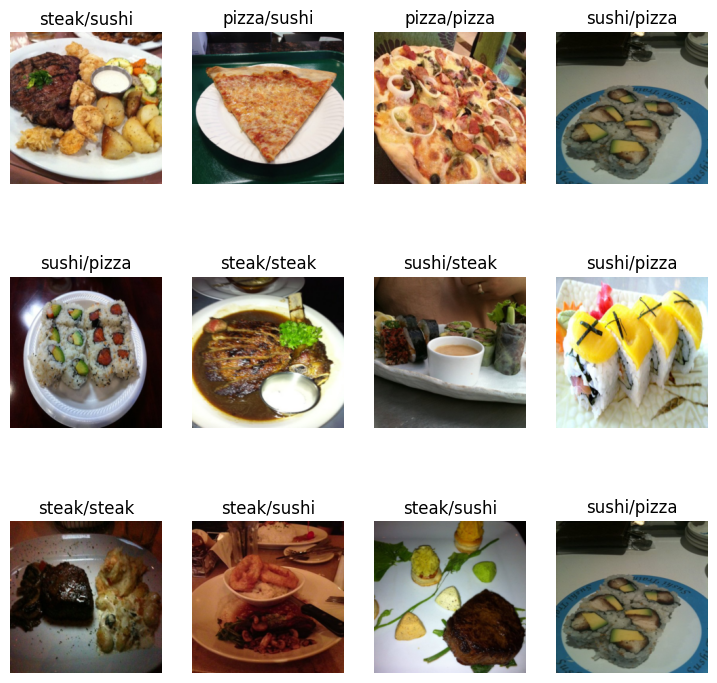

In [161]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
model_custom_1.eval()
rows, cols = 3, 4
range_pics = range (1, rows * cols + 1)
with  torch.inference_mode():
    for i in range_pics:
        rand_index = torch.randint(0, len (test_data_aug), size =[1]).item()
        img, label = test_data_aug[rand_index]
        unsqz_img = torch.unsqueeze(img, dim = 0).to(device)
        pred_label = model_custom_1(unsqz_img).argmax(dim = 1)
        fig.add_subplot(rows, cols, i)
        plt.imshow(img.squeeze().permute(1,2,0))
        plt.title(class_names[label] + '/' + class_names[pred_label])
        plt.axis(False)


## confusion matrix

In [165]:
y_preds = []
model_custom_1.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader_aug, desc = 'Predictions with augmented data'):
        X, y = X.to(device), y.to(device)
        y_logit = model_custom_1(X)
        y_pred = torch.softmax(y_logit, dim = 1).argmax(dim = 1)
        y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)


Predictions with augmented data: 100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


In [168]:
test_data.classes

['pizza', 'steak', 'sushi']

In [170]:
confmat = ConfusionMatrix(num_classes=len(class_names), task = 'multiclass')
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(12,9)
)

AttributeError: 'list' object has no attribute 'ndim'